# This EDA is Work in Progress !

# miRNA Biomarker for Lung Cancer Diagnostics

***- Selecting a test panel for patient classification -***

Author: Dr. Patrick Neubert <br>
eMail: patrick.neubert@t-online.de <br>
LinkedIn: https://www.linkedin.com/in/dr-patrick-neubert-91910b111/

## Intention

Lung cancer is the most prevalent cancer disease worldwide. The current standard diagnostics for lung cancer are X-ray imaging, sputum cytology and tissue samples (biopsy), which are inapplicable for early detection screenings. My project uses machine learning algorithms analyzing a panel of miRNA biomarkers in blood samples to classify patients into the groups "lung cancer", "non-tumor lung disease" and "control".

## Import

### Packages & Modules

In [1]:
# make this list nice in the end

import pandas as pd
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz  
from subprocess import call
from IPython.display import Image

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier


from sklearn.svm import SVC
from xgboost import XGBClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, fbeta_score, f1_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE

# Supress Convergence Warnings for Logistic Regression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Enables to exit execution of code
import sys

# for saving and loading data
import pickle

from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError

from mlxtend.classifier import StackingCVClassifier
from mlxtend.classifier import EnsembleVoteClassifier

from sklearn.preprocessing import StandardScaler

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Functions

In [2]:
# insert all used written functions here

In [3]:
# Function #1
# Function for feature_selection
# from Feature Importance of Tree-based Classifiers

def feature_selection(results_dict, tree_clf, name_clf, X_train, y_train, n=20):

    # n is the number of Features + Importances added to the results dictionary (default=20)
    # and printed during process for each classifier
    # if n=None all Features + Importances are added and printed
    
    count = 0
    for classifier in tree_clf:
        # use classifiers to fit data
        classifier.fit(X_train, y_train)
    
    
        # calculate Feature Importances, rank by value and get Feature Name
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_name = X_train.columns[indices]
    
        # Write first n Ranks to dictionary results_dict as 
        # "name_clf: (feature_name, importance)", default is n=20
        results_dict[name_clf[count]] = list(zip(feature_name[0:n], importances[indices][0:n]))     
        count +=1
    
        # Print the feature ranking (only the first n Ranks), default is n=20
        print(80*"-") 
        print(classifier)
        print("Feature ranking:")
        for feature in range(n) if isinstance(n, int) else range(importances.size):
            print("%d. Feature: %s (%f)" % (feature + 1, X_train.columns[indices[feature]], importances[indices[feature]]))
        
    return results_dict

In [4]:
# Function #2
# Function for RFE Feature Selection

def rfe_selection(results_dict, non_tree_clf, nt_name_clf, X_train, y_train):
    
    count = 0
    for classifier in non_tree_clf:
        
        #Initialize RFE Feature Selector
        rfe_selector = RFE(estimator=classifier, n_features_to_select=1, step=1) 
        
        # fit data
        rfe_selector.fit(X_train, y_train) 
        
        # get the indices of Feature Ranking
        indices = rfe_selector.ranking_
        
        # Create a Lists with ordered feature names 
        # from ranking (list with ordered positions of object in DataFrame)
        feature_name = []
        
        # to get the rank (index of ranking) another list is created 
        feature_rank = []
        
        for feature in indices:
            
            # [feature-1] because columns starts at index 0 = Position1 in Dataframe
            feature_name.append(X_train.columns[feature-1])
            
            # make a list of indices array and get the index of the feature 
            #(+1, because index of this list starts at 0) = rank of feature
            feature_rank.append(list(indices).index(feature)+1)
    
        # Write first 20 Ranks to dictionary results_dict as 
        # "nt_name_clf: (feature_name, feature_rank)"
        results_dict[nt_name_clf[count]] = list(zip(feature_name[0:20], feature_rank[0:20]))     
        count +=1
    
        # Print the feature ranking (only the first 20 Ranks)
        print(80*"-") 
        print(classifier)
        print("Feature ranking:")
        for feature in range(20):
            print("%d. Feature: %s" % (feature + 1, feature_name[feature]))
        
    return results_dict

In [5]:
# Function #3
#Function to create Dataframe with selected Features

def dataframe_selection(results_fs, X_train):
    
    #First create a list of selected Features from Feature Selection Results
    selected_features = [feature_name[0] for feature_name in results_fs]

    #Then create exclusion list for dropping (default=X_train)
    exclusion_list = list(set(X_train.columns) - set(selected_features))

    #Now drop all from X_train except selected_features and create new dataframe
    X_new = X_train.drop(exclusion_list, axis=1)
    
    return X_new    

In [6]:
# Function #4
# Function for model_evaluation

def model_evaluation(results_dict, model_clf, name_model, X_train, y_train):
    count = 0
    for model in model_clf:
        # use model to be cross validated with data and desired metrics
        validation = cross_validate(model, X_train, y_train, scoring = ('accuracy', 'roc_auc_ovr', 'precision_macro', 'f1_macro'))

        #get metric scores from validation dictionary and calculate mean
        accuracy = np.mean(validation['test_accuracy'])
        roc_auc = np.mean(validation['test_roc_auc_ovr'])
        precision = np.mean(validation['test_precision_macro'])
        f1 = np.mean(validation['test_f1_macro'])


        # Write all mean scores to dictionary results_cv as 
        # "name_model: {"Accuracy":accuracy,"Roc_AUC":roc_auc,"Precision":precision,"F1":f1}"
        results_dict[name_model[count]] = {"Accuracy":accuracy,"Roc_AUC":roc_auc,"Precision":precision,"F1":f1}

        # Print the scores for each model
        print(80*"-") 
        print(model)
        print("Scores:")
        print(results_dict[name_model[count]])

        count +=1
        
    return results_dict

In [7]:
# Function #5
# function to print the n best model + selection combinations
# (n highest values with their index, column) for a certain
# dataframe (default n=3)

def top_model(dataframe, n=3):
    
    # create an numpy array of all values
    # (as copy to ensure original dateframe is not touched)
    values = dataframe.to_numpy(copy=True)
    
    #sort values to get the max per row (=model)
    values.sort()
    
    # make a list of the max values for each row (=model)

    top_model = []

    for val in range(values.shape[0]):
        top_model.append(values[val][-1])
    
    # sort the list descending to get the highest values in the whole dataframe first
    top_model.sort(reverse=True)
    
    # print out the Top n Values (of all in dataframe)
    for tm in range(n) if n<= values.shape[0] else range(values.shape[0]):
       
        #get index and colum name (=Model + Selection)
        idx, clm = np.where(dataframe == top_model[tm])
        
        print("TOP:", tm+1)
        print("Value:", top_model[tm])
        print("Model:", dataframe.index[idx][0])
        print("Feature Selection:", dataframe.columns[clm][0])
        print(65*"-")

In [8]:
# Function #6
def multibar_plot(bars, label_list, name, title, xlb, barWidth = 0.1):
     
    #gives an array with indeces of dataframe @ postion [0] in bars list
    r1 = np.arange(len(bars[0]))
    
    # Set position of other bars relative to r1 on X axis and save it in position_list
    # set barWidth = 0.1 by default
    position_list = []
    for ps in list(range(1, len(bars))):
        r2 = [x + barWidth*ps for x in r1]
        position_list.append(r2)

    #set Size of figure
    plt.figure(figsize=(25,10))

    # Make the plot
    plt.bar(r1, bars[0], width=barWidth, edgecolor='white', label=label_list[0])
    
    for num in list(range(1, len(bars))):
        plt.bar(position_list[num-1], bars[num], width=barWidth, edgecolor='white', label=label_list[num])
        
    # wenn weniger labels als bars dann geht es nicht!
        
    # Add xticks on the middle of the group bars
    plt.xlabel(xlb, fontweight='bold') #, fontsize='large')
    
    # to set ticks on the middle bar
    plt.xticks([r + barWidth*(int((len(label_list))/2)) for r in range(len(bars[0]))], name)
 
    # Create legend & Show graphic
    plt.legend(loc='best', bbox_to_anchor=(0.46, 0.0, 0.7 ,0.36)) #, fontsize='medium')
    plt.title(label=title, fontweight='bold') #, fontsize='large')
    plt.show()

In [9]:
# Function #7
#function for RandomSearchCV + printing results

def random_searching(model, parameters, X_train, y_train, X_test, y_test):
    
    # Perform Random search on the classifier using 'precision_micro' as the scoring method 
    #(micro = Calculate metrics globally by counting the total true positives, false negatives and false positives.)
    random_obj = RandomizedSearchCV(model, parameters, scoring='precision_micro', n_jobs = -1, verbose=5, n_iter=100, cv=5, random_state=seed)

    # Fit the Random search object to the training data and find the optimal parameters
    random_fit = random_obj.fit(X_train, y_train)
    
    #Fit the unoptimzed model
    model_fit = model.fit(X_train, y_train)

    # Get the estimators
    best_model = random_fit.best_estimator_

    # Make predictions using the unoptimized and optimized model
    predictions = model_fit.predict(X_test)
    best_predictions = best_model.predict(X_test)
    
    probabilities = model_fit.predict_proba(X_test)
    best_probabilities = best_model.predict_proba(X_test)
    
    #get all the metrics of optimized and unoptimized model
    accuracy = accuracy_score(y_test, predictions)
    accuracy_best = accuracy_score(y_test, best_predictions)
    
    roc_auc = roc_auc_score(y_test, probabilities, multi_class='ovr')
    roc_auc_best = roc_auc_score(y_test, best_probabilities, multi_class='ovr')
    
    precision = precision_score(y_test, predictions, average='micro')
    precision_best = precision_score(y_test, best_predictions, average='micro')
    
    f1 = f1_score(y_test, predictions, average='micro')
    f1_best = f1_score(y_test, best_predictions, average='micro')
    
    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score Unoptimized:", accuracy)
    print("Roc_AUC score Unoptimized:", roc_auc)
    print("Precision score Unoptimized:", precision)
    print("F1 score Unoptimized:", f1)
   
    print("\nOptimized Model\n------")
    print("Accuracy score Optimized:", accuracy_best)
    print("Roc_AUC score Optimized:", roc_auc_best)
    print("Precision score Optimized:", precision_best)
    print("F1 score Optimized:", f1_best)
    print(best_model)

In [10]:
# Function #8
#function for GridSearchCV + printing and saving results results

def grid_searching(results_dict, model, name_model, parameters, X_train, y_train, X_test, y_test):
    
    # Perform grid search on the classifier using 'precision_micro' as the scoring method 
    #(micro = Calculate metrics globally by counting the total true positives, false negatives and false positives.)
    grid_obj = GridSearchCV(model, parameters, scoring='precision_micro', n_jobs = -1, verbose=5, cv=5)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)
    
    #Fit the unoptimzed model
    model_fit = model.fit(X_train, y_train)

    # Get the estimators
    best_model = grid_fit.best_estimator_

    # Make predictions using the unoptimized and optimized model
    predictions = model_fit.predict(X_test)
    best_predictions = best_model.predict(X_test)
    
    probabilities = model_fit.predict_proba(X_test)
    best_probabilities = best_model.predict_proba(X_test)
    
    #get all the metrics of optimized and unoptimized model
    accuracy = accuracy_score(y_test, predictions)
    accuracy_best = accuracy_score(y_test, best_predictions)
    
    roc_auc = roc_auc_score(y_test, probabilities, multi_class='ovr')
    roc_auc_best = roc_auc_score(y_test, best_probabilities, multi_class='ovr')
    
    precision = precision_score(y_test, predictions, average='micro')
    precision_best = precision_score(y_test, best_predictions, average='micro')
    
    f1 = f1_score(y_test, predictions, average='micro')
    f1_best = f1_score(y_test, best_predictions, average='micro')
    
    
    # Write all mean scores to dictionary results_dict as 
    # "name_model: {"Accuracy":accuracy_best,"Roc_AUC":roc_auc,"Precision":precision,"F1":f1}"
    results_dict[name_model[0]] = {"Accuracy":accuracy,"Roc_AUC":roc_auc,"Precision":precision,"F1":f1}
    results_dict[name_model[1]] = {"Accuracy":accuracy_best,"Roc_AUC":roc_auc_best,"Precision":precision_best,"F1":f1_best}
    
    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score Unoptimized:", accuracy)
    print("Roc_AUC score Unoptimized:", roc_auc)
    print("Precision score Unoptimized:", precision)
    print("F1 score Unoptimized:", f1)
   
    print("\nOptimized Model\n------")
    print("Accuracy score Optimized:", accuracy_best)
    print("Roc_AUC score Optimized:", roc_auc_best)
    print("Precision score Optimized:", precision_best)
    print("F1 score Optimized:", f1_best)
    print(best_model)

In [11]:
# Function #9
def viz_summary(results_dict, metric):
    print(metric, "Value:")
    print(results_dict.T[metric])
    print(40*"-")
    print(metric, "Rank:")
    print(results_dict.T[metric].rank())

In [12]:
# Function #10
def feature_reduce(results_reduction, model_reduction, name_list, feature_list, elim_features, X_train, n=11):
        
    name_reduction = name_list.copy()
    feature_reduction = feature_list.copy()

    # set default for n=11 iterations =(From All20 to TOP10)
    for n in range(n):
        
        # Create exclusion list for dropping (default=X_train)
        exclusion_list = list(set(X_train.columns) - set(feature_reduction))
        
        #Now drop all from X_train except feature_reduction and create new dataframe (first iteration all)
        X_reduce = X_train.drop(exclusion_list, axis=1)
        
       
        # Use model_evaluation function with reduced Features Dataset
        model_evaluation(results_reduction, model_reduction, name_reduction, X_reduce, y_train)
    
        #return the list with features used (only for debugging)
        elim_features.append(X_reduce.columns)
    
        # reduce feature list by 1 Feature
        feature_reduction.pop()
    
        # get new key for results dictionary
        name_reduction.pop(0)
    
    return results_reduction

In [13]:
# Function #11
# Function for plottin Classification Report and final Precision
def score_eval(y_test, y_pred):
    # precision micro = Calculate metrics globally by counting the total true positives,
    # false negatives and false positives.
    score = precision_score(y_test, y_pred, average='micro')
    
    print('Final Precision Score (micro):', score)
    print('----' * 15)
    print('Classification Report')
    print(classification_report(y_test, y_pred))
    print('----' * 15)
    
    return score

In [14]:
# Function #12
# function to print heatmap

def heatmap(correlation, name_savefig):

    # Create Correlation Heatmap for all values (with minimum value -1 for positive or negative correlation)
    plt.figure(figsize=(20,20))
    heatmap = sns.heatmap(correlation, vmin=-1, cmap="seismic", annot=True) #inferno, seismic, magma, icefire
    
    # save figure
    plt.savefig(name_savefig, transparent=True, dpi=200)
        

### Prerequisites

In [15]:
# set random_state seed
# to exclude for randomness effects in the notebook
seed=1

In [16]:
#Here (and anywhere else the colors, etc. have to be adjusted in the end)
# maybe choose something I like and for colorblindnes or so...
# think about converting everything if possible to seaborn?
# but using both is also cool

#set color palette for MatPlotLib
plt.style.use('seaborn-dark-palette')

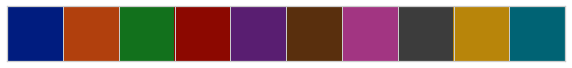

In [17]:
# set current color palette for seaborn
current_palette = sns.color_palette(palette="dark")
sns.palplot(current_palette)
sns.set(palette="dark")

In [18]:
#sns.set(font_scale=2) #Problem is that it scales all fonts globally which destroys other plots

### Dataset

The dataset was a kind gift of Hummingbird Diagnostics GmbH (https://www.hummingbird-diagnostics.com) provided by neuefische GmbH (https://www.neuefische.de/)

#### Overview

| Column Name | Description | Type | Others | 
|-------------|-------------|------|--------|
| sampleID | Sample Reference | Object | 300 Samples|
| Group | Sample Label | Categorical | NTLD (Non-Tumour Lung-Disease),<br>LCa (Lung Cancer),<br>CON (CONtrol Group)|
| Sex | Gender | Categorical | male or female|
| Age | Age | Numeric | 34 - 84 |
| Smoke | Smoker | Categorical | present,<br>past,<br>never|
| hsa-let-7a-3p - <br>hsa-miR-99b-5p | miRNA Expression Values | Numeric | 1183 different miRNA 

#### Loading Data and creating a Pandas Dataframe

In [19]:
# Loading Excel-File with Annotation
df1 = pd.read_excel('data/LC_annotation.xlsx')
print('The dataframe consist of {} rows and {} columns.'.format(df1.shape[0], df1.shape[1]))
df1.head()

The dataframe consist of 300 rows and 5 columns.


,sampleID,Group,Sex,Age,Smoke
0,SampleLC_1,NTLD,male,34.0,NaN
1,SampleLC_2,NTLD,female,35.0,NaN
2,SampleLC_3,NTLD,female,37.0,NaN
3,SampleLC_4,LCa,female,43.5,Past
4,SampleLC_5,NTLD,male,44.0,Present


In [20]:
# Info about d(ata)types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sampleID  300 non-null    object 
 1   Group     300 non-null    object 
 2   Sex       294 non-null    object 
 3   Age       297 non-null    float64
 4   Smoke     247 non-null    object 
dtypes: float64(1), object(4)
memory usage: 11.8+ KB


In [21]:
# Setting Index to sampleID for later joining Dataframes
df1.set_index("sampleID")

,Group,Sex,Age,Smoke
sampleID,,,,
SampleLC_1,NTLD,male,34.0,NaN
SampleLC_2,NTLD,female,35.0,NaN
SampleLC_3,NTLD,female,37.0,NaN
SampleLC_4,LCa,female,43.5,Past
SampleLC_5,NTLD,male,44.0,Present
...,...,...,...,...
SampleLC_296,NTLD,male,83.0,Past
SampleLC_297,CON,male,84.0,Past
SampleLC_298,LCa,male,NaN,Past


In [22]:
# Loading .txt-File with miRNA-Expression Data
df2 = pd.read_table('data/LC_data_non_log.txt')
print('The dataframe consist of {} rows and {} columns.'.format(df2.shape[0], df2.shape[1]))
df2.head()

The dataframe consist of 1183 rows and 300 columns.


,SampleLC_1,SampleLC_2,SampleLC_3,SampleLC_4,SampleLC_5,SampleLC_6,SampleLC_7,SampleLC_8,SampleLC_9,SampleLC_10,...,SampleLC_291,SampleLC_292,SampleLC_293,SampleLC_294,SampleLC_295,SampleLC_296,SampleLC_297,SampleLC_298,SampleLC_299,SampleLC_300
hsa-let-7a-3p,10.169737,8.993866,9.221781,9.700501,6.133340,7.275606,7.449349,7.883027,5.694632,7.676339,...,10.231375,7.488037,24.502362,6.388280,7.690654,6.299681,10.355813,8.769300,7.280144,7.214706
hsa-let-7a-5p,5717.565532,8152.894560,9161.633060,15589.388815,23861.201568,9901.092307,9353.363102,21256.531275,40763.465605,29245.233210,...,16196.642530,700.533350,8726.485189,22803.481320,25015.375396,22466.730785,11628.542374,136769.972052,26820.547670,26597.044525
hsa-let-7b-3p,15.373312,14.683980,15.751940,11.411269,25.375915,9.623426,17.974963,14.870346,24.793596,18.707404,...,20.736437,17.581660,32.999253,13.348059,18.129165,22.954418,17.644106,13.651284,22.475348,25.833810
hsa-let-7b-5p,2888.175532,3805.584560,1262.754060,7857.315268,9886.602937,2163.823798,4105.700075,16453.774838,20718.366066,10620.324339,...,14533.701990,1972.377350,9391.409855,33118.422360,18110.775679,47644.899330,16593.222849,83604.788124,20045.890411,32703.037481
hsa-let-7c-5p,657.148032,906.707560,301.175060,1510.150845,2891.103594,387.774260,779.223334,4264.195792,6357.348000,2607.322331,...,2154.289849,134.971650,1263.326599,7542.868162,4076.368624,10307.480329,2191.549352,21619.300366,4307.879298,7170.643628


In [23]:
# Check for column names
list(df2.columns) 

['SampleLC_1',
 'SampleLC_2',
 'SampleLC_3',
 'SampleLC_4',
 'SampleLC_5',
 'SampleLC_6',
 'SampleLC_7',
 'SampleLC_8',
 'SampleLC_9',
 'SampleLC_10',
 'SampleLC_11',
 'SampleLC_12',
 'SampleLC_13',
 'SampleLC_14',
 'SampleLC_15',
 'SampleLC_16',
 'SampleLC_17',
 'SampleLC_18',
 'SampleLC_19',
 'SampleLC_20',
 'SampleLC_21',
 'SampleLC_22',
 'SampleLC_23',
 'SampleLC_24',
 'SampleLC_25',
 'SampleLC_26',
 'SampleLC_27',
 'SampleLC_28',
 'SampleLC_29',
 'SampleLC_30',
 'SampleLC_31',
 'SampleLC_32',
 'SampleLC_33',
 'SampleLC_34',
 'SampleLC_35',
 'SampleLC_36',
 'SampleLC_37',
 'SampleLC_38',
 'SampleLC_39',
 'SampleLC_40',
 'SampleLC_41',
 'SampleLC_42',
 'SampleLC_43',
 'SampleLC_44',
 'SampleLC_45',
 'SampleLC_46',
 'SampleLC_47',
 'SampleLC_48',
 'SampleLC_49',
 'SampleLC_50',
 'SampleLC_51',
 'SampleLC_52',
 'SampleLC_53',
 'SampleLC_54',
 'SampleLC_55',
 'SampleLC_56',
 'SampleLC_57',
 'SampleLC_58',
 'SampleLC_59',
 'SampleLC_60',
 'SampleLC_61',
 'SampleLC_62',
 'SampleLC_63',
 

In [24]:
# Transforming columns to rows for later joining Dataframes
df3 = df2.T
df3

,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,hsa-let-7e-5p,hsa-let-7f-1-3p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
SampleLC_1,10.169737,5717.565532,15.373312,2888.175532,657.148032,12.143632,1132.221532,8.342056,12.709765,15.246492,...,6.390441,7.820884,8.481891,5.932662,112.3047,34.32323,7.073449,14.79587,6.989605,28.41288
SampleLC_2,8.993866,8152.894560,14.683980,3805.584560,906.707560,15.848390,2179.307560,7.768405,13.259530,15.283550,...,5.234970,7.567298,7.847653,5.985716,185.2690,47.13855,5.724681,15.02991,6.412826,13.66082
SampleLC_3,9.221781,9161.633060,15.751940,1262.754060,301.175060,11.262490,2109.316060,7.818980,14.886700,15.012240,...,4.435148,7.738681,7.893889,5.410440,182.6446,66.89235,6.719895,19.68656,7.317585,48.61566
SampleLC_4,9.700501,15589.388815,11.411269,7857.315268,1510.150845,13.626656,4481.149119,8.676516,10.873760,10.111823,...,7.808394,8.844422,8.782223,8.176937,366.1072,40.31580,8.553054,224.52850,8.869005,66.39760
SampleLC_5,6.133340,23861.201568,25.375915,9886.602937,2891.103594,13.644561,7956.128794,5.782573,39.909468,22.623516,...,4.946353,5.378983,6.080522,5.319329,1501.0180,122.96760,5.220272,211.52930,5.563860,99.50221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SampleLC_296,6.299681,22466.730785,22.954418,47644.899330,10307.480329,13.041664,5133.560521,5.776714,62.233689,20.171781,...,5.574495,5.378178,5.366570,4.894972,826.7432,95.43954,5.404515,65.70854,5.045749,101.93690
SampleLC_297,10.355813,11628.542374,17.644106,16593.222849,2191.549352,11.748126,3800.721213,9.260355,13.064850,16.740129,...,9.619025,9.268547,9.457460,8.677452,112.1474,38.56062,9.135264,75.32278,9.472440,22.70615
SampleLC_298,8.769300,136769.972052,13.651284,83604.788124,21619.300366,11.095983,37482.640286,7.227814,145.870447,14.578901,...,6.811184,7.106680,7.905371,6.557362,1903.2900,945.21340,7.451859,89.09280,7.172268,112.37630
SampleLC_299,7.280144,26820.547670,22.475348,20045.890411,4307.879298,12.461183,6737.042894,6.507586,47.845434,20.557395,...,6.026219,6.335448,6.905308,5.775721,598.3689,124.62590,6.128294,101.78550,6.268956,137.15720


In [25]:
# Info about d(ata)types
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, SampleLC_1 to SampleLC_300
Columns: 1183 entries, hsa-let-7a-3p to hsa-miR-99b-5p
dtypes: float64(1183)
memory usage: 2.7+ MB


In [26]:
# Check for column names again
list(df3.columns) 

['hsa-let-7a-3p',
 'hsa-let-7a-5p',
 'hsa-let-7b-3p',
 'hsa-let-7b-5p',
 'hsa-let-7c-5p',
 'hsa-let-7d-3p',
 'hsa-let-7d-5p',
 'hsa-let-7e-3p',
 'hsa-let-7e-5p',
 'hsa-let-7f-1-3p',
 'hsa-let-7f-2-3p',
 'hsa-let-7f-5p',
 'hsa-let-7g-3p',
 'hsa-let-7g-5p',
 'hsa-let-7i-3p',
 'hsa-let-7i-5p',
 'hsa-miR-1-3p',
 'hsa-miR-100-3p',
 'hsa-miR-100-5p',
 'hsa-miR-101-3p',
 'hsa-miR-101-5p',
 'hsa-miR-103a-2-5p',
 'hsa-miR-103a-3p',
 'hsa-miR-103b',
 'hsa-miR-105-3p',
 'hsa-miR-105-5p',
 'hsa-miR-106a-3p',
 'hsa-miR-106b-3p',
 'hsa-miR-106b-5p',
 'hsa-miR-107',
 'hsa-miR-10a-3p',
 'hsa-miR-10a-5p',
 'hsa-miR-10b-3p',
 'hsa-miR-10b-5p',
 'hsa-miR-1178-3p',
 'hsa-miR-1179',
 'hsa-miR-1180-3p',
 'hsa-miR-1181',
 'hsa-miR-1182',
 'hsa-miR-1183',
 'hsa-miR-1184',
 'hsa-miR-1185-5p',
 'hsa-miR-1193',
 'hsa-miR-1197',
 'hsa-miR-1200',
 'hsa-miR-1202',
 'hsa-miR-1203',
 'hsa-miR-1204',
 'hsa-miR-1205',
 'hsa-miR-1206',
 'hsa-miR-1207-3p',
 'hsa-miR-1207-5p',
 'hsa-miR-1208',
 'hsa-miR-122-3p',
 'hsa-miR

In [27]:
# Joining Dataframes
df4 = df1.join(df3, on="sampleID", how='outer')
print('The dataframe consist of {} rows and {} columns.'.format(df4.shape[0], df4.shape[1]))
df4.head()

The dataframe consist of 300 rows and 1188 columns.


,sampleID,Group,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
0,SampleLC_1,NTLD,male,34.0,NaN,10.169737,5717.565532,15.373312,2888.175532,657.148032,...,6.390441,7.820884,8.481891,5.932662,112.3047,34.32323,7.073449,14.79587,6.989605,28.41288
1,SampleLC_2,NTLD,female,35.0,NaN,8.993866,8152.894560,14.683980,3805.584560,906.707560,...,5.234970,7.567298,7.847653,5.985716,185.2690,47.13855,5.724681,15.02991,6.412826,13.66082
2,SampleLC_3,NTLD,female,37.0,NaN,9.221781,9161.633060,15.751940,1262.754060,301.175060,...,4.435148,7.738681,7.893889,5.410440,182.6446,66.89235,6.719895,19.68656,7.317585,48.61566
3,SampleLC_4,LCa,female,43.5,Past,9.700501,15589.388815,11.411269,7857.315268,1510.150845,...,7.808394,8.844422,8.782223,8.176937,366.1072,40.31580,8.553054,224.52850,8.869005,66.39760
4,SampleLC_5,NTLD,male,44.0,Present,6.133340,23861.201568,25.375915,9886.602937,2891.103594,...,4.946353,5.378983,6.080522,5.319329,1501.0180,122.96760,5.220272,211.52930,5.563860,99.50221


In [28]:
# Info about d(ata)types
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Columns: 1188 entries, sampleID to hsa-miR-99b-5p
dtypes: float64(1184), object(4)
memory usage: 2.7+ MB


## Data Cleaning

### Missing Values

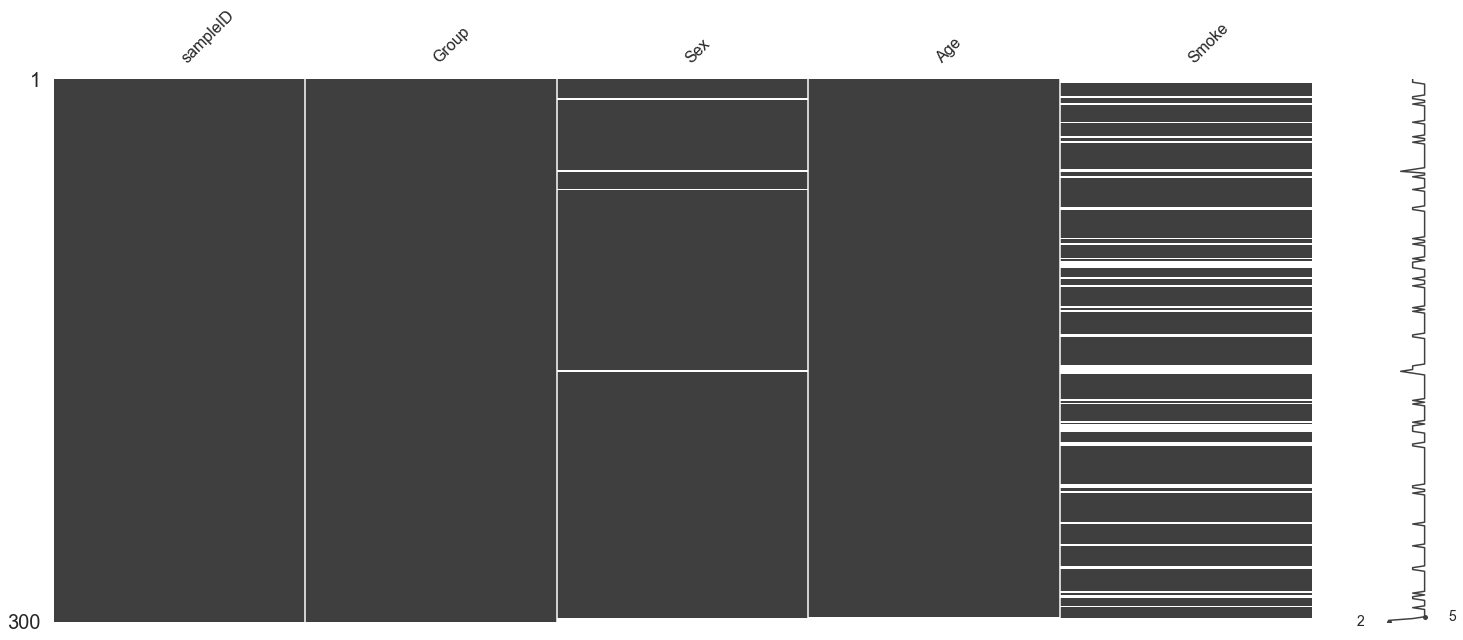

In [29]:
#Check for missing values in df1
missingno.matrix(df1)

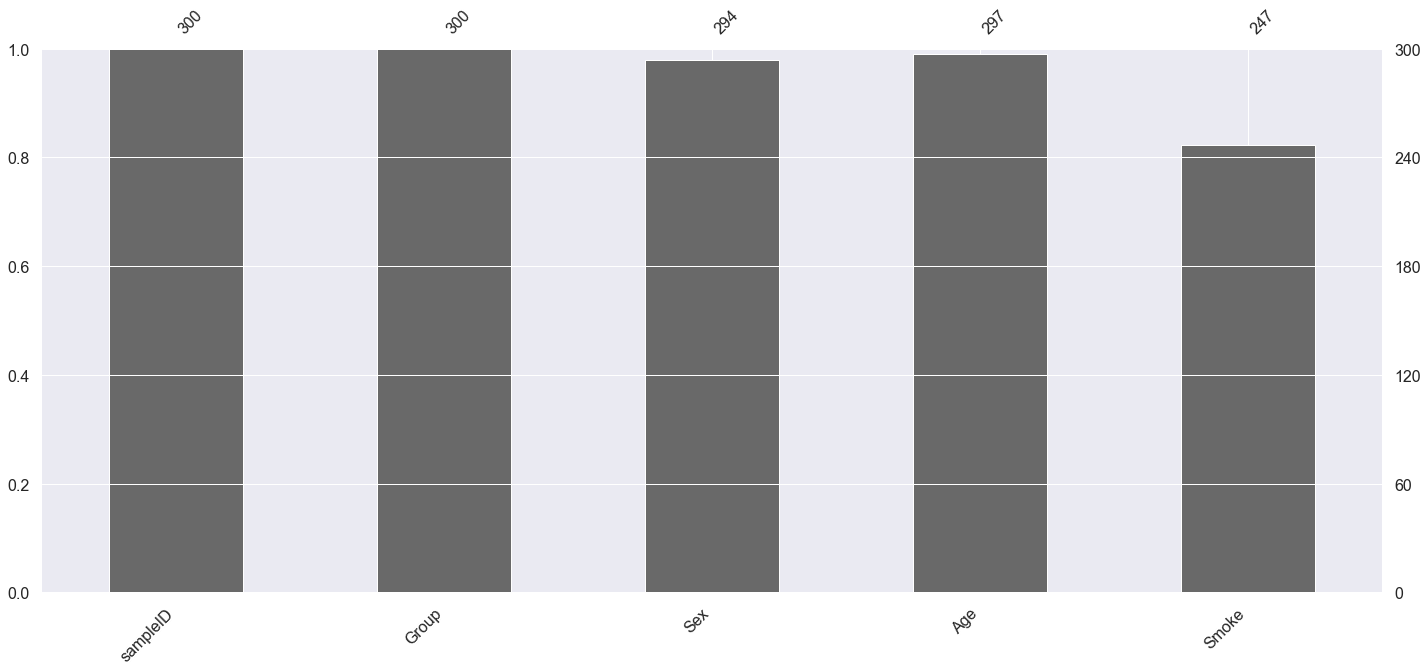

In [30]:
missingno.bar(df1)

In [31]:
df1.isna().sum()

sampleID     0
Group        0
Sex          6
Age          3
Smoke       53
dtype: int64

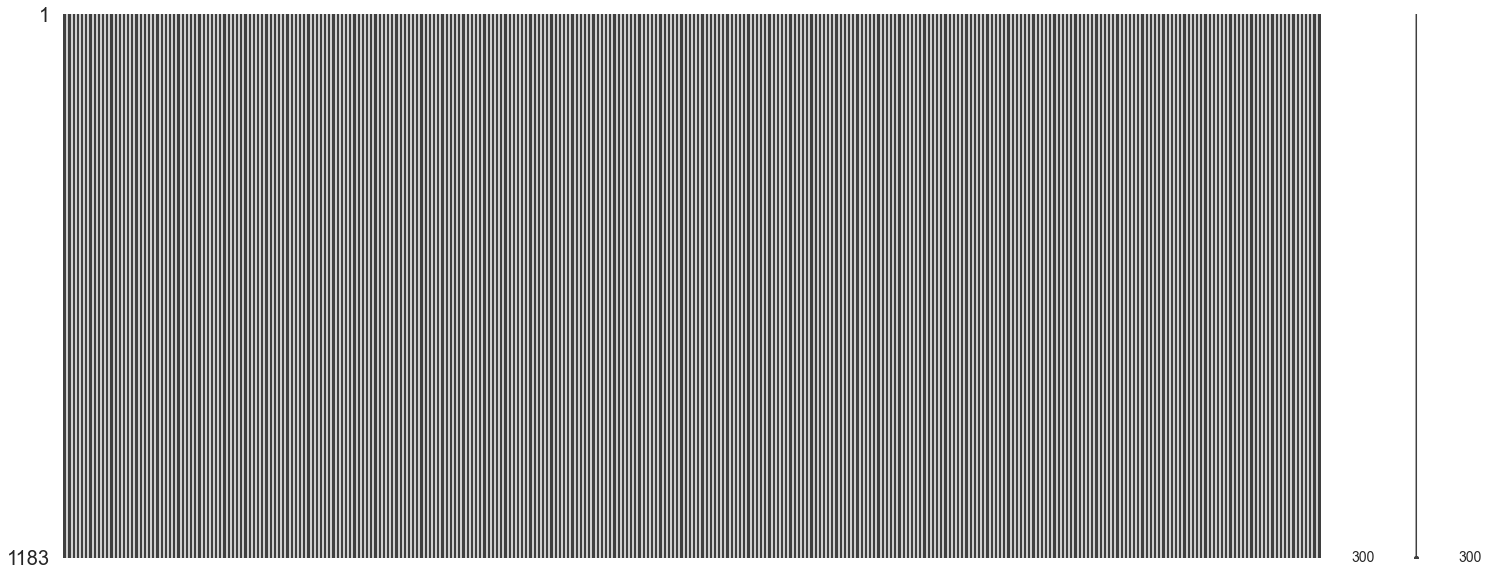

In [32]:
#Check for missing values in df2
missingno.matrix(df2)

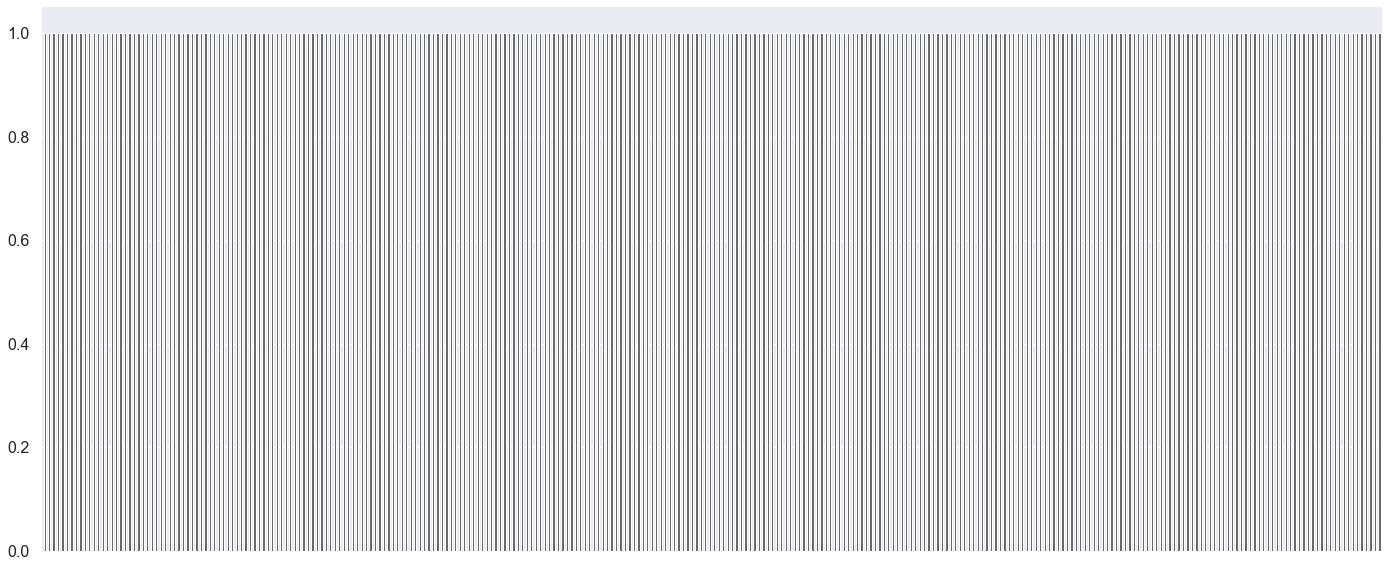

In [33]:
missingno.bar(df2)

In [34]:
df2.isna().sum()

SampleLC_1      0
SampleLC_2      0
SampleLC_3      0
SampleLC_4      0
SampleLC_5      0
               ..
SampleLC_296    0
SampleLC_297    0
SampleLC_298    0
SampleLC_299    0
SampleLC_300    0
Length: 300, dtype: int64

There are values missing for Sex (6/300; 2%), Age (3/300; 1%) and Smoke (53/300; 17.6%) in df1 and no missing values in df2. These missing values can be neclected as the data of these Features are not need for our intentions. <br>  The aim is to use a set of 10 to 20 miRNAs to predict a group of patients. As well miRNA data (Prediction Features) as group (Prediction Labels) show no missing values.

## Data Exploration

Visualization of different parts of the dataframe provides a first overview over the properties and distribution of the various features.

### Annotation

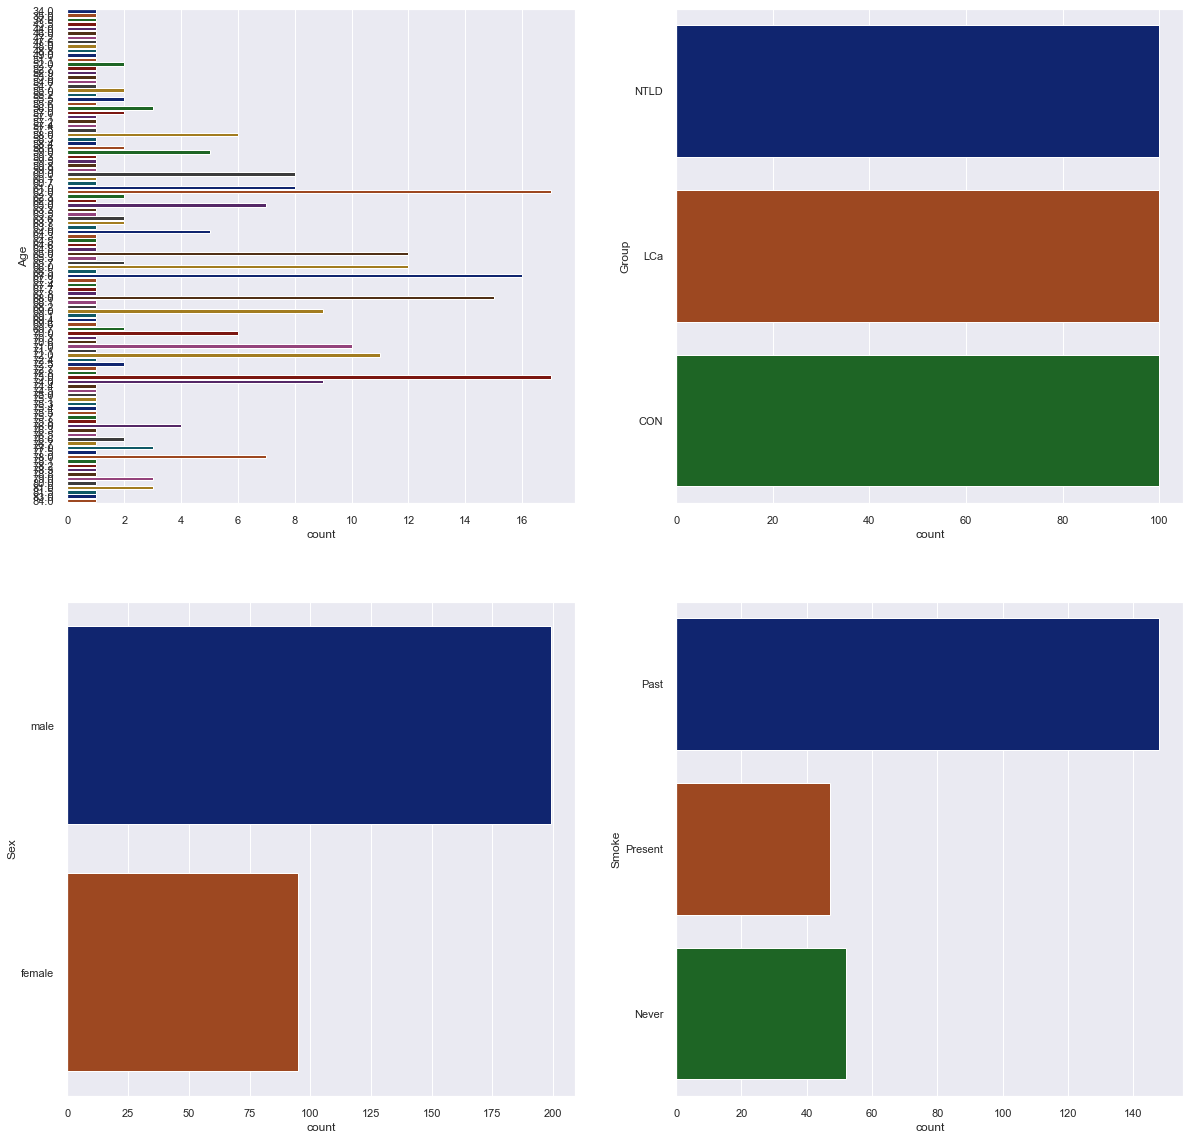

In [35]:
# Plots of Annotation
f, axes = plt.subplots(2, 2, figsize=(20, 20))
sns.countplot(y=df1.Age, ax=axes[0][0], palette=current_palette);
sns.countplot(y=df1.Group, ax=axes[0][1]);
sns.countplot(y=df1.Sex, ax=axes[1][0]);
sns.countplot(y=df1.Smoke, ax=axes[1][1]);

In [36]:
# Counting Values of Annotation
print(df1.Group.value_counts())
print(df1.Sex.value_counts())
print(df1.Smoke.value_counts())

NTLD    100
LCa     100
CON     100
Name: Group, dtype: int64
male      199
female     95
Name: Sex, dtype: int64
Past       148
Never       52
Present     47
Name: Smoke, dtype: int64


count    297.000000
mean      66.337710
std        8.090426
min       34.000000
25%       62.000000
50%       67.000000
75%       72.000000
max       84.000000
Name: Age, dtype: float64

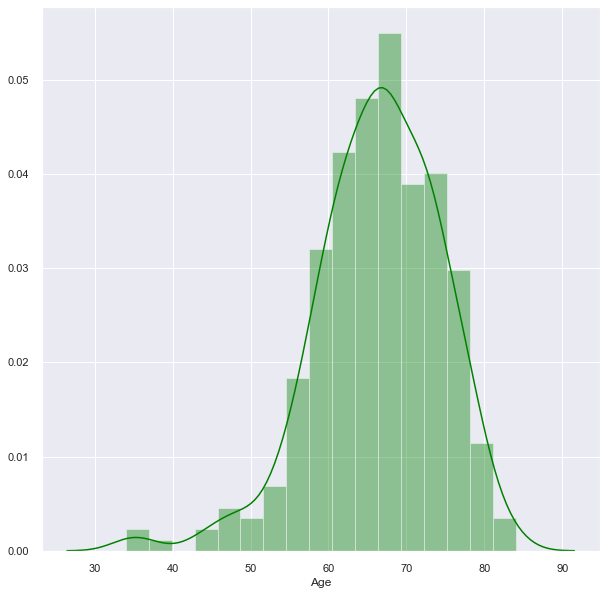

In [37]:
# Histogram for Age Distribution
plt.figure(figsize=(10,10))
sns.distplot(df1.Age, color="Green");
df1.Age.describe()

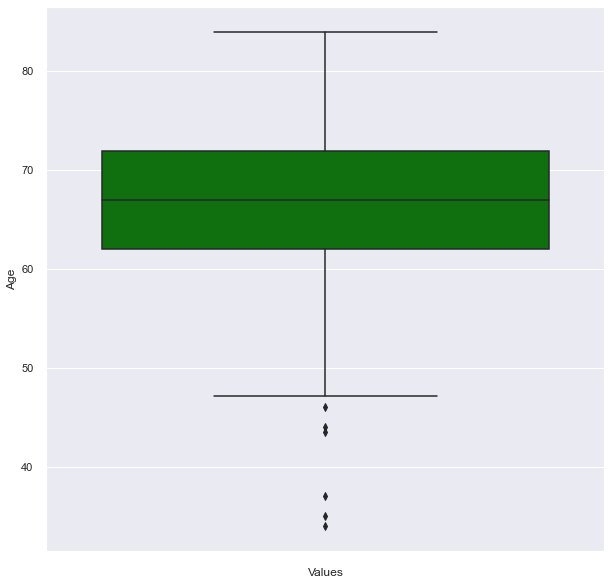

In [38]:
# Boxplot for Age (reveals the presence of outliers)
plt.figure(figsize=(10,10))
sns.boxplot(df1.Age, color="Green", orient="v")
plt.xlabel('Values');
plt.ylabel('Age');

- Groups is equally distributed between NTLD (100/300; 33.3%), LCa (100/300; 33.3%) and CON (100/300; 33.3%) (no imbalances; used as class label)
- more males (199/300; 66.3%) than females (95/300; 31.6%) in cohort (medium inbalance; not used as class label)
- more past smokers (148/300; 49.3%) than present (47/300; 15.6%) and never (52/300; 17.3%) smokers (medium inbalance; not used as class label)
- age is almost normally distributed (small subgroup / outliers between 34 and 47)

### miRNA-Expression Data

In [39]:
# Simple Statistics for each column / over all patients for each miRNA
df3.describe()

,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,hsa-let-7e-5p,hsa-let-7f-1-3p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,9.402791,23832.393325,19.559043,17974.643896,3789.420736,16.142173,6565.580723,8.785773,31.758458,18.074932,...,8.114372,8.384787,8.675664,7.723339,600.038161,123.315892,8.181131,89.346688,8.665373,81.749416
std,5.280378,23291.105557,7.399962,14424.037569,3420.570174,8.283376,6575.586782,5.272169,28.105664,6.824515,...,4.811039,4.945748,4.949045,4.605896,896.650391,193.986571,4.861083,66.851102,5.212743,61.000360
min,4.940617,38.339086,7.450113,42.280062,14.556718,5.587808,7.244910,4.542245,4.921895,7.085688,...,4.100124,4.300865,4.416310,4.048167,5.755420,5.594751,4.440024,6.793955,4.491491,6.019939
25%,6.658562,9516.969027,14.896490,8016.475395,1448.657211,10.925667,2732.859626,6.137592,16.579612,13.577476,...,5.616376,5.809403,6.101095,5.354176,110.089650,40.508820,5.680078,41.061370,5.912016,44.529785
50%,7.628066,17199.351502,17.481272,14156.440842,2963.611225,13.291748,4491.039755,7.117287,24.284067,16.227491,...,6.571538,6.913197,7.046945,6.234828,307.904750,66.225320,6.660271,72.068805,6.998983,69.419520
75%,9.750887,28684.175160,23.934594,26838.248546,4984.884862,18.164330,7913.861504,9.014158,35.380196,21.676177,...,8.578434,8.914393,8.969263,8.007796,674.267025,124.908650,8.234042,116.980850,8.843192,104.322350
max,56.642516,149962.333065,69.576656,83604.788124,21619.300366,61.529077,44740.793541,55.157347,259.268272,68.772438,...,52.471690,53.556260,51.972650,49.352820,8099.504000,1997.999000,50.939600,400.610300,54.590190,589.320900


In [40]:
# Check the description statment: "...Each column contains the concentration of specific miRNAs,
# while the sum of all miRNA concentrations per patient is constant..."
df5 = pd.DataFrame(df3.sum(axis=1)).rename(columns={0:"sum_miRNA"})
df5

,sum_miRNA
SampleLC_1,4.581314e+05
SampleLC_2,5.015698e+05
SampleLC_3,6.360268e+05
SampleLC_4,1.520136e+06
SampleLC_5,1.444430e+06
...,...
SampleLC_296,1.596045e+06
SampleLC_297,9.929835e+05
SampleLC_298,2.199376e+06
SampleLC_299,1.911118e+06


I assume that not all miRNAs are covered by analysis, but the total concentration of extraction was equal

count    3.000000e+02
mean     1.191841e+06
std      4.839428e+05
min      7.851522e+04
25%      8.814026e+05
50%      1.183958e+06
75%      1.458039e+06
max      3.506215e+06
Name: sum_miRNA, dtype: float64

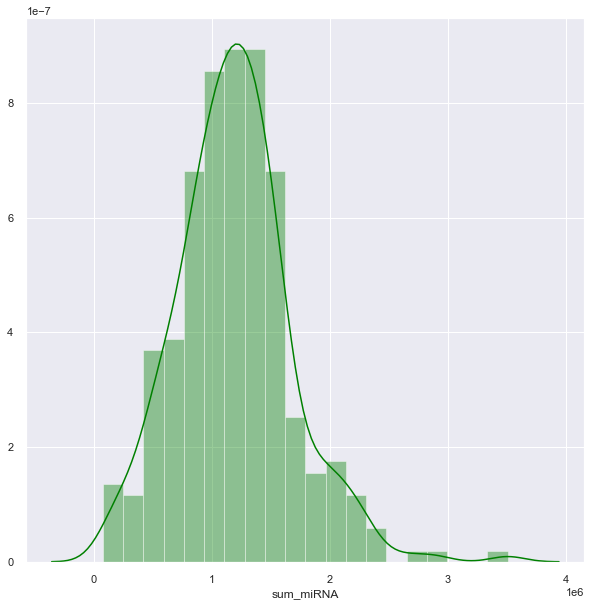

In [41]:
# Histogram for Distribution of Sum of miRNA
plt.figure(figsize=(10,10))
sns.distplot(df5.sum_miRNA, color="Green");
df5.sum_miRNA.describe()

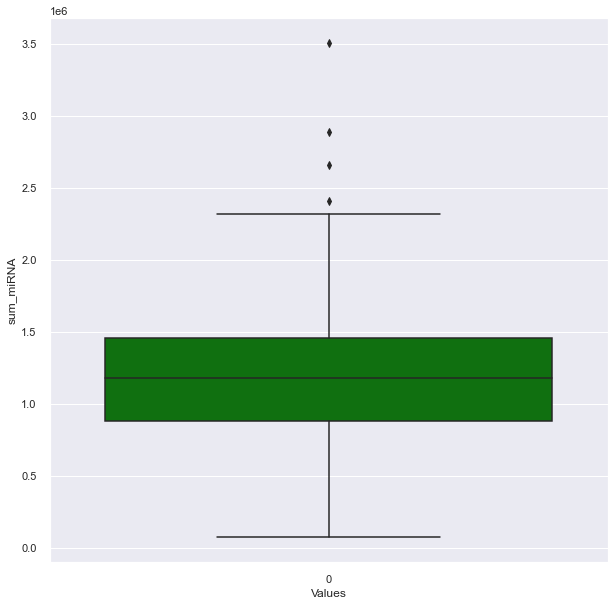

In [42]:
# Boxplot for Sum of miRNA (reveals the presence of outliers)
plt.figure(figsize=(10,10))
sns.boxplot(data=df5.sum_miRNA, color="Green")
plt.xlabel('Values');
plt.ylabel('sum_miRNA');

- sum_miRNA is almost normally distributed (small subgroup / outliers between 2.3e+06 and 3.5e+06)

## Feature Engineering

In [43]:
# Dummies are not necessary!
# Maybe later if Sex is taken in account as feature (or any other categorical)

In [44]:
# Creating new Column Label (encoding Labels to numerical Values 0,1,2)
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
# --> works without --> but could return a failure in Randomized Search?

#first create list with old labels
label_list = df4.Group.tolist()

#then encode labels to label_new list
label_new = []
for label in label_list:
    if label == "CON":
        label_new.append(0)
    elif label == "LCa":
        label_new.append(1)
    else:
        label_new.append(2)
        
# include new labels to the dataframe
df4.insert(2, "Label", label_new)

# check new dataframe
df4

,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
0,SampleLC_1,NTLD,2,male,34.0,NaN,10.169737,5717.565532,15.373312,2888.175532,...,6.390441,7.820884,8.481891,5.932662,112.3047,34.32323,7.073449,14.79587,6.989605,28.41288
1,SampleLC_2,NTLD,2,female,35.0,NaN,8.993866,8152.894560,14.683980,3805.584560,...,5.234970,7.567298,7.847653,5.985716,185.2690,47.13855,5.724681,15.02991,6.412826,13.66082
2,SampleLC_3,NTLD,2,female,37.0,NaN,9.221781,9161.633060,15.751940,1262.754060,...,4.435148,7.738681,7.893889,5.410440,182.6446,66.89235,6.719895,19.68656,7.317585,48.61566
3,SampleLC_4,LCa,1,female,43.5,Past,9.700501,15589.388815,11.411269,7857.315268,...,7.808394,8.844422,8.782223,8.176937,366.1072,40.31580,8.553054,224.52850,8.869005,66.39760
4,SampleLC_5,NTLD,2,male,44.0,Present,6.133340,23861.201568,25.375915,9886.602937,...,4.946353,5.378983,6.080522,5.319329,1501.0180,122.96760,5.220272,211.52930,5.563860,99.50221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,SampleLC_296,NTLD,2,male,83.0,Past,6.299681,22466.730785,22.954418,47644.899330,...,5.574495,5.378178,5.366570,4.894972,826.7432,95.43954,5.404515,65.70854,5.045749,101.93690
296,SampleLC_297,CON,0,male,84.0,Past,10.355813,11628.542374,17.644106,16593.222849,...,9.619025,9.268547,9.457460,8.677452,112.1474,38.56062,9.135264,75.32278,9.472440,22.70615
297,SampleLC_298,LCa,1,male,NaN,Past,8.769300,136769.972052,13.651284,83604.788124,...,6.811184,7.106680,7.905371,6.557362,1903.2900,945.21340,7.451859,89.09280,7.172268,112.37630
298,SampleLC_299,NTLD,2,NaN,NaN,NaN,7.280144,26820.547670,22.475348,20045.890411,...,6.026219,6.335448,6.905308,5.775721,598.3689,124.62590,6.128294,101.78550,6.268956,137.15720


In [45]:
# Maybe Data Selection and Feature Selection has to come here???

https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection

### Scaling

In [46]:
# try to scale the data and see waht is does



## Predictive Modelling

### Metric

For our purpose **precision** seems to be a good metric for several reasons.<br>  <br>The current standard for the diagnosis of lung cancer are imaging tests, X-ray of the lung respectively (in some cases other imaging technologies like CT-scans are applied), sputum cytology (microscope analysis of sputum for lung cancer cells) and tissue samples (biopsy). Currently an annual screening is only carried out on people with an increased risk of lung cancer or people 55 and older who smoked heavily for many years and are otherwise healthy (https://www.mayoclinic.org/diseases-conditions/lung-cancer/diagnosis-treatment/drc-20374627). The GLOBOCAN Database 2018 estimates 2.09 Million new cases of lung cancer and 1.76 million deaths from lung cancer, which makes it the leading cancer disease worldwide (Ferlay et al. 2018, https://onlinelibrary.wiley.com/doi/epdf/10.1002/ijc.31937). When detected at earlier stages, lung cancer is often curable with a 5-year overall survival of 70% (Robinson et al., 2011, https://www.jto.org/article/S1556-0864(15)33207-X/pdf). But most lung cancers are detected at an advanced stage with occuring symptoms, which results in a poor prognosis with a 5-year overall survival of less than 5% (Siegel et al., 2012, https://acsjournals.onlinelibrary.wiley.com/doi/epdf/10.3322/caac.20138). Thats why the National Lung Screening Trial (NLST) has carried out a screening method evaluation using low-dose computed tomography (LDCT). A major concern about this screening method was its high FPR (false positive rate), which could lead to overdiagnosis and therefore to unnecessary radiation exposure, economic burden and patient anxiety (Goulart et al. 2013, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3755932/pdf/onc941.pdf). Thus,the development of a more accurate diagnosis method with a precise metric, like miRNA profiling in Liquid Biopsies are urgently needed.<br>  <br>In summary, precision seems to be a good metric because lung cancer is a very abundant disease with bad prognosis at advanced stages, which makes an annual screening method with low risks for the patient reasonable. As existing methods which could be used for screenings cause radiation exposure with high FPR and therefore overdiagnosis with economic burden and patient anxiety a method with **high precision to detect lung cancer** is needed.<br>  <br>Here I will optimize the prediction models on precision to detect lung cancer for the stated reasons. As there is a trade-off between precision and recall (high threshold will lead to high precision but low recall and vice versa) the threshold could be adjusted depending on stakeholders interests. Thus the ROC and the ROC AUC values are also used to compare the models.

### Data Selection

In [47]:
df4.columns

Index(['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke', 'hsa-let-7a-3p',
       'hsa-let-7a-5p', 'hsa-let-7b-3p', 'hsa-let-7b-5p',
       ...
       'hsa-miR-943', 'hsa-miR-944', 'hsa-miR-95-3p', 'hsa-miR-96-3p',
       'hsa-miR-96-5p', 'hsa-miR-98-5p', 'hsa-miR-99a-3p', 'hsa-miR-99a-5p',
       'hsa-miR-99b-3p', 'hsa-miR-99b-5p'],
      dtype='object', length=1189)

In [48]:
# Not Required Columns of complete DataFrame df4 to List
col = ['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']
col

['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']

In [49]:
# Creating y and X

y = df4['Label']

X = df4.drop(col, axis=1)

In [50]:
# Checking y
y.unique()

array([2, 1, 0])

In [51]:
# Checking X
print(X.info())
print(list(X.columns))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Columns: 1183 entries, hsa-let-7a-3p to hsa-miR-99b-5p
dtypes: float64(1183)
memory usage: 2.7 MB
None
['hsa-let-7a-3p', 'hsa-let-7a-5p', 'hsa-let-7b-3p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-3p', 'hsa-let-7d-5p', 'hsa-let-7e-3p', 'hsa-let-7e-5p', 'hsa-let-7f-1-3p', 'hsa-let-7f-2-3p', 'hsa-let-7f-5p', 'hsa-let-7g-3p', 'hsa-let-7g-5p', 'hsa-let-7i-3p', 'hsa-let-7i-5p', 'hsa-miR-1-3p', 'hsa-miR-100-3p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-101-5p', 'hsa-miR-103a-2-5p', 'hsa-miR-103a-3p', 'hsa-miR-103b', 'hsa-miR-105-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-3p', 'hsa-miR-106b-3p', 'hsa-miR-106b-5p', 'hsa-miR-107', 'hsa-miR-10a-3p', 'hsa-miR-10a-5p', 'hsa-miR-10b-3p', 'hsa-miR-10b-5p', 'hsa-miR-1178-3p', 'hsa-miR-1179', 'hsa-miR-1180-3p', 'hsa-miR-1181', 'hsa-miR-1182', 'hsa-miR-1183', 'hsa-miR-1184', 'hsa-miR-1185-5p', 'hsa-miR-1193', 'hsa-miR-1197', 'hsa-miR-1200', 'hsa-miR-1202', 'hsa-miR-1203', 'hsa-mi

In [52]:
X

,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,hsa-let-7e-5p,hsa-let-7f-1-3p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
0,10.169737,5717.565532,15.373312,2888.175532,657.148032,12.143632,1132.221532,8.342056,12.709765,15.246492,...,6.390441,7.820884,8.481891,5.932662,112.3047,34.32323,7.073449,14.79587,6.989605,28.41288
1,8.993866,8152.894560,14.683980,3805.584560,906.707560,15.848390,2179.307560,7.768405,13.259530,15.283550,...,5.234970,7.567298,7.847653,5.985716,185.2690,47.13855,5.724681,15.02991,6.412826,13.66082
2,9.221781,9161.633060,15.751940,1262.754060,301.175060,11.262490,2109.316060,7.818980,14.886700,15.012240,...,4.435148,7.738681,7.893889,5.410440,182.6446,66.89235,6.719895,19.68656,7.317585,48.61566
3,9.700501,15589.388815,11.411269,7857.315268,1510.150845,13.626656,4481.149119,8.676516,10.873760,10.111823,...,7.808394,8.844422,8.782223,8.176937,366.1072,40.31580,8.553054,224.52850,8.869005,66.39760
4,6.133340,23861.201568,25.375915,9886.602937,2891.103594,13.644561,7956.128794,5.782573,39.909468,22.623516,...,4.946353,5.378983,6.080522,5.319329,1501.0180,122.96760,5.220272,211.52930,5.563860,99.50221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,6.299681,22466.730785,22.954418,47644.899330,10307.480329,13.041664,5133.560521,5.776714,62.233689,20.171781,...,5.574495,5.378178,5.366570,4.894972,826.7432,95.43954,5.404515,65.70854,5.045749,101.93690
296,10.355813,11628.542374,17.644106,16593.222849,2191.549352,11.748126,3800.721213,9.260355,13.064850,16.740129,...,9.619025,9.268547,9.457460,8.677452,112.1474,38.56062,9.135264,75.32278,9.472440,22.70615
297,8.769300,136769.972052,13.651284,83604.788124,21619.300366,11.095983,37482.640286,7.227814,145.870447,14.578901,...,6.811184,7.106680,7.905371,6.557362,1903.2900,945.21340,7.451859,89.09280,7.172268,112.37630
298,7.280144,26820.547670,22.475348,20045.890411,4307.879298,12.461183,6737.042894,6.507586,47.845434,20.557395,...,6.026219,6.335448,6.905308,5.775721,598.3689,124.62590,6.128294,101.78550,6.268956,137.15720


### Scaling

In [53]:
# Scaling didn´t improve the models, but I haven´t adjusted the optimisation
# if so maybe somethings change

In [54]:
# try to scale the data and see what is does
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# making dataframe again
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [55]:
# Scaler switch
X = X_scaled

In [56]:
# Separating data for final evaluation (Eval-Test-Set)
X_modell, X_eval, y_modell, y_eval = train_test_split(X, y, test_size=0.1, random_state=seed)

In [57]:
# X_model and X_eval 
print('Shape X_modell:', X_modell.shape)
print('Shape X_eval:', X_eval.shape)

Shape X_modell: (270, 1183)
Shape X_eval: (30, 1183)


In [58]:
# Train Test Split

# We have 1183 predictive features. The rule of thumb is 50 records per feature... 
# So we need to have at least 59,150 records in this dataset, but we only have 270 records!
# Because there are only 300 samples, we cannot reach this even without splitting!
# As our aim is to reduce the number of features between 10 to 20, then only 500 to 1000 records are needed.
# This will be more agreeable.

# choosing test size to same size as X_eval
X_train, X_test, y_train, y_test = train_test_split(X_modell, y_modell, test_size=0.11, random_state=seed)

In [59]:
# X_train and X_test
print('Shape X_train:', X_train.shape)
print('Shape X_test:', X_test.shape)

Shape X_train: (240, 1183)
Shape X_test: (30, 1183)


### Feature Selection

#### Feature Importance of tree-based Classifiers

In [60]:
# Initialize Tree-based Classifiers
DTC = DecisionTreeClassifier(random_state=seed) 
RFC = RandomForestClassifier(random_state=seed) 
ETC = ExtraTreesClassifier(random_state=seed)
ABC = AdaBoostClassifier(random_state=seed)
XGBC = XGBClassifier(random_state=seed)

# List of Tree-based Classifiers used for feature Selection
tree_clf = [DTC, RFC, ETC, ABC, XGBC]

# List of Classifier Names
name_clf = ["DTC", "RFC", "ETC", "ABC", "XGBC"]

In [61]:
# Create Dictionary for Feature Selection Results
results_fs = {}

# Use feature_selection function 
feature_selection(results_fs, tree_clf, name_clf, X_train, y_train)

--------------------------------------------------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
Feature ranking:
1. Feature: hsa-miR-21-3p (0.158393)
2. Feature: hsa-miR-320a (0.157166)
3. Feature: hsa-miR-590-5p (0.150354)
4. Feature: hsa-miR-1910-5p (0.106680)
5. Feature: hsa-miR-1202 (0.049153)
6. Feature: hsa-miR-564 (0.046538)
7. Feature: hsa-let-7b-5p (0.040923)
8. Feature: hsa-miR-323a-3p (0.032699)
9. Feature: hsa-miR-3615 (0.031598)
10. Feature: hsa-miR-93-3p (0.024230)
11. Feature: hsa-miR-221-5p (0.024186)
12. Feature: hsa-miR-3122 (0.022039)
13. Feature: hsa-miR-924 (0.021

{'DTC': [('hsa-miR-21-3p', 0.15839337383449376),
  ('hsa-miR-320a', 0.157165913172143),
  ('hsa-miR-590-5p', 0.15035389773408273),
  ('hsa-miR-1910-5p', 0.10668006754311089),
  ('hsa-miR-1202', 0.04915287207443149),
  ('hsa-miR-564', 0.0465378952022689),
  ('hsa-let-7b-5p', 0.04092298348093668),
  ('hsa-miR-323a-3p', 0.03269945554251649),
  ('hsa-miR-3615', 0.03159827490499166),
  ('hsa-miR-93-3p', 0.02422954413036726),
  ('hsa-miR-221-5p', 0.024186107855035766),
  ('hsa-miR-3122', 0.022038901415861685),
  ('hsa-miR-924', 0.021110520966579394),
  ('hsa-miR-548f-3p', 0.02031434910720962),
  ('hsa-miR-181c-3p', 0.018788163457022077),
  ('hsa-let-7g-5p', 0.014613016022128285),
  ('hsa-miR-3677-3p', 0.012525442304681384),
  ('hsa-miR-425-5p', 0.012121395778723912),
  ('hsa-miR-744-3p', 0.011386765731528532),
  ('hsa-miR-4275', 0.010736093404012617)],
 'RFC': [('hsa-miR-149-5p', 0.011881486861379456),
  ('hsa-miR-3190-5p', 0.011435019053847915),
  ('hsa-miR-3180-5p', 0.010031057783172783),


In [62]:
results_fs

{'DTC': [('hsa-miR-21-3p', 0.15839337383449376),
  ('hsa-miR-320a', 0.157165913172143),
  ('hsa-miR-590-5p', 0.15035389773408273),
  ('hsa-miR-1910-5p', 0.10668006754311089),
  ('hsa-miR-1202', 0.04915287207443149),
  ('hsa-miR-564', 0.0465378952022689),
  ('hsa-let-7b-5p', 0.04092298348093668),
  ('hsa-miR-323a-3p', 0.03269945554251649),
  ('hsa-miR-3615', 0.03159827490499166),
  ('hsa-miR-93-3p', 0.02422954413036726),
  ('hsa-miR-221-5p', 0.024186107855035766),
  ('hsa-miR-3122', 0.022038901415861685),
  ('hsa-miR-924', 0.021110520966579394),
  ('hsa-miR-548f-3p', 0.02031434910720962),
  ('hsa-miR-181c-3p', 0.018788163457022077),
  ('hsa-let-7g-5p', 0.014613016022128285),
  ('hsa-miR-3677-3p', 0.012525442304681384),
  ('hsa-miR-425-5p', 0.012121395778723912),
  ('hsa-miR-744-3p', 0.011386765731528532),
  ('hsa-miR-4275', 0.010736093404012617)],
 'RFC': [('hsa-miR-149-5p', 0.011881486861379456),
  ('hsa-miR-3190-5p', 0.011435019053847915),
  ('hsa-miR-3180-5p', 0.010031057783172783),


##### Visualisation of Feature Importance of tree-based Classifiers

In [63]:
# Making Dataframes from results_fs Dictionary

dtc_dataframe = pd.DataFrame(results_fs["DTC"]).rename(columns={0:"miRNA", 1:"importance_value"})
rfc_dataframe = pd.DataFrame(results_fs["RFC"]).rename(columns={0:"miRNA", 1:"importance_value"})
etc_dataframe = pd.DataFrame(results_fs["ETC"]).rename(columns={0:"miRNA", 1:"importance_value"})
abc_dataframe = pd.DataFrame(results_fs["ABC"]).rename(columns={0:"miRNA", 1:"importance_value"})
xgbc_dataframe = pd.DataFrame(results_fs["XGBC"]).rename(columns={0:"miRNA", 1:"importance_value"})

In [64]:
# Plots for Feature Selection

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(100, 200))
ax1.set_title("Feature Selection Decision Tree Classifier")
ax2.set_title("Feature Selection Random Forrest Classifier")
ax3.set_title("Feature Selection Extra Tree Classifier")
ax4.set_title("Feature Selection Ada Boost Classifier")
ax5.set_title("Feature Selection XG Boost Classifier")


sns.barplot(y="miRNA", x="importance_value", data=dtc_dataframe, ax=ax1, palette=current_palette)
sns.barplot(y="miRNA", x="importance_value", data=rfc_dataframe, ax=ax2, palette=current_palette)
sns.barplot(y="miRNA", x="importance_value", data=etc_dataframe, ax=ax3, palette=current_palette) 
sns.barplot(y="miRNA", x="importance_value", data=abc_dataframe, ax=ax4, palette=current_palette)
sns.barplot(y="miRNA", x="importance_value", data=xgbc_dataframe, ax=ax5, palette=current_palette)


##### Combination of tree-based Classifiers (TBC)

In [65]:
# Create a new Dictionary for Feature Selection Results 
# from tree-based Classifiers which includes all values (n=None)
results_combination = {}

# Use feature_selection function 
feature_selection(results_combination, tree_clf, name_clf, X_train, y_train, n=None)

--------------------------------------------------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
Feature ranking:
1. Feature: hsa-miR-21-3p (0.158393)
2. Feature: hsa-miR-320a (0.157166)
3. Feature: hsa-miR-590-5p (0.150354)
4. Feature: hsa-miR-1910-5p (0.106680)
5. Feature: hsa-miR-1202 (0.049153)
6. Feature: hsa-miR-564 (0.046538)
7. Feature: hsa-let-7b-5p (0.040923)
8. Feature: hsa-miR-323a-3p (0.032699)
9. Feature: hsa-miR-3615 (0.031598)
10. Feature: hsa-miR-93-3p (0.024230)
11. Feature: hsa-miR-221-5p (0.024186)
12. Feature: hsa-miR-3122 (0.022039)
13. Feature: hsa-miR-924 (0.021

--------------------------------------------------------------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Feature ranking:
1. Feature: hsa-miR-149-5p (0.011881)
2. Feature: hsa-miR-3190-5p (0.011435)
3. Feature: hsa-miR-3180-5p (0.010031)
4. Feature: hsa-miR-423-5p (0.009660)
5. Feature: hsa-miR-590-5p (0.009340)
6. Feature: hsa-miR-21-3p (0.009022)
7. Feature: hsa-let-7f-1-3p (0.008901)
8. Feature: hsa-miR-152-3p (0.008724)
9. Feature: hsa-miR-101-5p (0.008665)
10. Feature: h

--------------------------------------------------------------------------------
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=1, verbose=0,
                     warm_start=False)
Feature ranking:
1. Feature: hsa-miR-564 (0.005703)
2. Feature: hsa-miR-590-5p (0.005500)
3. Feature: hsa-miR-4310 (0.005461)
4. Feature: hsa-miR-215-5p (0.005033)
5. Feature: hsa-miR-1539 (0.004605)
6. Feature: hsa-miR-320b (0.004541)
7. Feature: hsa-miR-1255b-5p (0.004539)
8. Feature: hsa-miR-550a-5p (0.004398)
9. Feature: hsa-miR-130b-3p (0.004396)
10. Feature: hsa-miR-7-5p (0.004330)

--------------------------------------------------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)
Feature ranking:
1. Feature: hsa-miR-17-3p (0.120000)
2. Feature: hsa-miR-4258 (0.040000)
3. Feature: hsa-miR-3152-3p (0.040000)
4. Feature: hsa-miR-192-5p (0.040000)
5. Feature: hsa-miR-21-3p (0.040000)
6. Feature: hsa-miR-1305 (0.040000)
7. Feature: hsa-miR-1910-5p (0.040000)
8. Feature: hsa-miR-4261 (0.040000)
9. Feature: hsa-miR-1255b-5p (0.040000)
10. Feature: hsa-miR-451a (0.020000)
11. Feature: hsa-miR-324-5p (0.020000)
12. Feature: hsa-miR-18a-3p (0.020000)
13. Feature: hsa-miR-3200-5p (0.020000)
14. Feature: hsa-miR-323a-3p (0.020000)
15. Feature: hsa-miR-1238-3p (0.020000)
16. Feature: hsa-miR-7-1-3p (0.020000)
17. Feature: hsa-miR-320d (0.020000)
18. Feature: hsa-miR-320a (0.020000)
19. Feature: hsa-miR-29b-1-5p (0.020000)
20. Feature: hsa-miR-548b-5p (0.020000)
21.

--------------------------------------------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Feature ranking:
1. Feature: hsa-miR-3190-5p (0.063684)
2. Feature: hsa-miR-320c (0.029540)
3. Feature: hsa-miR-563 (0.025861)
4. Feature: hsa-miR-1260b (0.023301)
5. Feature: hsa-miR-101-5p (0.021800)
6. Feature: hsa-miR-548m (0.020338)
7. Feature: hsa-miR-627-5p (0.017578)
8. Feature: hsa-miR-744-3p (0.017552)
9. Feature: hsa-miR-924 (0.016831)
10. Feature: hsa-miR-30d-5p (0.016403)
11. Feature: hsa-miR-338-3p (0.014609)
12. Feature: hsa-miR-31

{'DTC': [('hsa-miR-21-3p', 0.15839337383449376),
  ('hsa-miR-320a', 0.157165913172143),
  ('hsa-miR-590-5p', 0.15035389773408273),
  ('hsa-miR-1910-5p', 0.10668006754311089),
  ('hsa-miR-1202', 0.04915287207443149),
  ('hsa-miR-564', 0.0465378952022689),
  ('hsa-let-7b-5p', 0.04092298348093668),
  ('hsa-miR-323a-3p', 0.03269945554251649),
  ('hsa-miR-3615', 0.03159827490499166),
  ('hsa-miR-93-3p', 0.02422954413036726),
  ('hsa-miR-221-5p', 0.024186107855035766),
  ('hsa-miR-3122', 0.022038901415861685),
  ('hsa-miR-924', 0.021110520966579394),
  ('hsa-miR-548f-3p', 0.02031434910720962),
  ('hsa-miR-181c-3p', 0.018788163457022077),
  ('hsa-let-7g-5p', 0.014613016022128285),
  ('hsa-miR-3677-3p', 0.012525442304681384),
  ('hsa-miR-425-5p', 0.012121395778723912),
  ('hsa-miR-744-3p', 0.011386765731528532),
  ('hsa-miR-4275', 0.010736093404012617),
  ('hsa-miR-216a-5p', 0.009394081728511038),
  ('hsa-miR-520h', 0.008350294869787589),
  ('hsa-miR-1184', 0.008350294869787589),
  ('hsa-let-7

In [66]:
# Making Dataframes from results_combination Dictionary
dtc_combi = pd.DataFrame(results_combination["DTC"]).rename(columns={0:"miRNA_dtc", 1:"iv_dtc"})
rfc_combi = pd.DataFrame(results_combination["RFC"]).rename(columns={0:"miRNA_rfc", 1:"iv_rfc"})
etc_combi = pd.DataFrame(results_combination["ETC"]).rename(columns={0:"miRNA_etc", 1:"iv_etc"})
abc_combi = pd.DataFrame(results_combination["ABC"]).rename(columns={0:"miRNA_abc", 1:"iv_abc"})
xgbc_combi = pd.DataFrame(results_combination["XGBC"]).rename(columns={0:"miRNA_xgbc", 1:"iv_xgbc"})

In [67]:
# Sort Dataframes by miRNA
dtc_combi = dtc_combi.sort_values(by ='miRNA_dtc', axis=0 ).reset_index()
rfc_combi = rfc_combi.sort_values(by ='miRNA_rfc', axis=0 ).reset_index()
etc_combi = etc_combi.sort_values(by ='miRNA_etc', axis=0 ).reset_index()
abc_combi = abc_combi.sort_values(by ='miRNA_abc', axis=0 ).reset_index()
xgbc_combi = xgbc_combi.sort_values(by ='miRNA_xgbc', axis=0 ).reset_index()

In [68]:
# and combine all Dataframes in 1 dataframe
df_combi = pd.concat([dtc_combi, rfc_combi, etc_combi, abc_combi, xgbc_combi], axis=1)

In [69]:
# then drop all columns not needed
drop_col = ["index", "miRNA_rfc", "miRNA_etc", "miRNA_abc", "miRNA_xgbc"]
df_combi = df_combi.drop(drop_col, axis=1)

# rename "miRNA_dtc" to miRNA
df_combi = df_combi.rename(columns={"miRNA_dtc":"miRNA"})

# set new index
df_combi = df_combi.set_index("miRNA")

# calculate the sum of all importance values for each miRNA
series_combi = df_combi.sum(axis=1)

# sort descending by Importance Value
series_combi = series_combi.sort_values(ascending=False)

# make a list of tuples
list_combi = list(series_combi.items())

In [70]:
# select the new TOP n (default=20)
n=20
list_combi = list_combi[0:n]

In [71]:
# create a new results dictionary in the common format (TBC = all Tree-Based Classifiers)
results_TBC = {"TBC":list_combi}

##### Visualisation of Combination of tree-based Classifiers

In [72]:
# Making Dataframes from results_TBC Dictionary

tbc_dataframe = pd.DataFrame(results_TBC["TBC"]).rename(columns={0:"miRNA", 1:"importance_value"})

Text(0.5, 1.0, 'Feature Selection Combination Tree-Based Classifier')

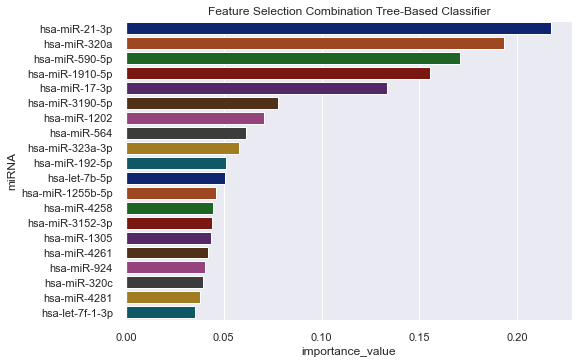

In [73]:
# Plots for Feature Selection

ax6 = sns.barplot(y="miRNA", x="importance_value", data=tbc_dataframe, palette=current_palette)
ax6.set_title("Feature Selection Combination Tree-Based Classifier")

#### Recursive Feature Elimination (RFE) with non-tree-based Classifiers

In [74]:
# Classifier Models for Recursive Feature Elemination
# (estimator is fitted recursive with "step=1" less Features
# and Features are ranked based on their contribution/importance)

#Initilizing non-tree-based Classifier Models
LG2 = LogisticRegression(random_state=seed)
SGDC2 = SGDClassifier(random_state=seed)   
    
# List of non-tree-based Classifiers used for Feature Selection
non_tree_clf = [LG2, SGDC2]

# List of non-tree-based Classifiers names
nt_name_clf = ["LG", "SGDC"]

In [75]:
# Create Dictionary for Feature Selection Results
results_nt_clf = {}

# Use funtion for RFE based feature selection
rfe_selection(results_nt_clf, non_tree_clf, nt_name_clf, X_train, y_train)

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Feature ranking:
1. Feature: hsa-miR-628-3p
2. Feature: hsa-miR-2909
3. Feature: hsa-miR-1305
4. Feature: hsa-miR-1293
5. Feature: hsa-miR-3065-3p
6. Feature: hsa-miR-130b-5p
7. Feature: hsa-miR-596
8. Feature: hsa-miR-3173-3p
9. Feature: hsa-miR-1256
10. Feature: hsa-miR-205-3p
11. Feature: hsa-miR-644a
12. Feature: hsa-miR-133a-3p
13. Feature: hsa-miR-30c-2-3p
14. Feature: hsa-miR-20a-5p
15. Feature: hsa-miR-638
16. Feature: hsa-miR-191-3p
17. Feature: hsa-miR-370-3p
18. Feature: hsa-miR-633
19. Feature: hsa-miR-145-3p
20. Feature: hsa-miR-548q
-------------------------------------------

{'LG': [('hsa-miR-628-3p', 1),
  ('hsa-miR-2909', 2),
  ('hsa-miR-1305', 3),
  ('hsa-miR-1293', 4),
  ('hsa-miR-3065-3p', 5),
  ('hsa-miR-130b-5p', 6),
  ('hsa-miR-596', 7),
  ('hsa-miR-3173-3p', 8),
  ('hsa-miR-1256', 9),
  ('hsa-miR-205-3p', 10),
  ('hsa-miR-644a', 11),
  ('hsa-miR-133a-3p', 12),
  ('hsa-miR-30c-2-3p', 13),
  ('hsa-miR-20a-5p', 14),
  ('hsa-miR-638', 15),
  ('hsa-miR-191-3p', 16),
  ('hsa-miR-370-3p', 17),
  ('hsa-miR-633', 18),
  ('hsa-miR-145-3p', 19),
  ('hsa-miR-548q', 20)],
 'SGDC': [('hsa-miR-4278', 1),
  ('hsa-miR-3679-5p', 2),
  ('hsa-miR-1914-5p', 3),
  ('hsa-miR-1193', 4),
  ('hsa-miR-3127-5p', 5),
  ('hsa-miR-1254', 6),
  ('hsa-miR-515-3p', 7),
  ('hsa-miR-3117-3p', 8),
  ('hsa-miR-1268a', 9),
  ('hsa-miR-142-5p', 10),
  ('hsa-miR-629-3p', 11),
  ('hsa-miR-2115-5p', 12),
  ('hsa-miR-181a-2-3p', 13),
  ('hsa-miR-3156-5p', 14),
  ('hsa-miR-3665', 15),
  ('hsa-miR-16-5p', 16),
  ('hsa-miR-22-3p', 17),
  ('hsa-miR-637', 18),
  ('hsa-miR-3174', 19),
  ('hsa-miR

#### TOP20 Feature Selection

##### TOP20 Features Decision Tree Classifier (DTC)

In [76]:
# use dataframe_selection function for creating new dataframe
X_dtc_top20 = dataframe_selection(results_fs["DTC"], X_train=X_train)

In [77]:
#Check new Dataframe again
print(X_dtc_top20.columns)
X_dtc_top20.shape

Index(['hsa-let-7b-5p', 'hsa-let-7g-5p', 'hsa-miR-1202', 'hsa-miR-181c-3p',
       'hsa-miR-1910-5p', 'hsa-miR-21-3p', 'hsa-miR-221-5p', 'hsa-miR-3122',
       'hsa-miR-320a', 'hsa-miR-323a-3p', 'hsa-miR-3615', 'hsa-miR-3677-3p',
       'hsa-miR-425-5p', 'hsa-miR-4275', 'hsa-miR-548f-3p', 'hsa-miR-564',
       'hsa-miR-590-5p', 'hsa-miR-744-3p', 'hsa-miR-924', 'hsa-miR-93-3p'],
      dtype='object')


(240, 20)

##### TOP20 Features  Random Forrest Classifier (RFC)

In [78]:
# use dataframe_selection function for creating new dataframe
X_rfc_top20 = dataframe_selection(results_fs["RFC"], X_train=X_train)

In [79]:
#Check new Dataframe again
print(X_rfc_top20.columns)
X_rfc_top20.shape

Index(['hsa-let-7f-1-3p', 'hsa-miR-101-5p', 'hsa-miR-1237-3p',
       'hsa-miR-149-5p', 'hsa-miR-152-3p', 'hsa-miR-19b-3p', 'hsa-miR-21-3p',
       'hsa-miR-3180-5p', 'hsa-miR-3190-5p', 'hsa-miR-320a', 'hsa-miR-320b',
       'hsa-miR-320c', 'hsa-miR-374a-5p', 'hsa-miR-423-5p', 'hsa-miR-4281',
       'hsa-miR-4310', 'hsa-miR-590-5p', 'hsa-miR-627-5p', 'hsa-miR-660-5p',
       'hsa-miR-7-5p'],
      dtype='object')


(240, 20)

##### TOP20 Features  Extra Tree Classifier (ETC)

In [80]:
# use dataframe_selection function for creating new dataframe
X_etc_top20 = dataframe_selection(results_fs["ETC"], X_train=X_train)

In [81]:
#Check new Dataframe again
print(X_etc_top20.columns)
X_etc_top20.shape

Index(['hsa-miR-101-5p', 'hsa-miR-1255b-5p', 'hsa-miR-1285-3p',
       'hsa-miR-130b-3p', 'hsa-miR-1539', 'hsa-miR-17-3p', 'hsa-miR-1825',
       'hsa-miR-21-3p', 'hsa-miR-215-5p', 'hsa-miR-320b', 'hsa-miR-3651',
       'hsa-miR-425-3p', 'hsa-miR-4310', 'hsa-miR-505-5p', 'hsa-miR-550a-5p',
       'hsa-miR-563', 'hsa-miR-564', 'hsa-miR-590-5p', 'hsa-miR-7-5p',
       'hsa-miR-92b-3p'],
      dtype='object')


(240, 20)

##### TOP20 Features Ada Boost Classifier (ABC)

In [82]:
# use dataframe_selection function for creating new dataframe
X_abc_top20 = dataframe_selection(results_fs["ABC"], X_train=X_train)

In [83]:
#Check new Dataframe again
print(X_abc_top20.columns)
X_abc_top20.shape

Index(['hsa-miR-1238-3p', 'hsa-miR-1255b-5p', 'hsa-miR-1305', 'hsa-miR-17-3p',
       'hsa-miR-18a-3p', 'hsa-miR-1910-5p', 'hsa-miR-192-5p', 'hsa-miR-21-3p',
       'hsa-miR-29b-1-5p', 'hsa-miR-3152-3p', 'hsa-miR-3200-5p',
       'hsa-miR-320a', 'hsa-miR-320d', 'hsa-miR-323a-3p', 'hsa-miR-324-5p',
       'hsa-miR-4258', 'hsa-miR-4261', 'hsa-miR-451a', 'hsa-miR-548b-5p',
       'hsa-miR-7-1-3p'],
      dtype='object')


(240, 20)

##### TOP20 Features  XG Boost Classifier (XGBC)

In [84]:
# use dataframe_selection function for creating new dataframe
X_xgbc_top20 = dataframe_selection(results_fs["XGBC"], X_train=X_train)

In [85]:
#Check new Dataframe again
print(X_xgbc_top20.columns)
X_xgbc_top20.shape

Index(['hsa-miR-101-5p', 'hsa-miR-1224-5p', 'hsa-miR-1260b', 'hsa-miR-1275',
       'hsa-miR-193a-5p', 'hsa-miR-30d-5p', 'hsa-miR-31-5p', 'hsa-miR-3190-5p',
       'hsa-miR-320c', 'hsa-miR-338-3p', 'hsa-miR-411-3p', 'hsa-miR-548m',
       'hsa-miR-548t-5p', 'hsa-miR-563', 'hsa-miR-627-5p', 'hsa-miR-654-3p',
       'hsa-miR-664a-3p', 'hsa-miR-7-5p', 'hsa-miR-744-3p', 'hsa-miR-924'],
      dtype='object')


(240, 20)

##### TOP20 Features Combination of tree-based Classifiers (TBC)

In [86]:
# use dataframe_selection function for creating new dataframe
X_tbc_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_train)

In [87]:
#Check new Dataframe again
print(X_tbc_top20.columns)
X_tbc_top20.shape

Index(['hsa-let-7b-5p', 'hsa-let-7f-1-3p', 'hsa-miR-1202', 'hsa-miR-1255b-5p',
       'hsa-miR-1305', 'hsa-miR-17-3p', 'hsa-miR-1910-5p', 'hsa-miR-192-5p',
       'hsa-miR-21-3p', 'hsa-miR-3152-3p', 'hsa-miR-3190-5p', 'hsa-miR-320a',
       'hsa-miR-320c', 'hsa-miR-323a-3p', 'hsa-miR-4258', 'hsa-miR-4261',
       'hsa-miR-4281', 'hsa-miR-564', 'hsa-miR-590-5p', 'hsa-miR-924'],
      dtype='object')


(240, 20)

##### TOP20 Features Logistic Regression Classifier (LGC)

In [88]:
# use dataframe_selection function for creating new dataframe
X_lgc_top20 = dataframe_selection(results_nt_clf["LG"], X_train=X_train)

In [89]:
#Check new Dataframe again
print(X_lgc_top20.columns)
X_lgc_top20.shape

Index(['hsa-miR-1256', 'hsa-miR-1293', 'hsa-miR-1305', 'hsa-miR-130b-5p',
       'hsa-miR-133a-3p', 'hsa-miR-145-3p', 'hsa-miR-191-3p', 'hsa-miR-205-3p',
       'hsa-miR-20a-5p', 'hsa-miR-2909', 'hsa-miR-3065-3p', 'hsa-miR-30c-2-3p',
       'hsa-miR-3173-3p', 'hsa-miR-370-3p', 'hsa-miR-548q', 'hsa-miR-596',
       'hsa-miR-628-3p', 'hsa-miR-633', 'hsa-miR-638', 'hsa-miR-644a'],
      dtype='object')


(240, 20)

##### TOP20 Features SGD Classifer (SGDC)

In [90]:
# use dataframe_selection function for creating new dataframe
X_sgdc_top20 = dataframe_selection(results_nt_clf["SGDC"], X_train=X_train)

In [91]:
#Check new Dataframe again
print(X_sgdc_top20.columns)
X_sgdc_top20.shape

Index(['hsa-miR-1193', 'hsa-miR-1254', 'hsa-miR-1268a', 'hsa-miR-142-5p',
       'hsa-miR-16-5p', 'hsa-miR-181a-2-3p', 'hsa-miR-1914-5p',
       'hsa-miR-2115-5p', 'hsa-miR-22-3p', 'hsa-miR-3117-3p',
       'hsa-miR-3127-5p', 'hsa-miR-3156-5p', 'hsa-miR-3174', 'hsa-miR-3665',
       'hsa-miR-3679-5p', 'hsa-miR-4278', 'hsa-miR-455-3p', 'hsa-miR-515-3p',
       'hsa-miR-629-3p', 'hsa-miR-637'],
      dtype='object')


(240, 20)

### Model Selection

#### Evaluation of different Classifier Models

In [92]:
# Initialize Classifier Models
DC = DummyClassifier(random_state=seed) # The Dummy Classifier is used as Baseline Model
LG = LogisticRegression(random_state=seed)
SGDC1 = SGDClassifier(random_state=seed, loss='modified_huber')
KNN1 = KNeighborsClassifier()
GNB = GaussianNB()
SVC1 = SVC(random_state=seed, probability=True)
DTC1 = DecisionTreeClassifier(random_state=seed)
RFC1 = RandomForestClassifier(random_state=seed) 
ETC1 = ExtraTreesClassifier(random_state=seed)
ABC1 = AdaBoostClassifier(random_state=seed)
XGBC1 = XGBClassifier(random_state=seed)

# List for models to be evaluated
model_clf = [DC, LG, SGDC1, KNN1, GNB, SVC1, DTC1, RFC1, ETC1, ABC1, XGBC1]

# List for model names
name_model = ["DC", "LG", "SGDC", "KNN", "GNB", "SVC", "DTC", "RFC", "ETC", "ABC", "XGBC"]

#### without Feature Selection

In [93]:
# Create Dictionary for Evaluation results
results_all = {}

# Use model_evaluation function with complete Dataset (X_train = all Features, y_train)
model_evaluation(results_all, model_clf, name_model, X_train, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.8833333333333334, 'Roc_AUC': 0.9561162717265954, 'Precision': 0.885947753370354, 'F1': 0.8842169798685209}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validatio

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8833333333333334,
  'Roc_AUC': 0.9561162717265954,
  'Precision': 0.885947753370354,
  'F1': 0.8842169798685209},
 'SGDC': {'Accuracy': 0.7916666666666667,
  'Roc_AUC': 0.8951038645201754,
  'Precision': 0.8001151571739807,
  'F1': 0.7917264796462598},
 'KNN': {'Accuracy': 0.7333333333333334,
  'Roc_AUC': 0.8901192664209298,
  'Precision': 0.7404431112403248,
  'F1': 0.7242997464285118},
 'GNB': {'Accuracy': 0.4916666666666667,
  'Roc_AUC': 0.7235881780094057,
  'Precision': 0.5765394790125973,
  'F1': 0.4650736893929662},
 'SVC': {'Accuracy': 0.775,
  'Roc_AUC': 0.908813376391205,
  'Precision': 0.7892067836417682,
  'F1': 0.7775500106014288},
 'DTC': {'Accuracy': 0.7208333333333334,
  'Roc_AUC': 0.7908949392725485,
  'Precision': 0.7253861878861879,
  'F1': 0.7192830657737744},
 'RFC': {'Accuracy': 0.7916666666666666,
  'Roc_AUC': 0.92327

In [94]:
#check results Dictionary
results_all

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8833333333333334,
  'Roc_AUC': 0.9561162717265954,
  'Precision': 0.885947753370354,
  'F1': 0.8842169798685209},
 'SGDC': {'Accuracy': 0.7916666666666667,
  'Roc_AUC': 0.8951038645201754,
  'Precision': 0.8001151571739807,
  'F1': 0.7917264796462598},
 'KNN': {'Accuracy': 0.7333333333333334,
  'Roc_AUC': 0.8901192664209298,
  'Precision': 0.7404431112403248,
  'F1': 0.7242997464285118},
 'GNB': {'Accuracy': 0.4916666666666667,
  'Roc_AUC': 0.7235881780094057,
  'Precision': 0.5765394790125973,
  'F1': 0.4650736893929662},
 'SVC': {'Accuracy': 0.775,
  'Roc_AUC': 0.908813376391205,
  'Precision': 0.7892067836417682,
  'F1': 0.7775500106014288},
 'DTC': {'Accuracy': 0.7208333333333334,
  'Roc_AUC': 0.7908949392725485,
  'Precision': 0.7253861878861879,
  'F1': 0.7192830657737744},
 'RFC': {'Accuracy': 0.7916666666666666,
  'Roc_AUC': 0.92327

##### Visualisation Model Selection

In [95]:
# Create Dataframe from Crossvalidation Results
cv_dataframe = pd.DataFrame(results_all).T
cv_dataframe

,Accuracy,Roc_AUC,Precision,F1
DC,0.312500,0.484510,0.311852,0.310899
LG,0.883333,0.956116,0.885948,0.884217
SGDC,0.791667,0.895104,0.800115,0.791726
KNN,0.733333,0.890119,0.740443,0.724300
GNB,0.491667,0.723588,0.576539,0.465074
SVC,0.775000,0.908813,0.789207,0.777550
DTC,0.720833,0.790895,0.725386,0.719283
RFC,0.791667,0.923277,0.794577,0.792619
ETC,0.795833,0.927515,0.795441,0.795604
ABC,0.683333,0.849254,0.736695,0.692196


In [96]:
cv_dataframe.describe()

#XGBC seems to be the best model without Feature Selection overall

,Accuracy,Roc_AUC,Precision,F1
count,11.000000,11.000000,11.000000,11.000000
mean,0.709091,0.844339,0.725704,0.706660
std,0.165620,0.137944,0.157761,0.169576
min,0.312500,0.484510,0.311852,0.310899
25%,0.702083,0.820074,0.731041,0.705739
50%,0.775000,0.895104,0.789207,0.777550
75%,0.793750,0.925396,0.797778,0.794112
max,0.883333,0.956116,0.885948,0.884217


In [97]:
# Plots for Model Selection

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(100, 200),)
ax1.set_title("Model Selection Accuracy")
ax2.set_title("Model Selection Roc_AUC")
ax3.set_title("Model Selection Precision")
ax4.set_title("Model Selection F1")

#sns.set(font_scale=10) Problem is that it sets font scale globally which destroys other plots
sns.barplot(y=cv_dataframe.Accuracy, x=cv_dataframe.index, ax=ax1)
sns.barplot(y=cv_dataframe.Roc_AUC, x=cv_dataframe.index, ax=ax2)
sns.barplot(y=cv_dataframe.Precision, x=cv_dataframe.index, ax=ax3)
sns.barplot(y=cv_dataframe.F1, x=cv_dataframe.index, ax=ax4)


#### with Feature Selection

##### TOP20 Features Decision Tree Classifier (DTC)

In [98]:
# Create Dictionary for Evaluation results
results_dtc_top20 = {}

# Use model_evaluation function with TOP20 DTC Features Dataset (X_dtc_top20, y_train)
model_evaluation(results_dtc_top20, model_clf, name_model, X_dtc_top20, y_train)

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}
--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.8, 'Roc_AUC': 0.9065430203694653, 'Precision': 0.8165860478244378, 'F1': 0.7981708785881653}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8,
  'Roc_AUC': 0.9065430203694653,
  'Precision': 0.8165860478244378,
  'F1': 0.7981708785881653},
 'SGDC': {'Accuracy': 0.675,
  'Roc_AUC': 0.8281703017584926,
  'Precision': 0.6998692165152434,
  'F1': 0.6704567020808649},
 'KNN': {'Accuracy': 0.7166666666666667,
  'Roc_AUC': 0.871696626837237,
  'Precision': 0.718601810985712,
  'F1': 0.7071862388271056},
 'GNB': {'Accuracy': 0.5791666666666667,
  'Roc_AUC': 0.7944672480191436,
  'Precision': 0.5919837529620139,
  'F1': 0.5679958353191543},
 'SVC': {'Accuracy': 0.7625,
  'Roc_AUC': 0.9080849769037626,
  'Precision': 0.7786902771826718,
  'F1': 0.7617107398924052},
 'DTC': {'Accuracy': 0.8041666666666668,
  'Roc_AUC': 0.8523255643084864,
  'Precision': 0.8092236830936521,
  'F1': 0.8034523112729289},
 'RFC': {'Accuracy': 0.8291666666666668,
  'Roc_AUC': 0.9401432176864312,
  'Precision':

In [99]:
#check results Dictionary
results_dtc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8,
  'Roc_AUC': 0.9065430203694653,
  'Precision': 0.8165860478244378,
  'F1': 0.7981708785881653},
 'SGDC': {'Accuracy': 0.675,
  'Roc_AUC': 0.8281703017584926,
  'Precision': 0.6998692165152434,
  'F1': 0.6704567020808649},
 'KNN': {'Accuracy': 0.7166666666666667,
  'Roc_AUC': 0.871696626837237,
  'Precision': 0.718601810985712,
  'F1': 0.7071862388271056},
 'GNB': {'Accuracy': 0.5791666666666667,
  'Roc_AUC': 0.7944672480191436,
  'Precision': 0.5919837529620139,
  'F1': 0.5679958353191543},
 'SVC': {'Accuracy': 0.7625,
  'Roc_AUC': 0.9080849769037626,
  'Precision': 0.7786902771826718,
  'F1': 0.7617107398924052},
 'DTC': {'Accuracy': 0.8041666666666668,
  'Roc_AUC': 0.8523255643084864,
  'Precision': 0.8092236830936521,
  'F1': 0.8034523112729289},
 'RFC': {'Accuracy': 0.8291666666666668,
  'Roc_AUC': 0.9401432176864312,
  'Precision':

##### TOP20 Features Random Forrest Classifier (RFC)

In [100]:
# Create Dictionary for Evaluation results
results_rfc_top20 = {}

# Use model_evaluation function with TOP20 RFC Features Dataset (X_rfc_top20, y_train)
model_evaluation(results_rfc_top20, model_clf, name_model, X_rfc_top20, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}
--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.8, 'Roc_AUC': 0.9278366480933092, 'Precision': 0.8051852009359749, 'F1': 0.7976014031575182}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Scores:
{'Accuracy': 0.7458333333333333, 'Roc_AUC': 0.8503149843063514, 'Precision': 0.7554993916758622, 'F1': 0.740075692773737}
--------------------------------------------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Scores:
{'Accuracy': 0.75, 'Roc_AUC': 0.8840608818691076, 'Precision': 0.7526743317455391, 

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8,
  'Roc_AUC': 0.9278366480933092,
  'Precision': 0.8051852009359749,
  'F1': 0.7976014031575182},
 'SGDC': {'Accuracy': 0.7458333333333333,
  'Roc_AUC': 0.8503149843063514,
  'Precision': 0.7554993916758622,
  'F1': 0.740075692773737},
 'KNN': {'Accuracy': 0.75,
  'Roc_AUC': 0.8840608818691076,
  'Precision': 0.7526743317455391,
  'F1': 0.7439200016578476},
 'GNB': {'Accuracy': 0.6708333333333334,
  'Roc_AUC': 0.8182506263882765,
  'Precision': 0.7005432423518079,
  'F1': 0.6708552613586813},
 'SVC': {'Accuracy': 0.7416666666666667,
  'Roc_AUC': 0.9073398728415825,
  'Precision': 0.7674687632056053,
  'F1': 0.7408941558568182},
 'DTC': {'Accuracy': 0.7041666666666666,
  'Roc_AUC': 0.7786121173787208,
  'Precision': 0.7172614133372648,
  'F1': 0.7039609479873825},
 'RFC': {'Accuracy': 0.8041666666666666,
  'Roc_AUC': 0.9181759162592348,
  

In [101]:
#check results Dictionary
results_rfc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8,
  'Roc_AUC': 0.9278366480933092,
  'Precision': 0.8051852009359749,
  'F1': 0.7976014031575182},
 'SGDC': {'Accuracy': 0.7458333333333333,
  'Roc_AUC': 0.8503149843063514,
  'Precision': 0.7554993916758622,
  'F1': 0.740075692773737},
 'KNN': {'Accuracy': 0.75,
  'Roc_AUC': 0.8840608818691076,
  'Precision': 0.7526743317455391,
  'F1': 0.7439200016578476},
 'GNB': {'Accuracy': 0.6708333333333334,
  'Roc_AUC': 0.8182506263882765,
  'Precision': 0.7005432423518079,
  'F1': 0.6708552613586813},
 'SVC': {'Accuracy': 0.7416666666666667,
  'Roc_AUC': 0.9073398728415825,
  'Precision': 0.7674687632056053,
  'F1': 0.7408941558568182},
 'DTC': {'Accuracy': 0.7041666666666666,
  'Roc_AUC': 0.7786121173787208,
  'Precision': 0.7172614133372648,
  'F1': 0.7039609479873825},
 'RFC': {'Accuracy': 0.8041666666666666,
  'Roc_AUC': 0.9181759162592348,
  

##### TOP20 Features Extra Tree Classifier (ETC)

In [102]:
# Create Dictionary for Evaluation results
results_etc_top20 = {}

# Use model_evaluation function with TOP20 ETC Features Dataset (X_etc_top20, y_train)
model_evaluation(results_etc_top20, model_clf, name_model, X_etc_top20, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.8333333333333334, 'Roc_AUC': 0.9397344874397572, 'Precision': 0.8359488496253202, 'F1': 0.83313631550645}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8333333333333334,
  'Roc_AUC': 0.9397344874397572,
  'Precision': 0.8359488496253202,
  'F1': 0.83313631550645},
 'SGDC': {'Accuracy': 0.7958333333333334,
  'Roc_AUC': 0.8738764987198039,
  'Precision': 0.8029378573496221,
  'F1': 0.7933024331517756},
 'KNN': {'Accuracy': 0.7791666666666666,
  'Roc_AUC': 0.9067957092569433,
  'Precision': 0.7988560353562373,
  'F1': 0.7661158957753385},
 'GNB': {'Accuracy': 0.7041666666666667,
  'Roc_AUC': 0.8410141160977261,
  'Precision': 0.7236233798806151,
  'F1': 0.7059916716519151},
 'SVC': {'Accuracy': 0.8,
  'Roc_AUC': 0.9450240431073864,
  'Precision': 0.8063519323813442,
  'F1': 0.7994179248467783},
 'DTC': {'Accuracy': 0.725,
  'Roc_AUC': 0.7936463504430772,
  'Precision': 0.7258474371632266,
  'F1': 0.7176292680575218},
 'RFC': {'Accuracy': 0.8125,
  'Roc_AUC': 0.9244083589858366,
  'Precision':

In [103]:
#check results Dictionary
results_etc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.8333333333333334,
  'Roc_AUC': 0.9397344874397572,
  'Precision': 0.8359488496253202,
  'F1': 0.83313631550645},
 'SGDC': {'Accuracy': 0.7958333333333334,
  'Roc_AUC': 0.8738764987198039,
  'Precision': 0.8029378573496221,
  'F1': 0.7933024331517756},
 'KNN': {'Accuracy': 0.7791666666666666,
  'Roc_AUC': 0.9067957092569433,
  'Precision': 0.7988560353562373,
  'F1': 0.7661158957753385},
 'GNB': {'Accuracy': 0.7041666666666667,
  'Roc_AUC': 0.8410141160977261,
  'Precision': 0.7236233798806151,
  'F1': 0.7059916716519151},
 'SVC': {'Accuracy': 0.8,
  'Roc_AUC': 0.9450240431073864,
  'Precision': 0.8063519323813442,
  'F1': 0.7994179248467783},
 'DTC': {'Accuracy': 0.725,
  'Roc_AUC': 0.7936463504430772,
  'Precision': 0.7258474371632266,
  'F1': 0.7176292680575218},
 'RFC': {'Accuracy': 0.8125,
  'Roc_AUC': 0.9244083589858366,
  'Precision':

##### TOP20 Features Ada Boost Classifier (ABC)

In [104]:
# Create Dictionary for Evaluation results
results_abc_top20 = {}

# Use model_evaluation function with TOP20 ABC Features Dataset (X_abc_top20, y_train)
model_evaluation(results_abc_top20, model_clf, name_model, X_abc_top20, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.7583333333333333, 'Roc_AUC': 0.904578728926946, 'Precision': 0.7607141786089154, 'F1': 0.7560418575336452}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validatio

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.7583333333333333,
  'Roc_AUC': 0.904578728926946,
  'Precision': 0.7607141786089154,
  'F1': 0.7560418575336452},
 'SGDC': {'Accuracy': 0.7625,
  'Roc_AUC': 0.8673505216752172,
  'Precision': 0.763407733763771,
  'F1': 0.7525870810473798},
 'KNN': {'Accuracy': 0.75,
  'Roc_AUC': 0.9109726855079628,
  'Precision': 0.752911713043292,
  'F1': 0.7359288463026632},
 'GNB': {'Accuracy': 0.675,
  'Roc_AUC': 0.8597191030921166,
  'Precision': 0.6897760443890475,
  'F1': 0.6720499862389543},
 'SVC': {'Accuracy': 0.8083333333333332,
  'Roc_AUC': 0.9294800147066811,
  'Precision': 0.8225517972129225,
  'F1': 0.8096944402367241},
 'DTC': {'Accuracy': 0.6791666666666666,
  'Roc_AUC': 0.758503320683112,
  'Precision': 0.6910697690109455,
  'F1': 0.6776555985537642},
 'RFC': {'Accuracy': 0.8083333333333332,
  'Roc_AUC': 0.9370048511149871,
  'Precision': 

In [105]:
#check results Dictionary
results_abc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.7583333333333333,
  'Roc_AUC': 0.904578728926946,
  'Precision': 0.7607141786089154,
  'F1': 0.7560418575336452},
 'SGDC': {'Accuracy': 0.7625,
  'Roc_AUC': 0.8673505216752172,
  'Precision': 0.763407733763771,
  'F1': 0.7525870810473798},
 'KNN': {'Accuracy': 0.75,
  'Roc_AUC': 0.9109726855079628,
  'Precision': 0.752911713043292,
  'F1': 0.7359288463026632},
 'GNB': {'Accuracy': 0.675,
  'Roc_AUC': 0.8597191030921166,
  'Precision': 0.6897760443890475,
  'F1': 0.6720499862389543},
 'SVC': {'Accuracy': 0.8083333333333332,
  'Roc_AUC': 0.9294800147066811,
  'Precision': 0.8225517972129225,
  'F1': 0.8096944402367241},
 'DTC': {'Accuracy': 0.6791666666666666,
  'Roc_AUC': 0.758503320683112,
  'Precision': 0.6910697690109455,
  'F1': 0.6776555985537642},
 'RFC': {'Accuracy': 0.8083333333333332,
  'Roc_AUC': 0.9370048511149871,
  'Precision': 

##### TOP20 Features XG Boost Classifier (XGBC)

In [106]:
# Create Dictionary for Evaluation results
results_xgbc_top20 = {}

# Use model_evaluation function with TOP20 XGBC Features Dataset (X_xgbc_tree_top20, y_train)
model_evaluation(results_xgbc_top20, model_clf, name_model, X_xgbc_top20, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.7791666666666667, 'Roc_AUC': 0.8980118087034693, 'Precision': 0.7887346857935092, 'F1': 0.7780606817192302}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validati

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.7791666666666667,
  'Roc_AUC': 0.8980118087034693,
  'Precision': 0.7887346857935092,
  'F1': 0.7780606817192302},
 'SGDC': {'Accuracy': 0.7125,
  'Roc_AUC': 0.8287238439469276,
  'Precision': 0.7247646797646797,
  'F1': 0.705257693321974},
 'KNN': {'Accuracy': 0.7333333333333333,
  'Roc_AUC': 0.8841289322136344,
  'Precision': 0.7348276706094043,
  'F1': 0.7279341444404913},
 'GNB': {'Accuracy': 0.5958333333333334,
  'Roc_AUC': 0.8152131445503421,
  'Precision': 0.6192241194191659,
  'F1': 0.5856332087340833},
 'SVC': {'Accuracy': 0.725,
  'Roc_AUC': 0.9099276736836529,
  'Precision': 0.7505216567058672,
  'F1': 0.7280602786164522},
 'DTC': {'Accuracy': 0.6791666666666667,
  'Roc_AUC': 0.7598757658814586,
  'Precision': 0.686449938949939,
  'F1': 0.6774588664294546},
 'RFC': {'Accuracy': 0.7833333333333333,
  'Roc_AUC': 0.9264971680588033,

In [107]:
#check results Dictionary
results_xgbc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.7791666666666667,
  'Roc_AUC': 0.8980118087034693,
  'Precision': 0.7887346857935092,
  'F1': 0.7780606817192302},
 'SGDC': {'Accuracy': 0.7125,
  'Roc_AUC': 0.8287238439469276,
  'Precision': 0.7247646797646797,
  'F1': 0.705257693321974},
 'KNN': {'Accuracy': 0.7333333333333333,
  'Roc_AUC': 0.8841289322136344,
  'Precision': 0.7348276706094043,
  'F1': 0.7279341444404913},
 'GNB': {'Accuracy': 0.5958333333333334,
  'Roc_AUC': 0.8152131445503421,
  'Precision': 0.6192241194191659,
  'F1': 0.5856332087340833},
 'SVC': {'Accuracy': 0.725,
  'Roc_AUC': 0.9099276736836529,
  'Precision': 0.7505216567058672,
  'F1': 0.7280602786164522},
 'DTC': {'Accuracy': 0.6791666666666667,
  'Roc_AUC': 0.7598757658814586,
  'Precision': 0.686449938949939,
  'F1': 0.6774588664294546},
 'RFC': {'Accuracy': 0.7833333333333333,
  'Roc_AUC': 0.9264971680588033,

##### TOP20 Features Combination of tree-based Classifiers (TBC)

In [108]:
# Create Dictionary for Evaluation results
results_tbc_top20 = {}

# Use model_evaluation function with TOP20 TBC Features Dataset (X_tbc_top20, y_train)
model_evaluation(results_tbc_top20, model_clf, name_model, X_tbc_top20, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.7958333333333334, 'Roc_AUC': 0.9216701167270427, 'Precision': 0.7940581846773797, 'F1': 0.7916295495533319}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validati

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.7958333333333334,
  'Roc_AUC': 0.9216701167270427,
  'Precision': 0.7940581846773797,
  'F1': 0.7916295495533319},
 'SGDC': {'Accuracy': 0.7541666666666667,
  'Roc_AUC': 0.8559024055020211,
  'Precision': 0.7600696482117266,
  'F1': 0.7493672435376065},
 'KNN': {'Accuracy': 0.7458333333333333,
  'Roc_AUC': 0.9012232063778998,
  'Precision': 0.7524646583779709,
  'F1': 0.7294787177151908},
 'GNB': {'Accuracy': 0.6916666666666667,
  'Roc_AUC': 0.85336796338091,
  'Precision': 0.6974370804633961,
  'F1': 0.6831985979595552},
 'SVC': {'Accuracy': 0.8041666666666666,
  'Roc_AUC': 0.9314492151977822,
  'Precision': 0.8071789842997272,
  'F1': 0.8019013897447997},
 'DTC': {'Accuracy': 0.7208333333333333,
  'Roc_AUC': 0.7904549327877127,
  'Precision': 0.7224541967034226,
  'F1': 0.719770734250712},
 'RFC': {'Accuracy': 0.85,
  'Roc_AUC': 0.9496629

In [109]:
#check results Dictionary
results_tbc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.7958333333333334,
  'Roc_AUC': 0.9216701167270427,
  'Precision': 0.7940581846773797,
  'F1': 0.7916295495533319},
 'SGDC': {'Accuracy': 0.7541666666666667,
  'Roc_AUC': 0.8559024055020211,
  'Precision': 0.7600696482117266,
  'F1': 0.7493672435376065},
 'KNN': {'Accuracy': 0.7458333333333333,
  'Roc_AUC': 0.9012232063778998,
  'Precision': 0.7524646583779709,
  'F1': 0.7294787177151908},
 'GNB': {'Accuracy': 0.6916666666666667,
  'Roc_AUC': 0.85336796338091,
  'Precision': 0.6974370804633961,
  'F1': 0.6831985979595552},
 'SVC': {'Accuracy': 0.8041666666666666,
  'Roc_AUC': 0.9314492151977822,
  'Precision': 0.8071789842997272,
  'F1': 0.8019013897447997},
 'DTC': {'Accuracy': 0.7208333333333333,
  'Roc_AUC': 0.7904549327877127,
  'Precision': 0.7224541967034226,
  'F1': 0.719770734250712},
 'RFC': {'Accuracy': 0.85,
  'Roc_AUC': 0.9496629

##### TOP20 Features Logistic Regression Classifier (LGC)

In [110]:
# Create Dictionary for Evaluation results
results_lgc_top20 = {}

# Use model_evaluation function with TOP20 LGC Features Dataset (X_lgc_top20, y_train)
model_evaluation(results_lgc_top20, model_clf, name_model, X_lgc_top20, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.6625, 'Roc_AUC': 0.8288594236163022, 'Precision': 0.6571897755953484, 'F1': 0.6546502209895402}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.6625,
  'Roc_AUC': 0.8288594236163022,
  'Precision': 0.6571897755953484,
  'F1': 0.6546502209895402},
 'SGDC': {'Accuracy': 0.6208333333333333,
  'Roc_AUC': 0.7612075494994485,
  'Precision': 0.6323209291344302,
  'F1': 0.6078792910237762},
 'KNN': {'Accuracy': 0.6708333333333334,
  'Roc_AUC': 0.8492540904079536,
  'Precision': 0.6819351351549494,
  'F1': 0.6615920301565714},
 'GNB': {'Accuracy': 0.4458333333333334,
  'Roc_AUC': 0.727972538727327,
  'Precision': 0.5357069670431739,
  'F1': 0.4181906504696931},
 'SVC': {'Accuracy': 0.6666666666666666,
  'Roc_AUC': 0.8307235586547532,
  'Precision': 0.6780509236156026,
  'F1': 0.6650066361929217},
 'DTC': {'Accuracy': 0.6875,
  'Roc_AUC': 0.7659429246609039,
  'Precision': 0.6860084033613446,
  'F1': 0.6852998152666084},
 'RFC': {'Accuracy': 0.7041666666666667,
  'Roc_AUC': 0.873636837570438

In [111]:
#check results Dictionary
results_lgc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.6625,
  'Roc_AUC': 0.8288594236163022,
  'Precision': 0.6571897755953484,
  'F1': 0.6546502209895402},
 'SGDC': {'Accuracy': 0.6208333333333333,
  'Roc_AUC': 0.7612075494994485,
  'Precision': 0.6323209291344302,
  'F1': 0.6078792910237762},
 'KNN': {'Accuracy': 0.6708333333333334,
  'Roc_AUC': 0.8492540904079536,
  'Precision': 0.6819351351549494,
  'F1': 0.6615920301565714},
 'GNB': {'Accuracy': 0.4458333333333334,
  'Roc_AUC': 0.727972538727327,
  'Precision': 0.5357069670431739,
  'F1': 0.4181906504696931},
 'SVC': {'Accuracy': 0.6666666666666666,
  'Roc_AUC': 0.8307235586547532,
  'Precision': 0.6780509236156026,
  'F1': 0.6650066361929217},
 'DTC': {'Accuracy': 0.6875,
  'Roc_AUC': 0.7659429246609039,
  'Precision': 0.6860084033613446,
  'F1': 0.6852998152666084},
 'RFC': {'Accuracy': 0.7041666666666667,
  'Roc_AUC': 0.873636837570438

##### TOP20 Features SGD Classifier (SGDC)

In [112]:
# Create Dictionary for Evaluation results
results_sgdc_top20 = {}

# Use model_evaluation function with TOP20 SGDC Features Dataset (X_sgdc_top20, y_train)
model_evaluation(results_sgdc_top20, model_clf, name_model, X_sgdc_top20, y_train)

--------------------------------------------------------------------------------
DummyClassifier(constant=None, random_state=1, strategy='warn')
Scores:
{'Accuracy': 0.3125, 'Roc_AUC': 0.48450962423092403, 'Precision': 0.3118518518518519, 'F1': 0.3108986928104575}


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs

--------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Scores:
{'Accuracy': 0.6499999999999999, 'Roc_AUC': 0.8157976702309304, 'Precision': 0.6369240672804409, 'F1': 0.6296142591183643}
--------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validati

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.6499999999999999,
  'Roc_AUC': 0.8157976702309304,
  'Precision': 0.6369240672804409,
  'F1': 0.6296142591183643},
 'SGDC': {'Accuracy': 0.6249999999999999,
  'Roc_AUC': 0.7467115469840457,
  'Precision': 0.6338243284138425,
  'F1': 0.6065950792026291},
 'KNN': {'Accuracy': 0.6458333333333333,
  'Roc_AUC': 0.8180489097469797,
  'Precision': 0.6472632089272956,
  'F1': 0.6414996019455222},
 'GNB': {'Accuracy': 0.5208333333333333,
  'Roc_AUC': 0.7472186565275888,
  'Precision': 0.5967807247804086,
  'F1': 0.49820621994435355},
 'SVC': {'Accuracy': 0.675,
  'Roc_AUC': 0.8639856830813406,
  'Precision': 0.6785200245803961,
  'F1': 0.6724311504483919},
 'DTC': {'Accuracy': 0.6333333333333333,
  'Roc_AUC': 0.7235014439141574,
  'Precision': 0.6480669308904604,
  'F1': 0.6311646993727547},
 'RFC': {'Accuracy': 0.7333333333333332,
  'Roc_AUC': 0.86

In [113]:
results_sgdc_top20

{'DC': {'Accuracy': 0.3125,
  'Roc_AUC': 0.48450962423092403,
  'Precision': 0.3118518518518519,
  'F1': 0.3108986928104575},
 'LG': {'Accuracy': 0.6499999999999999,
  'Roc_AUC': 0.8157976702309304,
  'Precision': 0.6369240672804409,
  'F1': 0.6296142591183643},
 'SGDC': {'Accuracy': 0.6249999999999999,
  'Roc_AUC': 0.7467115469840457,
  'Precision': 0.6338243284138425,
  'F1': 0.6065950792026291},
 'KNN': {'Accuracy': 0.6458333333333333,
  'Roc_AUC': 0.8180489097469797,
  'Precision': 0.6472632089272956,
  'F1': 0.6414996019455222},
 'GNB': {'Accuracy': 0.5208333333333333,
  'Roc_AUC': 0.7472186565275888,
  'Precision': 0.5967807247804086,
  'F1': 0.49820621994435355},
 'SVC': {'Accuracy': 0.675,
  'Roc_AUC': 0.8639856830813406,
  'Precision': 0.6785200245803961,
  'F1': 0.6724311504483919},
 'DTC': {'Accuracy': 0.6333333333333333,
  'Roc_AUC': 0.7235014439141574,
  'Precision': 0.6480669308904604,
  'F1': 0.6311646993727547},
 'RFC': {'Accuracy': 0.7333333333333332,
  'Roc_AUC': 0.86

##### Visualisation Model Selection with TOP20 Features

In [114]:
#create Lists with Labels for Plotting
labels_TOP20 = ["ALL", 
              "TOP20 DTC", 
              "TOP20 RFC", 
              "TOP20 ETC", 
              "TOP20 ABC", 
              "TOP20 XGBC", 
              "TOP20 TBC",
              "TOP20 LGC", 
              "TOP20 SGDC",
             ]

labels_model = name_model

###### Precision

In [115]:
#Create Dataframe with all Results for Precision
results_precision = pd.DataFrame()

#Enter Results
results_precision["ALL"] = pd.DataFrame(results_all).T.Precision
results_precision["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.Precision
results_precision["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.Precision
results_precision["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.Precision
results_precision["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.Precision
results_precision["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.Precision
results_precision["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.Precision
results_precision["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.Precision
results_precision["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.Precision

results_precision

,ALL,TOP20 DTC,TOP20 RFC,TOP20 ETC,TOP20 ABC,TOP20 XGBC,TOP20 TBC,TOP20 LGC,TOP20 SGDC
DC,0.311852,0.311852,0.311852,0.311852,0.311852,0.311852,0.311852,0.311852,0.311852
LG,0.885948,0.816586,0.805185,0.835949,0.760714,0.788735,0.794058,0.657190,0.636924
SGDC,0.800115,0.699869,0.755499,0.802938,0.763408,0.724765,0.760070,0.632321,0.633824
KNN,0.740443,0.718602,0.752674,0.798856,0.752912,0.734828,0.752465,0.681935,0.647263
GNB,0.576539,0.591984,0.700543,0.723623,0.689776,0.619224,0.697437,0.535707,0.596781
SVC,0.789207,0.778690,0.767469,0.806352,0.822552,0.750522,0.807179,0.678051,0.678520
DTC,0.725386,0.809224,0.717261,0.725847,0.691070,0.686450,0.722454,0.686008,0.648067
RFC,0.794577,0.832794,0.810872,0.811607,0.805619,0.785826,0.853577,0.710395,0.738774
ETC,0.795441,0.805453,0.785641,0.838065,0.824141,0.815874,0.852167,0.700655,0.702117
ABC,0.736695,0.716183,0.722896,0.751868,0.744959,0.683748,0.740508,0.639253,0.575402


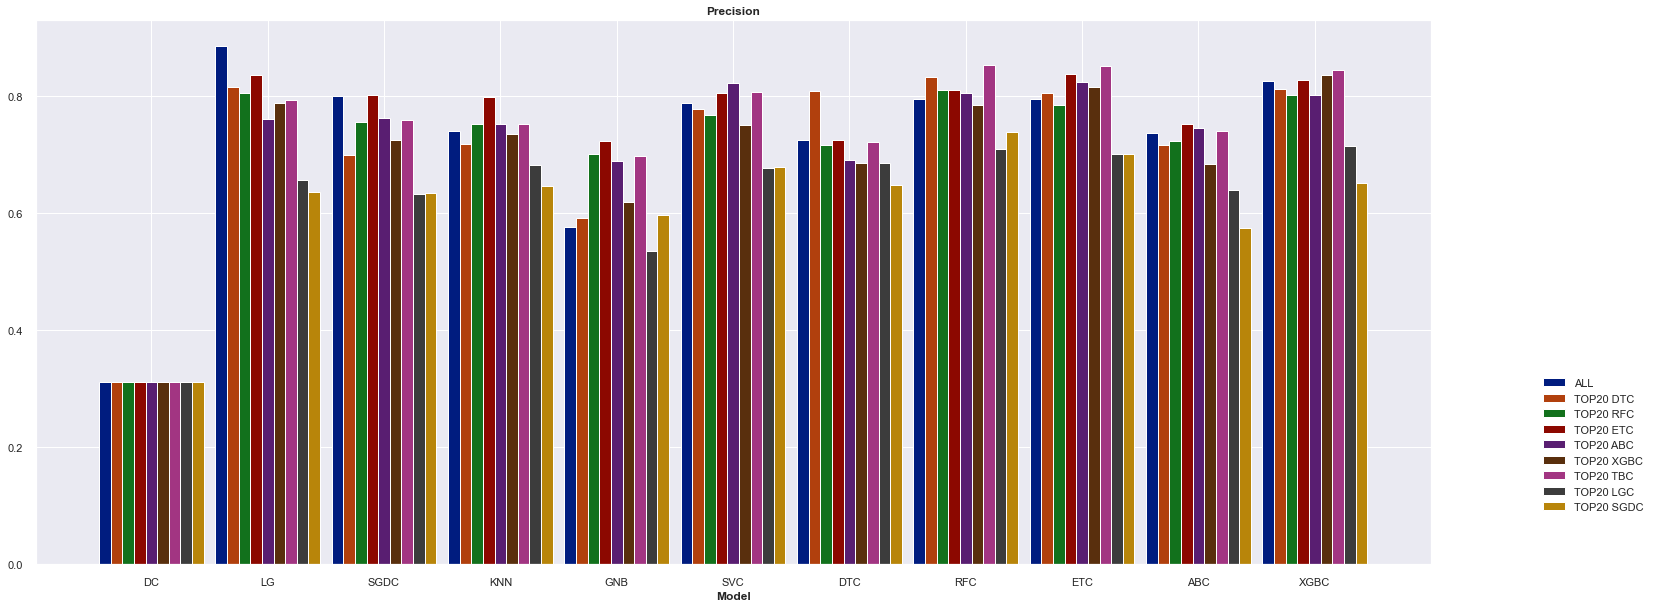

In [116]:
# set height of bars for precision
bars_heights_precision = [results_precision["ALL"]
                            , results_precision["TOP20 DTC"]
                            , results_precision["TOP20 RFC"]
                            , results_precision["TOP20 ETC"]
                            , results_precision["TOP20 ABC"]
                            , results_precision["TOP20 XGBC"]
                            , results_precision["TOP20 TBC"]
                            , results_precision["TOP20 LGC"]
                            , results_precision["TOP20 SGDC"]
                         ]

# use multibar_plot function to plot
multibar_plot(bars_heights_precision, labels_TOP20, name=labels_model, title="Precision", xlb="Model")

In [117]:
# get the 3 (default n=3) best model + feature selection combinations for Precision using top_model function
top_model(results_precision, n=4)

TOP: 1
Value: 0.885947753370354
Model: LG
Feature Selection: ALL
-----------------------------------------------------------------
TOP: 2
Value: 0.8535768751945222
Model: RFC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 3
Value: 0.8521669481189604
Model: ETC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 4
Value: 0.8450581109636837
Model: XGBC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------


###### Accuracy

In [118]:
#Create Dataframe with all Results for Accuracy
results_accuracy = pd.DataFrame()

#Enter Results
results_accuracy["ALL"] = pd.DataFrame(results_all).T.Accuracy
results_accuracy["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.Accuracy
results_accuracy["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.Accuracy
results_accuracy["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.Accuracy
results_accuracy["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.Accuracy
results_accuracy["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.Accuracy
results_accuracy["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.Accuracy
results_accuracy["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.Accuracy
results_accuracy["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.Accuracy

results_accuracy

,ALL,TOP20 DTC,TOP20 RFC,TOP20 ETC,TOP20 ABC,TOP20 XGBC,TOP20 TBC,TOP20 LGC,TOP20 SGDC
DC,0.312500,0.312500,0.312500,0.312500,0.312500,0.312500,0.312500,0.312500,0.312500
LG,0.883333,0.800000,0.800000,0.833333,0.758333,0.779167,0.795833,0.662500,0.650000
SGDC,0.791667,0.675000,0.745833,0.795833,0.762500,0.712500,0.754167,0.620833,0.625000
KNN,0.733333,0.716667,0.750000,0.779167,0.750000,0.733333,0.745833,0.670833,0.645833
GNB,0.491667,0.579167,0.670833,0.704167,0.675000,0.595833,0.691667,0.445833,0.520833
SVC,0.775000,0.762500,0.741667,0.800000,0.808333,0.725000,0.804167,0.666667,0.675000
DTC,0.720833,0.804167,0.704167,0.725000,0.679167,0.679167,0.720833,0.687500,0.633333
RFC,0.791667,0.829167,0.804167,0.812500,0.808333,0.783333,0.850000,0.704167,0.733333
ETC,0.795833,0.800000,0.783333,0.837500,0.825000,0.808333,0.850000,0.700000,0.695833
ABC,0.683333,0.695833,0.695833,0.725000,0.700000,0.658333,0.712500,0.637500,0.562500


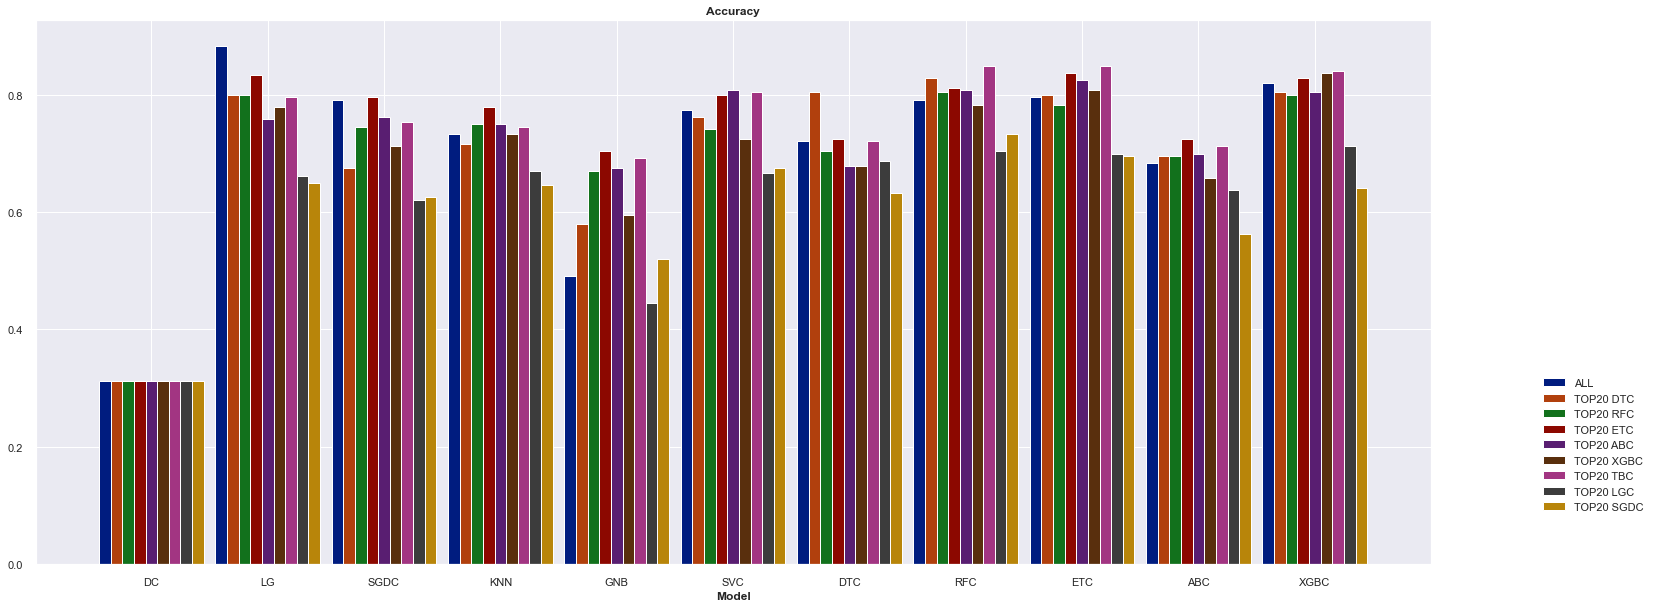

In [119]:
# set height of bars for accuracy
bars_heights_accuracy = [results_accuracy["ALL"]
                            , results_accuracy["TOP20 DTC"]
                            , results_accuracy["TOP20 RFC"]
                            , results_accuracy["TOP20 ETC"]
                            , results_accuracy["TOP20 ABC"]
                            , results_accuracy["TOP20 XGBC"]
                            , results_accuracy["TOP20 TBC"]
                            , results_accuracy["TOP20 LGC"]
                            , results_accuracy["TOP20 SGDC"]
                        ]

# use multibar_plot function to plot
multibar_plot(bars_heights_accuracy, labels_TOP20, name=labels_model, title="Accuracy", xlb="Model")

In [120]:
# get the 3 (default n=3) best model + feature selection combinations for Accuracy using top_model function
top_model(results_accuracy, n=4)

# here RFC + TOP20 TBC has exactly the same value as ETC + TOP20 TBC

TOP: 1
Value: 0.8833333333333334
Model: LG
Feature Selection: ALL
-----------------------------------------------------------------
TOP: 2
Value: 0.85
Model: RFC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 3
Value: 0.85
Model: RFC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 4
Value: 0.8416666666666666
Model: XGBC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------


###### Roc_AUC

In [121]:
#Create Dataframe with all Results for Roc_AUC
results_Roc_AUC = pd.DataFrame()

#Enter Results
results_Roc_AUC["ALL"] = pd.DataFrame(results_all).T.Roc_AUC
results_Roc_AUC["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.Roc_AUC
results_Roc_AUC["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.Roc_AUC

results_Roc_AUC

,ALL,TOP20 DTC,TOP20 RFC,TOP20 ETC,TOP20 ABC,TOP20 XGBC,TOP20 TBC,TOP20 LGC,TOP20 SGDC
DC,0.484510,0.484510,0.484510,0.484510,0.484510,0.484510,0.484510,0.484510,0.484510
LG,0.956116,0.906543,0.927837,0.939734,0.904579,0.898012,0.921670,0.828859,0.815798
SGDC,0.895104,0.828170,0.850315,0.873876,0.867351,0.828724,0.855902,0.761208,0.746712
KNN,0.890119,0.871697,0.884061,0.906796,0.910973,0.884129,0.901223,0.849254,0.818049
GNB,0.723588,0.794467,0.818251,0.841014,0.859719,0.815213,0.853368,0.727973,0.747219
SVC,0.908813,0.908085,0.907340,0.945024,0.929480,0.909928,0.931449,0.830724,0.863986
DTC,0.790895,0.852326,0.778612,0.793646,0.758503,0.759876,0.790455,0.765943,0.723501
RFC,0.923277,0.940143,0.918176,0.924408,0.937005,0.926497,0.949663,0.873637,0.861629
ETC,0.927515,0.930412,0.921157,0.939882,0.937525,0.928925,0.948435,0.868246,0.878052
ABC,0.849254,0.845308,0.836218,0.859379,0.872299,0.842728,0.858922,0.800879,0.739247


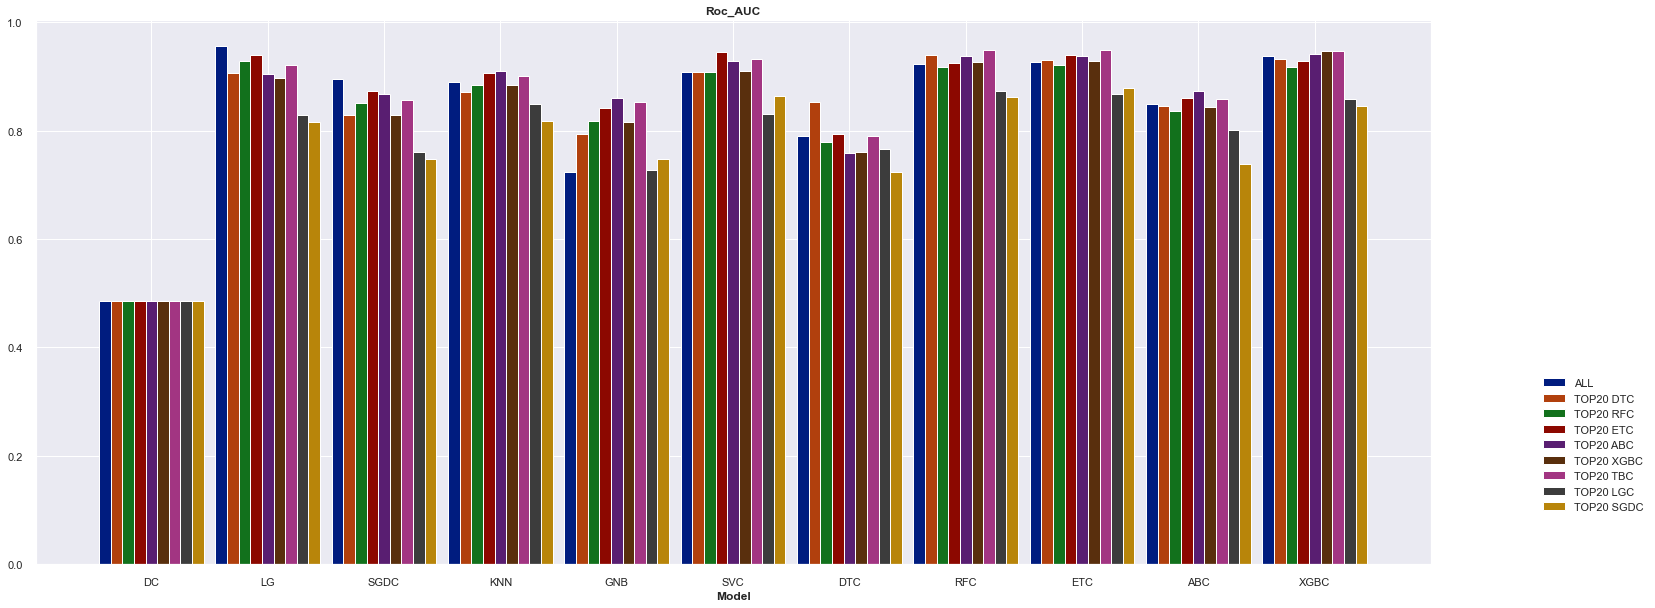

In [122]:
# set height of bars for Roc_AUC
bars_heights_Roc_AUC = [results_Roc_AUC["ALL"]
                            , results_Roc_AUC["TOP20 DTC"]
                            , results_Roc_AUC["TOP20 RFC"]
                            , results_Roc_AUC["TOP20 ETC"]
                            , results_Roc_AUC["TOP20 ABC"]
                            , results_Roc_AUC["TOP20 XGBC"]
                            , results_Roc_AUC["TOP20 TBC"]
                            , results_Roc_AUC["TOP20 LGC"]
                            , results_Roc_AUC["TOP20 SGDC"]
                       ]

# use multibar_plot function to plot
multibar_plot(bars_heights_Roc_AUC, labels_TOP20, name=labels_model, title="Roc_AUC", xlb="Model")

In [123]:
# get the 3 (default n=3) best model + feature selection combinations for Roc_AUC using top_model function
top_model(results_Roc_AUC, n=4)

TOP: 1
Value: 0.9561162717265954
Model: LG
Feature Selection: ALL
-----------------------------------------------------------------
TOP: 2
Value: 0.9496629695649303
Model: RFC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 3
Value: 0.9484348278503727
Model: ETC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 4
Value: 0.9476104102510451
Model: XGBC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------


###### F1

In [124]:
#Create Dataframe with all Results for F1
results_F1 = pd.DataFrame()

#Enter Results
results_F1["ALL"] = pd.DataFrame(results_all).T.F1
results_F1["TOP20 DTC"] = pd.DataFrame(results_dtc_top20).T.F1
results_F1["TOP20 RFC"] = pd.DataFrame(results_rfc_top20).T.F1
results_F1["TOP20 ETC"] = pd.DataFrame(results_etc_top20).T.F1
results_F1["TOP20 ABC"] = pd.DataFrame(results_abc_top20).T.F1
results_F1["TOP20 XGBC"] = pd.DataFrame(results_xgbc_top20).T.F1
results_F1["TOP20 TBC"] = pd.DataFrame(results_tbc_top20).T.F1
results_F1["TOP20 LGC"] = pd.DataFrame(results_lgc_top20).T.F1
results_F1["TOP20 SGDC"] = pd.DataFrame(results_sgdc_top20).T.F1

results_F1

,ALL,TOP20 DTC,TOP20 RFC,TOP20 ETC,TOP20 ABC,TOP20 XGBC,TOP20 TBC,TOP20 LGC,TOP20 SGDC
DC,0.310899,0.310899,0.310899,0.310899,0.310899,0.310899,0.310899,0.310899,0.310899
LG,0.884217,0.798171,0.797601,0.833136,0.756042,0.778061,0.791630,0.654650,0.629614
SGDC,0.791726,0.670457,0.740076,0.793302,0.752587,0.705258,0.749367,0.607879,0.606595
KNN,0.724300,0.707186,0.743920,0.766116,0.735929,0.727934,0.729479,0.661592,0.641500
GNB,0.465074,0.567996,0.670855,0.705992,0.672050,0.585633,0.683199,0.418191,0.498206
SVC,0.777550,0.761711,0.740894,0.799418,0.809694,0.728060,0.801901,0.665007,0.672431
DTC,0.719283,0.803452,0.703961,0.717629,0.677656,0.677459,0.719771,0.685300,0.631165
RFC,0.792619,0.829099,0.802433,0.809822,0.801904,0.782241,0.849879,0.702681,0.733078
ETC,0.795604,0.798112,0.781252,0.834932,0.818551,0.810148,0.848707,0.698644,0.693328
ABC,0.692196,0.698045,0.694652,0.728457,0.705863,0.662798,0.718753,0.631820,0.557690


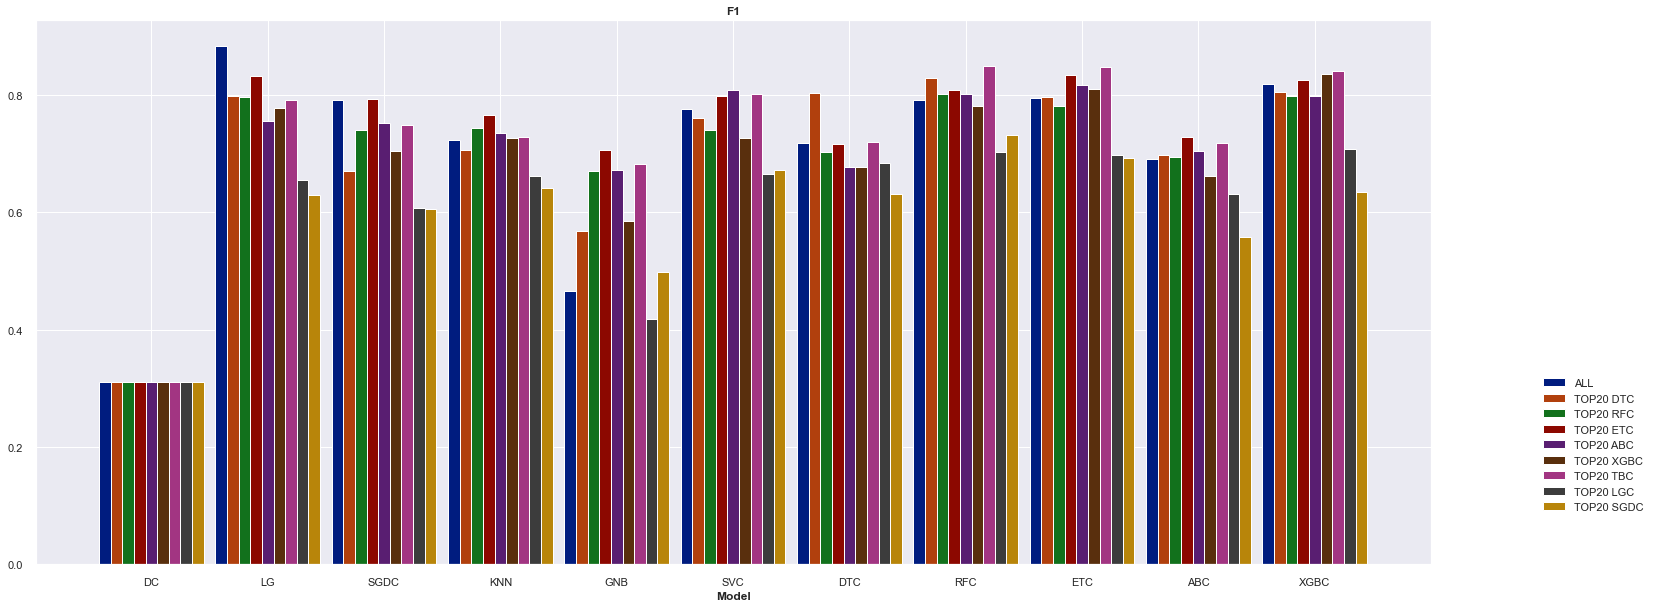

In [125]:
# set height of bars for F1
bars_heights_F1 = [results_F1["ALL"]
                            , results_F1["TOP20 DTC"]
                            , results_F1["TOP20 RFC"]
                            , results_F1["TOP20 ETC"]
                            , results_F1["TOP20 ABC"]
                            , results_F1["TOP20 XGBC"]
                            , results_F1["TOP20 TBC"]
                            , results_F1["TOP20 LGC"]
                            , results_F1["TOP20 SGDC"]
                  
                  ]

# use multibar_plot function to plot
multibar_plot(bars_heights_F1, labels_TOP20, name=labels_model, title="F1", xlb="Model")

In [126]:
# get the 3 (default n=3) best model + feature selection combinations for F1 using top_model function
top_model(results_F1, n=4)

TOP: 1
Value: 0.8842169798685209
Model: LG
Feature Selection: ALL
-----------------------------------------------------------------
TOP: 2
Value: 0.8498791431193189
Model: RFC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 3
Value: 0.8487071055287373
Model: ETC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------
TOP: 4
Value: 0.8414080065963422
Model: XGBC
Feature Selection: TOP20 TBC
-----------------------------------------------------------------


In [127]:
# Best Feature Selection: TOP20 TBC

In [128]:
# Best Models: ETC, RFC, XGBC

In [129]:
# If StandardScaler is used TOP1 is LG with ALL Features
# but this is not an Option as I would like to reduce
# that´s why I am making no changes below (maybe adjust parameters again)

### Model Optimization

In [130]:
# As the aimed metric is precision I will optimize on precision

#### Random Search Grid Parameters

In [131]:
# With TOP20 TBC as the chosen feature selection create a new X_test

# use dataframe_selection function for creating new dataframe
X_tbc_top20_test = dataframe_selection(results_TBC["TBC"], X_train=X_test)

In [132]:
#check dataframe
print(X_tbc_top20_test.shape)
X_tbc_top20_test.columns

(30, 20)


Index(['hsa-let-7b-5p', 'hsa-let-7f-1-3p', 'hsa-miR-1202', 'hsa-miR-1255b-5p',
       'hsa-miR-1305', 'hsa-miR-17-3p', 'hsa-miR-1910-5p', 'hsa-miR-192-5p',
       'hsa-miR-21-3p', 'hsa-miR-3152-3p', 'hsa-miR-3190-5p', 'hsa-miR-320a',
       'hsa-miR-320c', 'hsa-miR-323a-3p', 'hsa-miR-4258', 'hsa-miR-4261',
       'hsa-miR-4281', 'hsa-miR-564', 'hsa-miR-590-5p', 'hsa-miR-924'],
      dtype='object')

In [133]:
# Stop Switch
sys.exit("Stop without Steps below!")

SystemExit: Stop without Steps below!

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


##### Random Search Random Forrest Classifier (RFC)

In [ ]:
# First use random search to check a broad range of parameters

# Initialize Classifier Model
RFC2 = RandomForestClassifier(random_state=seed) # =model

# Set Hyperparameter grid for Model with alternatives to default values (included in grid)
parameters_RFC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3, 5, 10],
    'n_estimators': [100, 400, 700, 1000, 1300, 1600],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(RFC2, parameters_RFC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
# Second use random search to narrow down the range of parameters

# Set new Hyperparameter grid for Model
parameters_RFC_new = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 8, 10, 12, 14, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_estimators': [100, 1100, 1200, 1300, 1400, 1500],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(RFC2, parameters_RFC_new, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

##### Random Search Extra Tree Classifier (ETC)

In [ ]:
# First use random search to check a broad range of parameters

# Initialize Classifier Model
ETC2 = ExtraTreesClassifier(random_state=seed) # =model

# Set Hyperparameter grid for Model with alternatives to default values (included in grid)
parameters_ETC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 5, 10],
    'n_estimators': [100, 400, 800, 1200, 1600, 2000],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(ETC2, parameters_ETC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
# Second use random search to narrow down the range of parameters

# Set new Hyperparameter grid for Model
parameters_ETC_new = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [26, 28, 30, 32, 34],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [200, 300, 400, 500, 600],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(ETC2, parameters_ETC_new, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

##### Random Search XG Boost Classifier (XGBC)

In [ ]:
# First use random search to check a broad range of parameters

# Initialize Classifier Model
XGBC2 = XGBClassifier(random_state=seed)  # =model

# Set Hyperparameter grid for Model with alternatives to default values (included in grid)
parameters_XGBC = {
    'max_depth': [3, 9, 15, 21, 27, 33, None],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0], 
    'n_estimators': [100, 200, 300, 400, 500],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(XGBC2, parameters_XGBC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
# Second use random search to narrow down the range of parameters

# Set new Hyperparameter grid for Model
parameters_XGBC_new = {
    'max_depth': [3, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
    'learning_rate': [0.005, 0.0075, 0.01, 0.025, 0.05, 0.1],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.85, 0.875, 0.9, 0.925, 0.95, 1.0],
    'colsample_bytree': [0.45, 0.475, 0.5, 0.525, 0.55, 1.0], 
    'n_estimators': [100, 225, 250, 300, 325, 350],
    'n_jobs': [-1]
}

# Use random_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test, y_test)
random_searching(XGBC2, parameters_XGBC_new, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
# Stop Switch
#sys.exit("Stop without Steps below!")

#### Optimization with Grid Search

In [ ]:
# Initialize Classifier Models
RFC3 = RandomForestClassifier(random_state=seed)
ETC3 = ExtraTreesClassifier(random_state=seed)
XGBC3 = XGBClassifier(random_state=seed)

# Create Dictionary for Optimization results
results_opt = {}

##### Grid Search Random Forrest Classifier (RFC)

In [ ]:
# List with keys for optimized and unoptized model
name_model_RFC = ["RFC_UnOpt", "RFC_Opt"]

# Set Hyperparameter grid for Model
parameters_RFC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [9, 10, 11, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 1350, 1400, 1425, 1450],
    'n_jobs': [-1]
}

# Use grid_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test)
grid_searching(results_opt, RFC3, name_model_RFC, parameters_RFC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

##### Grid Search Extra Tree Classifier (ETC)

In [ ]:
# List with keys for optimized and unoptized model
name_model_ETC = ["ETC_UnOpt", "ETC_Opt"]

# Set Hyperparameter grid for Model
parameters_ETC = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [25, 26, 27, None],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 325, 350, 400, 425, 450],
    'n_jobs': [-1]
}


# Use grid_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test)
grid_searching(results_opt, ETC3, name_model_ETC, parameters_ETC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

##### Grid Search XG Boost Classifier (XGBC)

In [ ]:
# List with keys for optimized and unoptized model
name_model_XGBC = ["XGBC_UnOpt", "XGBC_Opt"] 

# Set Hyperparameter grid for Model
parameters_XGBC = {
    'max_depth': [3, 31, 32, 33],
    'learning_rate': [0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.1],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.88, 0.89, 0.9, 0.91, 0.92, 1.0],
    'colsample_bytree': [0.43, 0.44, 0.45, 0.46, 0.47, 1.0], 
    'n_estimators': [100, 215, 220, 225, 230, 335],
    'n_jobs': [-1]
}

# Use grid_searching function with with TOP20 TBC Features Dataset (X_tbc_top20, y_train, X_tbc_top20_test)
grid_searching(results_opt, XGBC3, name_model_XGBC, parameters_XGBC, X_tbc_top20, y_train, X_tbc_top20_test, y_test)

In [ ]:
results_opt

In [ ]:
# Time to run complete Notebook
# execution queued 13:44:14 2020-04-28
# executed finished 23:45:20 2020-04-28

In [ ]:
# save results_opt dictionary to results_opt.p file

with open('results_opt.p', 'wb') as fp:
    pickle.dump(results_opt, fp, protocol=pickle.HIGHEST_PROTOCOL)

#### Breakpoint

In [134]:
# load results_opt dictionary from results_opt.p file as results_opt_new

with open('data/results_opt.p', 'rb') as fp:
    results_opt_new = pickle.load(fp)

In [135]:
# check if dictionary was loaded correctly
results_opt_new

{'RFC_UnOpt': {'Accuracy': 0.8333333333333334,
  'Roc_AUC': 0.9801128428579409,
  'Precision': 0.8333333333333334,
  'F1': 0.8333333333333334},
 'RFC_Opt': {'Accuracy': 0.8333333333333334,
  'Roc_AUC': 0.9862158538629128,
  'Precision': 0.8333333333333334,
  'F1': 0.8333333333333334},
 'ETC_UnOpt': {'Accuracy': 0.8666666666666667,
  'Roc_AUC': 0.9847424724875705,
  'Precision': 0.8666666666666667,
  'F1': 0.8666666666666667},
 'ETC_Opt': {'Accuracy': 0.8666666666666667,
  'Roc_AUC': 0.9817607954862857,
  'Precision': 0.8666666666666667,
  'F1': 0.8666666666666667},
 'XGBC_UnOpt': {'Accuracy': 0.9,
  'Roc_AUC': 0.9878288922406568,
  'Precision': 0.9,
  'F1': 0.9},
 'XGBC_Opt': {'Accuracy': 0.8333333333333334,
  'Roc_AUC': 0.9876543209876543,
  'Precision': 0.8333333333333334,
  'F1': 0.8333333333333334}}

#### Visualisation Model Optimization

In [136]:
#create dataframe with results_optimization
results_optimization = pd.DataFrame(results_opt_new)
results_optimization

,RFC_UnOpt,RFC_Opt,ETC_UnOpt,ETC_Opt,XGBC_UnOpt,XGBC_Opt
Accuracy,0.833333,0.833333,0.866667,0.866667,0.900000,0.833333
Roc_AUC,0.980113,0.986216,0.984742,0.981761,0.987829,0.987654
Precision,0.833333,0.833333,0.866667,0.866667,0.900000,0.833333
F1,0.833333,0.833333,0.866667,0.866667,0.900000,0.833333


In [137]:
#create Lists with Labels for Plotting
labels_opt = ["RFC_UnOpt", 
              "RFC_Opt", 
              "ETC_UnOpt", 
              "ETC_Opt",
              "XGBC_UnOpt",
              "XGBC_Opt",
             ]

labels_metric = ["Accuracy", 
              "Roc_AUC", 
              "Precision",
              "F1",
             ]

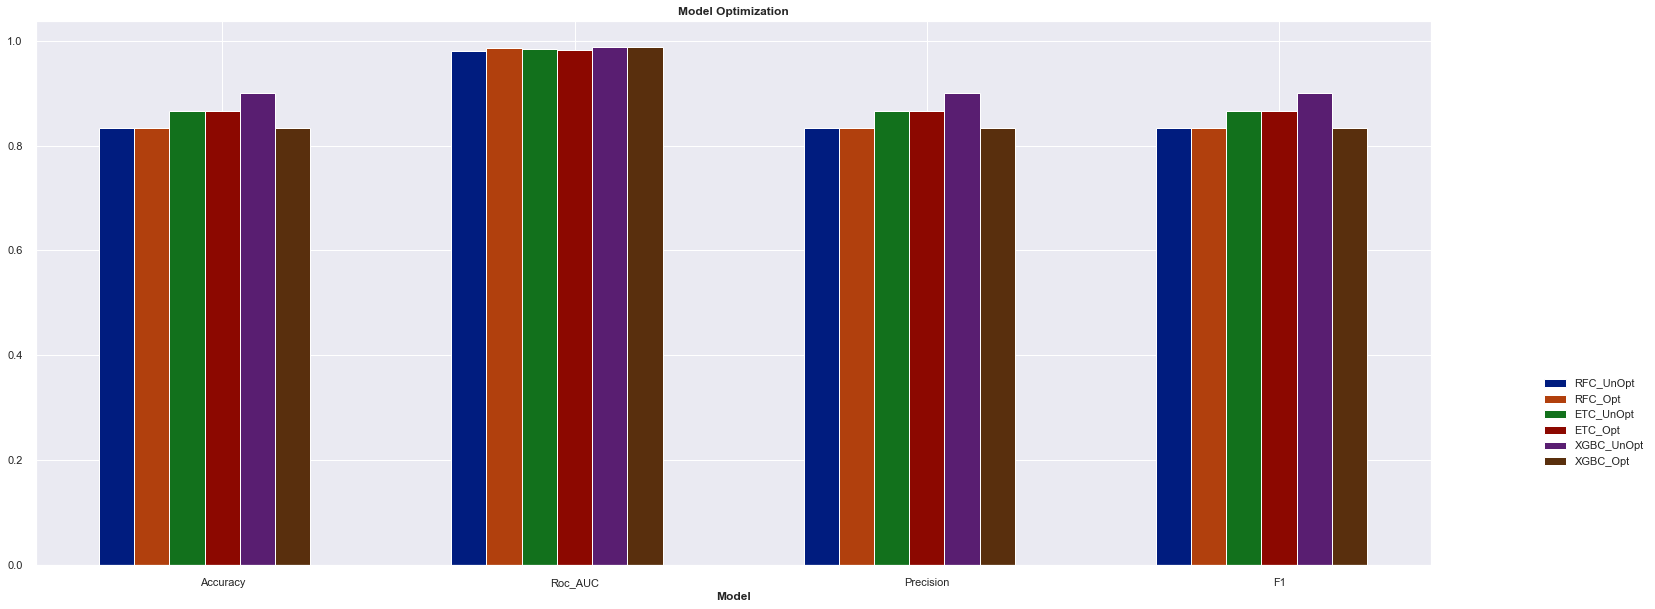

In [138]:
# set height of bars for Un-/ and Optimized Model
bars_heights_optimization = [results_optimization["RFC_UnOpt"]
                            , results_optimization["RFC_Opt"]
                            , results_optimization["ETC_UnOpt"]
                            , results_optimization["ETC_Opt"]
                            , results_optimization["XGBC_UnOpt"]
                            , results_optimization["XGBC_Opt"]
                         ]

# use multibar_plot function to plot
multibar_plot(bars_heights_optimization, labels_opt, name=labels_metric, title="Model Optimization", xlb="Model")

In [139]:
# Although I optimized the models on the chosen metric precision, the best way to compare the performance of
# different models is by their Roc_AUC. 
# As the Roc (receiver operating characteristics) curve of a model is the plot of the true positive rate (TPR)
# against the false positive rate (FPR) at various threshold settings, this is a measure for 
# the overall performance of a model independent from threshold settings.
# For better comparision the area under the curve (AUC) is used. The bigger the better the performance.

In [140]:
viz_summary(results_optimization, metric="Roc_AUC")

Roc_AUC Value:
RFC_UnOpt     0.980113
RFC_Opt       0.986216
ETC_UnOpt     0.984742
ETC_Opt       0.981761
XGBC_UnOpt    0.987829
XGBC_Opt      0.987654
Name: Roc_AUC, dtype: float64
----------------------------------------
Roc_AUC Rank:
RFC_UnOpt     1.0
RFC_Opt       4.0
ETC_UnOpt     3.0
ETC_Opt       2.0
XGBC_UnOpt    6.0
XGBC_Opt      5.0
Name: Roc_AUC, dtype: float64


In [141]:
# The best Roc_AUC is from XGBC_UnOpt (Roc_AUC: 0.987829, Rank = 6.0), followed by 
# XGBC_Opt (Roc_AUC: 0.987654, Rank = 5.0)

# Even if the unoptimized model XGBC_UnOpt shows better performance than the optimized model XGBC_Opt
# it´s better to choose XGBC_Opt as "top model", because during the optimzation the model is
# crossvalidated which prevents overfitting. XGBC_UnOpt wasn´t crossvalidated and might perform only better
# because of overfitting the data.
# As I included the default Parameters, which uses the unoptimized model, in the GridSearch these parameters were
# also used with crossvalidated data, but resulted a worse score as not choosen from GridSearchCV for best model parameters

#### Stacking

In [142]:
# given the Top3 Models I try to Stack these "weak learners" to one "strong learner"

In [143]:
# Initializing optimized Classifier Models and Meta Classifier

RFC_stack = RandomForestClassifier(bootstrap=True,
                                   ccp_alpha=0.0,
                                   class_weight=None,
                                   criterion='entropy',
                                   max_depth=9,
                                   max_features='log2',
                                   max_leaf_nodes=None,
                                   max_samples=None,
                                   min_impurity_decrease=0.0,
                                   min_impurity_split=None,
                                   min_samples_leaf=1,
                                   min_samples_split=3,
                                   min_weight_fraction_leaf=0.0,
                                   n_estimators=1350,
                                   n_jobs=-1,
                                   oob_score=False, 
                                   random_state=seed,
                                   verbose=0,
                                   warm_start=False)

ETC_stack = ExtraTreesClassifier(bootstrap=False,
                                 ccp_alpha=0.0,
                                 class_weight=None,
                                 criterion='entropy',
                                 max_depth=25,
                                 max_features='log2',
                                 max_leaf_nodes=None,
                                 max_samples=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 min_samples_leaf=1,
                                 min_samples_split=4,
                                 min_weight_fraction_leaf=0.0,
                                 n_estimators=350,
                                 n_jobs=-1,
                                 oob_score=False, 
                                 random_state=seed,
                                 verbose=0,
                                 warm_start=False)

XGBC_stack = XGBClassifier(base_score=0.5, 
                           booster='gbtree', 
                           colsample_bylevel=1, 
                           colsample_bynode=1, 
                           colsample_bytree=0.45, 
                           gamma=0, 
                           learning_rate=0.0075, 
                           max_delta_step=0, 
                           max_depth=31, 
                           min_child_weight=1, 
                           missing=None, 
                           n_estimators=225, 
                           n_jobs=-1, 
                           nthread=None, 
                           objective='multi:softprob', 
                           random_state=seed, 
                           reg_alpha=0, 
                           reg_lambda=1, 
                           scale_pos_weight=1, 
                           seed=None, 
                           silent=None, 
                           subsample=0.88, 
                           verbosity=1,
                           num_class=3) #num_class has to be added here manually for visualisation of precision recall curve

meta_classifier = LogisticRegression(random_state=seed)

# Building Stacking Classifier
SCLF = StackingCVClassifier(classifiers=[RFC_stack, ETC_stack, XGBC_stack],
                          meta_classifier=meta_classifier, random_state=seed)

# Building Ensemble Vote Classifier
EVCLF = EnsembleVoteClassifier(clfs=[RFC_stack, ETC_stack, XGBC_stack], voting='hard', weights=None, refit=True)

In [144]:
# List for models to be evaluated (Single vs. Stacked)
model_stack = [RFC_stack, ETC_stack, XGBC_stack, SCLF, EVCLF]

# List for model names
name_stack = ["RFC_Opt", "ETC_Opt", "XGBC_Opt", "SCLF", "EVCLF"]

In [145]:
# Create Dictionary for Evaluation results
results_stacking = {}

# Use model_evaluation function with TOP20 TBC Features Dataset (X_tbc_top20, y_train)
model_evaluation(results_stacking, model_stack, name_stack, X_tbc_top20, y_train)

--------------------------------------------------------------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1350,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Scores:
{'Accuracy': 0.8708333333333333, 'Roc_AUC': 0.9484463678996906, 'Precision': 0.8765725178960473, 'F1': 0.8722337052293282}
--------------------------------------------------------------------------------
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=25, max_features='log2',
               

{'RFC_Opt': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9484463678996906,
  'Precision': 0.8765725178960473,
  'F1': 0.8722337052293282},
 'ETC_Opt': {'Accuracy': 0.875,
  'Roc_AUC': 0.9488545343669671,
  'Precision': 0.8780851229380641,
  'F1': 0.8756712386004478},
 'XGBC_Opt': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.949728003935092,
  'Precision': 0.8755703392468097,
  'F1': 0.8722608114302878},
 'SCLF': {'Accuracy': 0.875,
  'Roc_AUC': 0.9234401861255662,
  'Precision': 0.8794047619047619,
  'F1': 0.8762799058715833},
 'EVCLF': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988}}

##### Visualisation Stacking

In [146]:
#create dataframe with results_optimization
results_stack = pd.DataFrame(results_stacking)
results_stack

,RFC_Opt,ETC_Opt,XGBC_Opt,SCLF,EVCLF
Accuracy,0.870833,0.875000,0.870833,0.875000,0.870833
Roc_AUC,0.948446,0.948855,0.949728,0.923440,0.952963
Precision,0.876573,0.878085,0.875570,0.879405,0.873980
F1,0.872234,0.875671,0.872261,0.876280,0.871609


In [147]:
#create Lists with Labels for Plotting
labels_stack = ["RFC_Opt",  
              "ETC_Opt",
              "XGBC_Opt",
              "SCLF",
              "EVCLF"
             ]

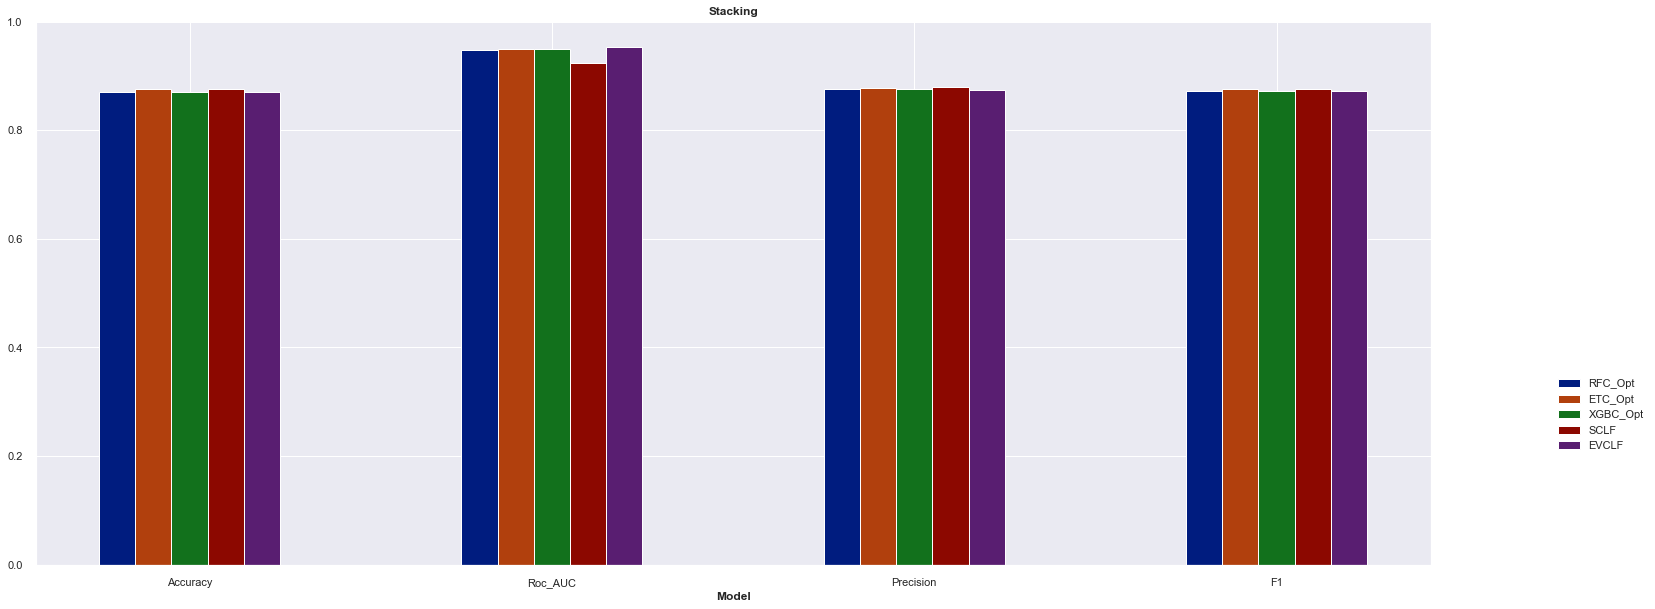

In [148]:
# set height of bars for Un-/ and stacked Model
bars_heights_stack = [results_stack["RFC_Opt"]
                            , results_stack["ETC_Opt"]
                            , results_stack["XGBC_Opt"]
                            , results_stack["SCLF"]
                            , results_stack["EVCLF"]
                         ]

# use multibar_plot function to plot
multibar_plot(bars_heights_stack, labels_stack, name=labels_metric, title="Stacking", xlb="Model")

In [149]:
viz_summary(results_stack, metric="Roc_AUC")

Roc_AUC Value:
RFC_Opt     0.948446
ETC_Opt     0.948855
XGBC_Opt    0.949728
SCLF        0.923440
EVCLF       0.952963
Name: Roc_AUC, dtype: float64
----------------------------------------
Roc_AUC Rank:
RFC_Opt     2.0
ETC_Opt     3.0
XGBC_Opt    4.0
SCLF        1.0
EVCLF       5.0
Name: Roc_AUC, dtype: float64


In [150]:
# The Ensemble Vote Classifier(EVCLF) shows the highest performance (see Roc_AUC). 
# The Stacking Classifier showed the lowest.

#### Visualisation Top Model (EVCLF)

###### Top Model (EVCLF)

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


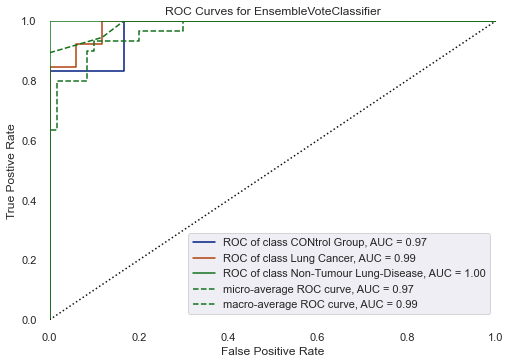

In [151]:
# EVCLF Classification model is already instantiated

# hide axes for better visualisation
ax = plt.axes(frameon=False)

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(EVCLF, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# Fit the model 
EVCLF.fit(X_tbc_top20, y_train)

# Fit the training data to the visualizer
visualizer_rocauc.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_rocauc.show();                       

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


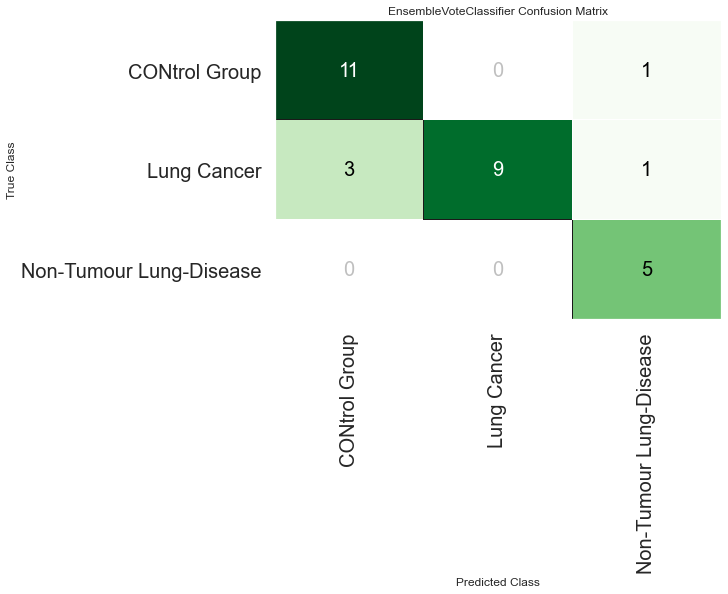

In [152]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(EVCLF,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap= "Greens",
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_tbc_top20_test, y_test)

# Finalize and render the figure
visualizer_cm.show();

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


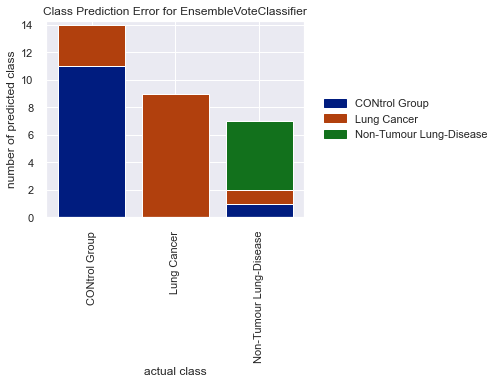

In [153]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(EVCLF,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_cpe.show();  

###### Baseline Model Dummy Classifier (DC)

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


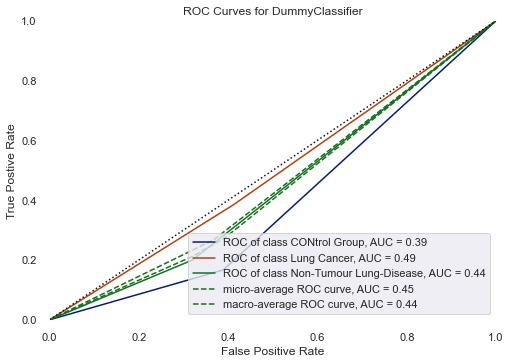

In [154]:
# Instantiate the classification model 
dummy = DummyClassifier(random_state=seed) # The Dummy Classifier is used as Baseline Model

# hide axes for better visualisation
ax = plt.axes(frameon=False)

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(dummy, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# Fit the model 
dummy.fit(X_tbc_top20, y_train)

# Fit the training data to the visualizer
visualizer_rocauc.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_rocauc.show();                       

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


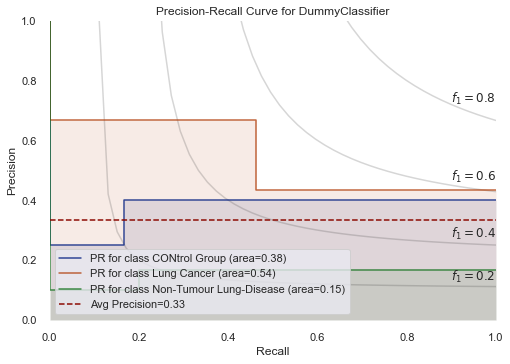

In [155]:
# hide axes for better visualisation
ax = plt.axes(frameon=False)

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)

#precisionRecallCurve is not possible for EVCLF (no decision_function attribute + multiclass)
visualizer_pcc = PrecisionRecallCurve(dummy, 
                                      per_class=True, 
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                                      iso_f1_curves=True,
                                      fill_area=True,
                                      micro=False,
                                      fill_opacity=0.1,
                                         ap_score=True)

# Fit the training data to the visualizer
visualizer_pcc.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_pcc.score(X_tbc_top20_test, y_test)

# Finalize and render the figure
visualizer_pcc.show();

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


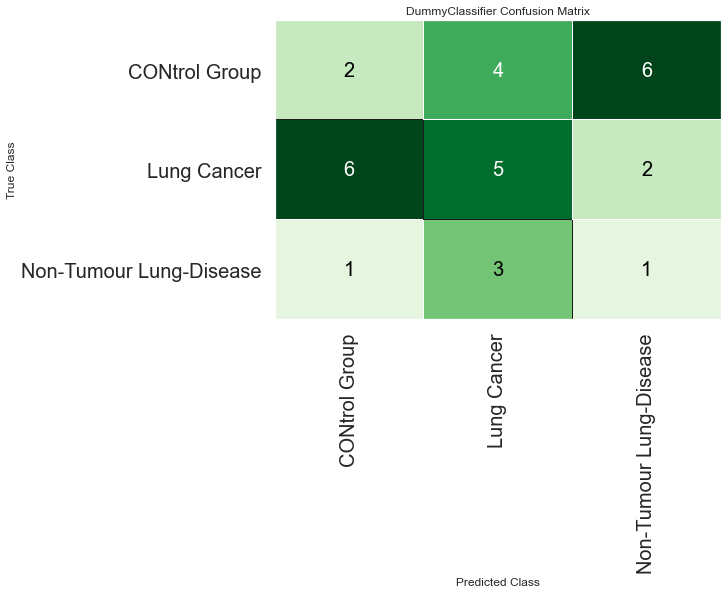

In [156]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(dummy,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap= "Greens",
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_tbc_top20_test, y_test)

# Finalize and render the figure
visualizer_cm.show();

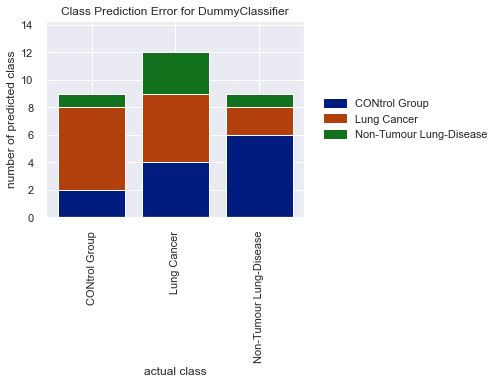

In [157]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(dummy,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_tbc_top20, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_tbc_top20_test, y_test)        

# Finalize and render the figure
visualizer_cpe.show();  

### Feature Reduction (TOP14)

In [158]:
# As the intention was to find 10 to 20 miRNA for determination in which class a patient
# belongs, I try to reduce the number of feature miRNAs as good as possible without loosing
# to much performance of the model (focus on precision). This makes sense as with less feature miRNA on a final
# test system could potentially save time and money.

In [159]:
# because the stacked model doesn´t show a coef_ or feature_importances_ attribute
# I will do the recursive feature elemination "by hand"
# from Feature Selection I know the importance of my TOP20, so I will remove in order from the least
# important to the most important feature and check the model preformance

In [160]:
#First create a list of Features from Feature Selection Results TBC
feature_reduction = [feature_name[0] for feature_name in results_TBC["TBC"]]

# List with model used in Feature Reduction (Top Model)
model_reduction = [EVCLF]

# List for names of reduced dataframes
name_reduce = ["TOP20", 
                  "TOP19_hsa-let-7f-1-3p", 
                  "TOP18_hsa-miR-4281",
                  "TOP17_hsa-miR-320c",
                  "TOP16_hsa-miR-924",
                  "TOP15_hsa-miR-4261",
                  "TOP14_hsa-miR-1305",
                  "TOP13_hsa-miR-3152-3p",
                  "TOP12_hsa-miR-4258",
                  "TOP11_hsa-miR-1255b-5p",
                  "TOP10_hsa-let-7b-5p"]

# Create Dictionary for Reduction results
results_reduction = {}

# create list for used features (only for debugging)
elim_features = []

# use feature reduce function
feature_reduce(results_reduction, model_reduction, name_reduce, feature_reduction, elim_features, X_train=X_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'TOP19_hsa-let-7f-1-3p': {'Accuracy': 0.8541666666666666,
  'Roc_AUC': 0.9522547928153557,
  'Precision': 0.8571210706504824,
  'F1': 0.8543324714220223},
 'TOP18_hsa-miR-4281': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9498976101077717,
  'Precision': 0.8655859010270776,
  'F1': 0.8621195026539745},
 'TOP17_hsa-miR-320c': {'Accuracy': 0.8541666666666666,
  'Roc_AUC': 0.9481965138817013,
  'Precision': 0.8571243625655389,
  'F1': 0.8541268142095859},
 'TOP16_hsa-miR-924': {'Accuracy': 0.8541666666666666,
  'Roc_AUC': 0.945843907961387,
  'Precision': 0.8573648247177659,
  'F1': 0.8535299777525344},
 'TOP15_hsa-miR-4261': {'Accuracy': 0.8458333333333332,
  'Roc_AUC': 0.9437685252735559,
  'Precision': 0.8485264408793821,
  'F1': 0.8443417003616245},
 'TOP14_hsa-miR-1305': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.865306001188

In [161]:
#check results dictionary
results_reduction

{'TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'TOP19_hsa-let-7f-1-3p': {'Accuracy': 0.8541666666666666,
  'Roc_AUC': 0.9522547928153557,
  'Precision': 0.8571210706504824,
  'F1': 0.8543324714220223},
 'TOP18_hsa-miR-4281': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9498976101077717,
  'Precision': 0.8655859010270776,
  'F1': 0.8621195026539745},
 'TOP17_hsa-miR-320c': {'Accuracy': 0.8541666666666666,
  'Roc_AUC': 0.9481965138817013,
  'Precision': 0.8571243625655389,
  'F1': 0.8541268142095859},
 'TOP16_hsa-miR-924': {'Accuracy': 0.8541666666666666,
  'Roc_AUC': 0.945843907961387,
  'Precision': 0.8573648247177659,
  'F1': 0.8535299777525344},
 'TOP15_hsa-miR-4261': {'Accuracy': 0.8458333333333332,
  'Roc_AUC': 0.9437685252735559,
  'Precision': 0.8485264408793821,
  'F1': 0.8443417003616245},
 'TOP14_hsa-miR-1305': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.865306001188

In [162]:
elim_features

[Index(['hsa-let-7b-5p', 'hsa-let-7f-1-3p', 'hsa-miR-1202', 'hsa-miR-1255b-5p',
        'hsa-miR-1305', 'hsa-miR-17-3p', 'hsa-miR-1910-5p', 'hsa-miR-192-5p',
        'hsa-miR-21-3p', 'hsa-miR-3152-3p', 'hsa-miR-3190-5p', 'hsa-miR-320a',
        'hsa-miR-320c', 'hsa-miR-323a-3p', 'hsa-miR-4258', 'hsa-miR-4261',
        'hsa-miR-4281', 'hsa-miR-564', 'hsa-miR-590-5p', 'hsa-miR-924'],
       dtype='object'),
 Index(['hsa-let-7b-5p', 'hsa-miR-1202', 'hsa-miR-1255b-5p', 'hsa-miR-1305',
        'hsa-miR-17-3p', 'hsa-miR-1910-5p', 'hsa-miR-192-5p', 'hsa-miR-21-3p',
        'hsa-miR-3152-3p', 'hsa-miR-3190-5p', 'hsa-miR-320a', 'hsa-miR-320c',
        'hsa-miR-323a-3p', 'hsa-miR-4258', 'hsa-miR-4261', 'hsa-miR-4281',
        'hsa-miR-564', 'hsa-miR-590-5p', 'hsa-miR-924'],
       dtype='object'),
 Index(['hsa-let-7b-5p', 'hsa-miR-1202', 'hsa-miR-1255b-5p', 'hsa-miR-1305',
        'hsa-miR-17-3p', 'hsa-miR-1910-5p', 'hsa-miR-192-5p', 'hsa-miR-21-3p',
        'hsa-miR-3152-3p', 'hsa-miR-3190-5p',

#### Visualisation Feature Reduction

In [163]:
#create dataframe with results_reduction
results_red = pd.DataFrame(results_reduction)
results_red

,TOP20,TOP19_hsa-let-7f-1-3p,TOP18_hsa-miR-4281,TOP17_hsa-miR-320c,TOP16_hsa-miR-924,TOP15_hsa-miR-4261,TOP14_hsa-miR-1305,TOP13_hsa-miR-3152-3p,TOP12_hsa-miR-4258,TOP11_hsa-miR-1255b-5p,TOP10_hsa-let-7b-5p
Accuracy,0.870833,0.854167,0.862500,0.854167,0.854167,0.845833,0.862500,0.820833,0.833333,0.816667,0.808333
Roc_AUC,0.952963,0.952255,0.949898,0.948197,0.945844,0.943769,0.947222,0.940795,0.942695,0.940392,0.938647
Precision,0.873980,0.857121,0.865586,0.857124,0.857365,0.848526,0.865306,0.823942,0.833958,0.821668,0.813575
F1,0.871609,0.854332,0.862120,0.854127,0.853530,0.844342,0.861757,0.819155,0.831391,0.815647,0.808135


In [164]:
name_reduce

['TOP20',
 'TOP19_hsa-let-7f-1-3p',
 'TOP18_hsa-miR-4281',
 'TOP17_hsa-miR-320c',
 'TOP16_hsa-miR-924',
 'TOP15_hsa-miR-4261',
 'TOP14_hsa-miR-1305',
 'TOP13_hsa-miR-3152-3p',
 'TOP12_hsa-miR-4258',
 'TOP11_hsa-miR-1255b-5p',
 'TOP10_hsa-let-7b-5p']

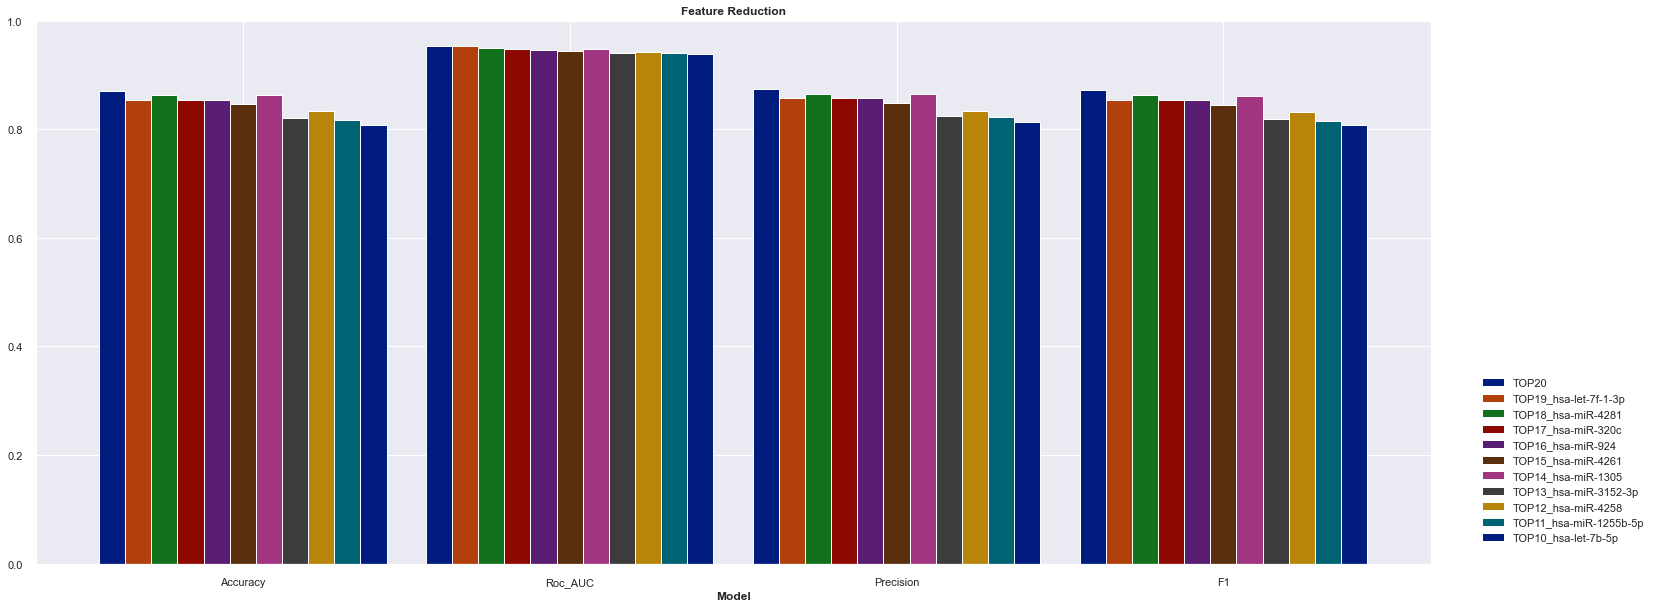

In [165]:
# set height of bars for Model with reduced Features
bars_heights_reduction = [results_red["TOP20"]
                            , results_red["TOP19_hsa-let-7f-1-3p"]
                            , results_red["TOP18_hsa-miR-4281"]
                            , results_red["TOP17_hsa-miR-320c"]
                            , results_red["TOP16_hsa-miR-924"]
                            , results_red["TOP15_hsa-miR-4261"]
                            , results_red["TOP14_hsa-miR-1305"]
                            , results_red["TOP13_hsa-miR-3152-3p"]
                            , results_red["TOP12_hsa-miR-4258"]
                            , results_red["TOP11_hsa-miR-1255b-5p"]
                            , results_red["TOP10_hsa-let-7b-5p"]
                         ]

# use multibar_plot function to plot
multibar_plot(bars_heights_reduction, name_reduce, name=labels_metric, title="Feature Reduction", xlb="Model", barWidth = 0.08)

In [166]:
viz_summary(results_red, metric="Precision")

Precision Value:
TOP20                     0.873980
TOP19_hsa-let-7f-1-3p     0.857121
TOP18_hsa-miR-4281        0.865586
TOP17_hsa-miR-320c        0.857124
TOP16_hsa-miR-924         0.857365
TOP15_hsa-miR-4261        0.848526
TOP14_hsa-miR-1305        0.865306
TOP13_hsa-miR-3152-3p     0.823942
TOP12_hsa-miR-4258        0.833958
TOP11_hsa-miR-1255b-5p    0.821668
TOP10_hsa-let-7b-5p       0.813575
Name: Precision, dtype: float64
----------------------------------------
Precision Rank:
TOP20                     11.0
TOP19_hsa-let-7f-1-3p      6.0
TOP18_hsa-miR-4281        10.0
TOP17_hsa-miR-320c         7.0
TOP16_hsa-miR-924          8.0
TOP15_hsa-miR-4261         5.0
TOP14_hsa-miR-1305         9.0
TOP13_hsa-miR-3152-3p      3.0
TOP12_hsa-miR-4258         4.0
TOP11_hsa-miR-1255b-5p     2.0
TOP10_hsa-let-7b-5p        1.0
Name: Precision, dtype: float64


In [167]:
#calculating Precision Difference between TOP20 and TOP14 in percent
Precision_diff = (results_red["TOP20"] - results_red["TOP14_hsa-miR-1305"]).T.Precision
print("Precision difference:", round(Precision_diff*100, 3), "%")

Precision difference: 0.867 %


In [168]:
# Looking at the results show that TOP14 has the third highest rank for
# precision (Rank 9) with an loss in precision by 0.867% compared to the best
# result (TOP20). I think this is a fair Trade-off between precision and number of features
# Therefore I consider this as the optimum (not best) conditions for
# the test

In [169]:
# Here is a critical point as I´ve chosen to manually remove the features
# if something in the calculation changes and the ranking above is affected
# the code doesn´t work from here on
# Better would be to automatically choose a smaller dataset
# but than the Trade-off has always be reconsidered (maybe not TOP14)

# Creating a TOP14 List and dictionary (e.g. dataframe selection)
TOP14 = feature_reduction.copy()

to_be_removed = ['hsa-let-7f-1-3p', 
                 'hsa-miR-4281',
                 'hsa-miR-320c',
                 'hsa-miR-924',
                 'hsa-miR-4261',
                 'hsa-miR-1305'
                ]

for tbr in to_be_removed:
    TOP14.remove(tbr)

# adding Rank to create Tuple List
TOP14_rank = list(zip(TOP14, list(range(1, 15))))

TOP14_dict = {}
TOP14_dict.update({"TOP14":TOP14_rank})

### Consideration of Annotation

In [170]:
# as last step I would like to check if I can improve the model by 
# considering the annotation.
# The categorie "Smoke" seems not useful for this, as patients have to
# be interviewed and answers are likely to be incorrect or misinterpreted.
# "Sex" is something easily to be checked either a medical doctor states it
# during the Liquid Biopsy or by detection of Y-chromosomal DNA.
# "Age" is also something easily to be added during Liquid Biopsy from patients data.
# Further it could be reasonable to check for age as miRNA are part of the human Epigenetics and these change with age.
# For this reason I check the model for augmentation by age or sex or both.

In [171]:
#include results for best Model with TOP20 and TOP14 to the results_anno dictionary!

# get best Model Values
EVCLF_TOP20 = dict(results_stack.get("EVCLF"))
EVCLF_TOP14 = results_reduction.get('TOP14_hsa-miR-1305')

# Create Dictionary for Results of Annotation augmentation
results_anno = {}

# write best model values to the dictionary
results_anno["EVCLF_TOP20"] = EVCLF_TOP20
results_anno["EVCLF_TOP14"] = EVCLF_TOP14

#### Sex

In [172]:
# maybe the part below has to move to feature engineering

In [173]:
# create new dataframe
df_sex = df4.copy()

In [174]:
# First I need to exclude some Samples as they are missing values for Sex.
# As these are only 6 values I decide to drop them from the dataframe

In [175]:
# check for SampleIDs of the missing values for Sex
print(df_sex.shape)
df_sex[(df_sex["Sex"] != "male") & (df_sex["Sex"] != "female")]

(300, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
11,SampleLC_12,LCa,1,NaN,51.1,Present,7.352240,10969.415922,13.458718,7715.893217,...,6.399376,6.370172,6.170333,5.593317,47.58938,33.09808,5.898978,6.83763,13.352700,8.041717
51,SampleLC_52,LCa,1,NaN,59.8,NaN,14.710189,14496.817638,28.902192,11116.743731,...,12.671290,12.394100,12.361860,11.007290,429.20770,86.47466,12.171280,40.89265,12.298730,62.543520
61,SampleLC_62,LCa,1,NaN,60.1,Present,8.466864,12841.925765,14.844140,19480.569859,...,7.298922,7.866371,7.198222,6.688853,94.56364,63.89421,6.905805,13.01252,7.540017,30.635340
161,SampleLC_162,LCa,1,NaN,67.8,NaN,7.350613,8412.779692,15.530363,4994.246101,...,6.459310,6.580593,6.584748,5.899555,51.65793,32.44906,6.038453,10.63997,6.574215,33.033280
298,SampleLC_299,NTLD,2,NaN,NaN,NaN,7.280144,26820.547670,22.475348,20045.890411,...,6.026219,6.335448,6.905308,5.775721,598.36890,124.62590,6.128294,101.78550,6.268956,137.157200
299,SampleLC_300,NTLD,2,NaN,NaN,NaN,7.214706,26597.044525,25.833810,32703.037481,...,5.752166,6.510901,6.439901,6.132002,1943.75200,96.96272,6.154981,86.36616,6.162856,60.648250


In [176]:
# Drop Instances from People without Sex Annotation
df_sex.drop([11, 51, 61, 161, 298, 299] , axis=0, inplace=True)

In [177]:
#Check again
print(df_sex.shape)
df_sex[(df_sex["Sex"] != "male") & (df_sex["Sex"] != "female")]

(294, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p


In [178]:
# As Sex is a categorical I need to convert it to a dummy variable
# thise means 1 = male and 0 = female

sex_dummies = pd.get_dummies(df_sex.Sex, drop_first=True)

In [179]:
sex_dummies

,male
0,1
1,0
2,0
3,0
4,1
...,...
293,1
294,1
295,1
296,1


In [180]:
# include it to the dataframe

df_sex = pd.concat([sex_dummies, df_sex], axis=1)

In [181]:
df_sex

,male,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
0,1,SampleLC_1,NTLD,2,male,34.0,NaN,10.169737,5717.565532,15.373312,...,6.390441,7.820884,8.481891,5.932662,112.3047,34.32323,7.073449,14.79587,6.989605,28.41288
1,0,SampleLC_2,NTLD,2,female,35.0,NaN,8.993866,8152.894560,14.683980,...,5.234970,7.567298,7.847653,5.985716,185.2690,47.13855,5.724681,15.02991,6.412826,13.66082
2,0,SampleLC_3,NTLD,2,female,37.0,NaN,9.221781,9161.633060,15.751940,...,4.435148,7.738681,7.893889,5.410440,182.6446,66.89235,6.719895,19.68656,7.317585,48.61566
3,0,SampleLC_4,LCa,1,female,43.5,Past,9.700501,15589.388815,11.411269,...,7.808394,8.844422,8.782223,8.176937,366.1072,40.31580,8.553054,224.52850,8.869005,66.39760
4,1,SampleLC_5,NTLD,2,male,44.0,Present,6.133340,23861.201568,25.375915,...,4.946353,5.378983,6.080522,5.319329,1501.0180,122.96760,5.220272,211.52930,5.563860,99.50221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,1,SampleLC_294,CON,0,male,81.0,Never,6.388280,22803.481320,13.348059,...,5.385862,5.496377,5.294729,5.092786,706.2968,116.38860,5.322500,48.56899,6.124906,67.03898
294,1,SampleLC_295,NTLD,2,male,81.5,Past,7.690654,25015.375396,18.129165,...,5.988553,6.378100,6.325723,5.092080,197.8862,77.23819,6.193247,51.08957,6.512407,90.30250
295,1,SampleLC_296,NTLD,2,male,83.0,Past,6.299681,22466.730785,22.954418,...,5.574495,5.378178,5.366570,4.894972,826.7432,95.43954,5.404515,65.70854,5.045749,101.93690
296,1,SampleLC_297,CON,0,male,84.0,Past,10.355813,11628.542374,17.644106,...,9.619025,9.268547,9.457460,8.677452,112.1474,38.56062,9.135264,75.32278,9.472440,22.70615


In [182]:
# Not Required Columns of complete DataFrame df_sex to List
col_sex = ['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']
col_sex

['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']

In [183]:
# Creating y and X

y_sex = df_sex['Label']

X_sex = df_sex.drop(col_sex, axis=1)

In [184]:
# Checking y
y_sex.unique()

array([2, 1, 0])

In [185]:
# Checking X
print(X_sex.info())
print(list(X_sex.columns))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 0 to 297
Columns: 1184 entries, male to hsa-miR-99b-5p
dtypes: float64(1183), uint8(1)
memory usage: 2.7 MB
None
['male', 'hsa-let-7a-3p', 'hsa-let-7a-5p', 'hsa-let-7b-3p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-3p', 'hsa-let-7d-5p', 'hsa-let-7e-3p', 'hsa-let-7e-5p', 'hsa-let-7f-1-3p', 'hsa-let-7f-2-3p', 'hsa-let-7f-5p', 'hsa-let-7g-3p', 'hsa-let-7g-5p', 'hsa-let-7i-3p', 'hsa-let-7i-5p', 'hsa-miR-1-3p', 'hsa-miR-100-3p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-101-5p', 'hsa-miR-103a-2-5p', 'hsa-miR-103a-3p', 'hsa-miR-103b', 'hsa-miR-105-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-3p', 'hsa-miR-106b-3p', 'hsa-miR-106b-5p', 'hsa-miR-107', 'hsa-miR-10a-3p', 'hsa-miR-10a-5p', 'hsa-miR-10b-3p', 'hsa-miR-10b-5p', 'hsa-miR-1178-3p', 'hsa-miR-1179', 'hsa-miR-1180-3p', 'hsa-miR-1181', 'hsa-miR-1182', 'hsa-miR-1183', 'hsa-miR-1184', 'hsa-miR-1185-5p', 'hsa-miR-1193', 'hsa-miR-1197', 'hsa-miR-1200', 'hsa-miR-1202', 'hsa-miR-1203'

In [186]:
# Separating data for final evaluation (Eval-Test-Set)
X_sex_modell, X_sex_eval, y_sex_modell, y_sex_eval = train_test_split(X_sex, y_sex, test_size=0.1, random_state=seed)

In [187]:
# choosing test size to same size as X_eval (not checked here!)
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(X_sex_modell, y_sex_modell, test_size=0.11, random_state=seed)

In [188]:
# use dataframe_selection function for creating new dataframe with TOP20
X_sex_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_sex_train)

In [189]:
# use dataframe_selection function for creating new dataframe with TOP14
X_sex_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_sex_train)

In [190]:
# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+SEX"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sex_top20, y_sex_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873}}

In [191]:
# List with model name
Top_Model_name = ["EVCLF_TOP14+SEX"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sex_top14, y_sex_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482}}

In [192]:
results_anno

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482}}

In [193]:
# Seems that Sex doesn´t improve the metrics

#### Age

In [194]:
# maybe the part below has to move to feature engineering

In [195]:
# create new dataframe
df_age = df4.copy()

In [196]:
# First I need to exclude some Samples as they are missing values for Sex.
# As these are only 3 values I decide to drop them from the dataframe

In [197]:
# check for SampleIDs of the missing values for Age
print(df_age.shape)
df_age[df_age["Age"].isna()]

(300, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
297,SampleLC_298,LCa,1,male,NaN,Past,8.769300,136769.972052,13.651284,83604.788124,...,6.811184,7.106680,7.905371,6.557362,1903.2900,945.21340,7.451859,89.09280,7.172268,112.37630
298,SampleLC_299,NTLD,2,NaN,NaN,NaN,7.280144,26820.547670,22.475348,20045.890411,...,6.026219,6.335448,6.905308,5.775721,598.3689,124.62590,6.128294,101.78550,6.268956,137.15720
299,SampleLC_300,NTLD,2,NaN,NaN,NaN,7.214706,26597.044525,25.833810,32703.037481,...,5.752166,6.510901,6.439901,6.132002,1943.7520,96.96272,6.154981,86.36616,6.162856,60.64825


In [198]:
# Drop Instances from People without Age Annotation
df_age.drop([297, 298, 299] , axis=0, inplace=True)

In [199]:
# check for SampleIDs of the missing values
print(df_age.shape)
df_age[df_age["Age"].isna()]

(297, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p


In [200]:
# As we have a small subgroup / outliers between 34 and 47 check how many values this are

df_age[df_age["Age"] <= 47]

,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
0,SampleLC_1,NTLD,2,male,34.0,NaN,10.169737,5717.565532,15.373312,2888.175532,...,6.390441,7.820884,8.481891,5.932662,112.30470,34.32323,7.073449,14.79587,6.989605,28.41288
1,SampleLC_2,NTLD,2,female,35.0,NaN,8.993866,8152.894560,14.683980,3805.584560,...,5.234970,7.567298,7.847653,5.985716,185.26900,47.13855,5.724681,15.02991,6.412826,13.66082
2,SampleLC_3,NTLD,2,female,37.0,NaN,9.221781,9161.633060,15.751940,1262.754060,...,4.435148,7.738681,7.893889,5.410440,182.64460,66.89235,6.719895,19.68656,7.317585,48.61566
3,SampleLC_4,LCa,1,female,43.5,Past,9.700501,15589.388815,11.411269,7857.315268,...,7.808394,8.844422,8.782223,8.176937,366.10720,40.31580,8.553054,224.52850,8.869005,66.39760
4,SampleLC_5,NTLD,2,male,44.0,Present,6.133340,23861.201568,25.375915,9886.602937,...,4.946353,5.378983,6.080522,5.319329,1501.01800,122.96760,5.220272,211.52930,5.563860,99.50221
5,SampleLC_6,NTLD,2,male,46.0,Past,7.275606,9901.092307,9.623426,2163.823798,...,5.703169,6.025623,6.445749,5.281039,70.09657,26.14897,6.983925,12.05903,8.172854,12.04608


In [201]:
# As these are only 6 values I decide to drop them also from the dataframe

# Drop Instances from People without Age < 40 Annotation
df_age.drop([0, 1, 2, 3, 4, 5] , axis=0, inplace=True)

In [202]:
# check again
df_age[df_age["Age"] <= 47]

,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p


count    291.000000
mean      66.882474
std        7.183717
min       47.200000
25%       62.000000
50%       67.000000
75%       72.450000
max       84.000000
Name: Age, dtype: float64

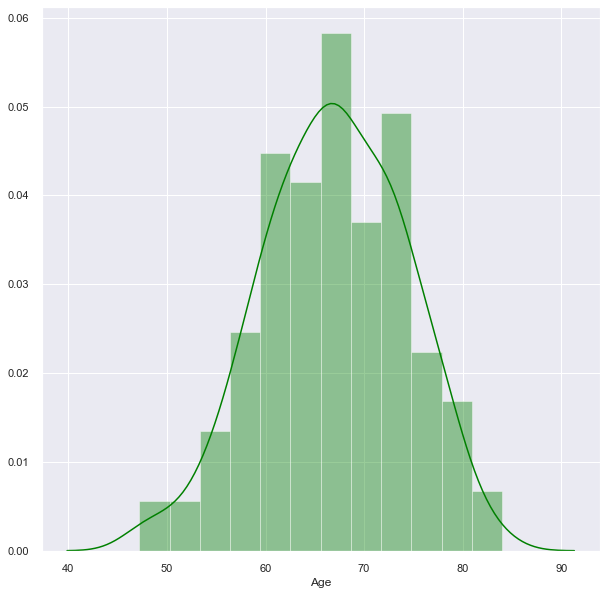

In [203]:
# Check istogram for Age Distribution again
plt.figure(figsize=(10,10))
sns.distplot(df_age.Age, color="Green");
df_age.Age.describe()

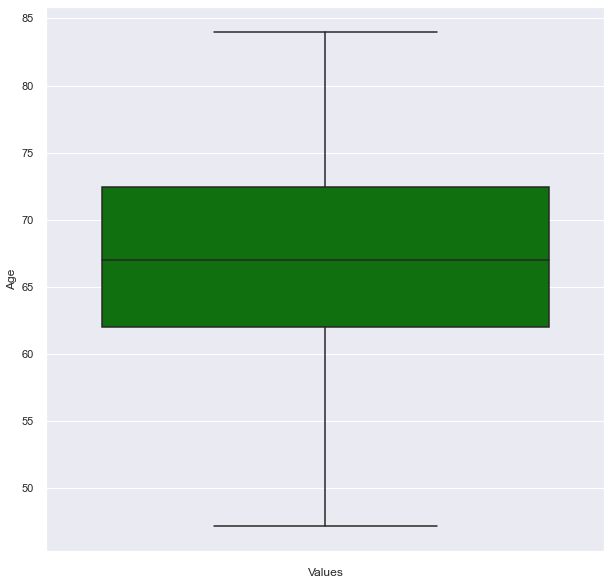

In [204]:
# Boxplot for Age again (reveals the presence of outliers)
plt.figure(figsize=(10,10))
sns.boxplot(df_age.Age, color="Green", orient="v")
plt.xlabel('Values');
plt.ylabel('Age');

In [205]:
# Not Required Columns of complete DataFrame df_sex to List
col_age = ['sampleID', 'Group', 'Label', 'Sex', 'Smoke']
col_age

['sampleID', 'Group', 'Label', 'Sex', 'Smoke']

In [206]:
# Creating y and X

y_age = df_age['Label']

X_age = df_age.drop(col_age, axis=1)

In [207]:
# Checking y
y_age.unique()

array([1, 2, 0])

In [208]:
# Checking X
print(X_age.info())
print(list(X_age.columns))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 6 to 296
Columns: 1184 entries, Age to hsa-miR-99b-5p
dtypes: float64(1184)
memory usage: 2.6 MB
None
['Age', 'hsa-let-7a-3p', 'hsa-let-7a-5p', 'hsa-let-7b-3p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-3p', 'hsa-let-7d-5p', 'hsa-let-7e-3p', 'hsa-let-7e-5p', 'hsa-let-7f-1-3p', 'hsa-let-7f-2-3p', 'hsa-let-7f-5p', 'hsa-let-7g-3p', 'hsa-let-7g-5p', 'hsa-let-7i-3p', 'hsa-let-7i-5p', 'hsa-miR-1-3p', 'hsa-miR-100-3p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-101-5p', 'hsa-miR-103a-2-5p', 'hsa-miR-103a-3p', 'hsa-miR-103b', 'hsa-miR-105-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-3p', 'hsa-miR-106b-3p', 'hsa-miR-106b-5p', 'hsa-miR-107', 'hsa-miR-10a-3p', 'hsa-miR-10a-5p', 'hsa-miR-10b-3p', 'hsa-miR-10b-5p', 'hsa-miR-1178-3p', 'hsa-miR-1179', 'hsa-miR-1180-3p', 'hsa-miR-1181', 'hsa-miR-1182', 'hsa-miR-1183', 'hsa-miR-1184', 'hsa-miR-1185-5p', 'hsa-miR-1193', 'hsa-miR-1197', 'hsa-miR-1200', 'hsa-miR-1202', 'hsa-miR-1203', 'hsa-miR-1

In [209]:
# Separating data for final evaluation (Eval-Test-Set)
X_age_modell, X_sex_eval, y_age_modell, y_age_eval = train_test_split(X_age, y_age, test_size=0.1, random_state=seed)

In [210]:
# choosing test size to same size as X_eval (not checked here!)
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age_modell, y_age_modell, test_size=0.11, random_state=seed)

In [211]:
# use dataframe_selection function for creating new dataframe with TOP20
X_age_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_age_train)

In [212]:
# use dataframe_selection function for creating new dataframe with TOP14
X_age_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_age_train)

In [213]:
# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_age_top20, y_age_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257}}

In [214]:
# List with model name
Top_Model_name = ["EVCLF_TOP14+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_age_top14, y_age_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342}}

In [215]:
results_anno

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342}}

In [216]:
# Seems that Sex doesn´t improve the metrics

#### Sex + Age

In [217]:
# maybe the part below has to move to feature engineering

In [218]:
# create new dataframe
df_sexage = df_age.copy()

In [219]:
# First I need to exclude some Samples as they are missing values for Sex.
# As these are only 4 values I decide to drop them from the dataframe

In [220]:
# check for SampleIDs of the missing values for Sex
print(df_sexage.shape)
df_sexage[(df_sexage["Sex"] != "male") & (df_sexage["Sex"] != "female")]

(291, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
11,SampleLC_12,LCa,1,NaN,51.1,Present,7.352240,10969.415922,13.458718,7715.893217,...,6.399376,6.370172,6.170333,5.593317,47.58938,33.09808,5.898978,6.83763,13.352700,8.041717
51,SampleLC_52,LCa,1,NaN,59.8,NaN,14.710189,14496.817638,28.902192,11116.743731,...,12.671290,12.394100,12.361860,11.007290,429.20770,86.47466,12.171280,40.89265,12.298730,62.543520
61,SampleLC_62,LCa,1,NaN,60.1,Present,8.466864,12841.925765,14.844140,19480.569859,...,7.298922,7.866371,7.198222,6.688853,94.56364,63.89421,6.905805,13.01252,7.540017,30.635340
161,SampleLC_162,LCa,1,NaN,67.8,NaN,7.350613,8412.779692,15.530363,4994.246101,...,6.459310,6.580593,6.584748,5.899555,51.65793,32.44906,6.038453,10.63997,6.574215,33.033280


In [221]:
# Drop Instances from People without Sex Annotation
df_sexage.drop([11, 51, 61, 161] , axis=0, inplace=True)

In [222]:
#Check again
print(df_sexage.shape)
df_sexage[(df_sexage["Sex"] != "male") & (df_sexage["Sex"] != "female")]

(287, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p


In [223]:
# Again as Sex is a categorical I need to convert it to a dummy variable
# thise means 1 = male and 0 = female

sexage_dummies = pd.get_dummies(df_sexage.Sex, drop_first=True)

In [224]:
# include it to the dataframe

df_sexage = pd.concat([sexage_dummies, df_sexage], axis=1)

In [225]:
df_sexage

,male,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
6,1,SampleLC_7,LCa,1,male,47.2,Never,7.449349,9353.363102,17.974963,...,5.852205,7.121904,6.861419,6.342839,65.47645,28.05550,6.229771,13.09222,5.797372,20.14075
7,1,SampleLC_8,LCa,1,male,47.6,Present,7.883027,21256.531275,14.870346,...,6.401037,6.686234,6.822405,6.601341,181.85850,81.34748,6.544575,82.84811,6.588593,113.99760
8,1,SampleLC_9,NTLD,2,male,48.0,Past,5.694632,40763.465605,24.793596,...,4.887123,5.146422,5.545423,5.021517,1142.62900,240.60940,5.173164,162.35660,4.922911,74.35790
9,1,SampleLC_10,LCa,1,male,48.8,Present,7.676339,29245.233210,18.707404,...,7.638856,7.511779,7.247646,6.523868,839.39520,175.08450,7.362235,142.08960,7.115215,78.01741
10,1,SampleLC_11,LCa,1,male,49.0,NaN,6.630315,14162.449093,15.723833,...,4.960116,5.736185,5.983633,4.914857,424.69410,100.07650,5.711783,29.03259,5.653348,20.05251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,1,SampleLC_293,CON,0,male,81.0,Never,24.502362,8726.485189,32.999253,...,21.138840,20.503430,20.961080,20.883070,183.18160,55.16094,21.107420,113.12870,21.973850,83.77009
293,1,SampleLC_294,CON,0,male,81.0,Never,6.388280,22803.481320,13.348059,...,5.385862,5.496377,5.294729,5.092786,706.29680,116.38860,5.322500,48.56899,6.124906,67.03898
294,1,SampleLC_295,NTLD,2,male,81.5,Past,7.690654,25015.375396,18.129165,...,5.988553,6.378100,6.325723,5.092080,197.88620,77.23819,6.193247,51.08957,6.512407,90.30250
295,1,SampleLC_296,NTLD,2,male,83.0,Past,6.299681,22466.730785,22.954418,...,5.574495,5.378178,5.366570,4.894972,826.74320,95.43954,5.404515,65.70854,5.045749,101.93690


In [226]:
# Not Required Columns of complete DataFrame df_sex to List
col_sexage = ['sampleID', 'Group', 'Label', 'Sex', 'Smoke']
col_sexage

['sampleID', 'Group', 'Label', 'Sex', 'Smoke']

In [227]:
# Creating y and X

y_sexage = df_sexage['Label']

X_sexage = df_sexage.drop(col_sexage, axis=1)

In [228]:
# Checking y
y_sexage.unique()

array([1, 2, 0])

In [229]:
# Checking X
print(X_sexage.info())
print(list(X_sexage.columns))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 6 to 296
Columns: 1185 entries, male to hsa-miR-99b-5p
dtypes: float64(1184), uint8(1)
memory usage: 2.6 MB
None
['male', 'Age', 'hsa-let-7a-3p', 'hsa-let-7a-5p', 'hsa-let-7b-3p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-3p', 'hsa-let-7d-5p', 'hsa-let-7e-3p', 'hsa-let-7e-5p', 'hsa-let-7f-1-3p', 'hsa-let-7f-2-3p', 'hsa-let-7f-5p', 'hsa-let-7g-3p', 'hsa-let-7g-5p', 'hsa-let-7i-3p', 'hsa-let-7i-5p', 'hsa-miR-1-3p', 'hsa-miR-100-3p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-101-5p', 'hsa-miR-103a-2-5p', 'hsa-miR-103a-3p', 'hsa-miR-103b', 'hsa-miR-105-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-3p', 'hsa-miR-106b-3p', 'hsa-miR-106b-5p', 'hsa-miR-107', 'hsa-miR-10a-3p', 'hsa-miR-10a-5p', 'hsa-miR-10b-3p', 'hsa-miR-10b-5p', 'hsa-miR-1178-3p', 'hsa-miR-1179', 'hsa-miR-1180-3p', 'hsa-miR-1181', 'hsa-miR-1182', 'hsa-miR-1183', 'hsa-miR-1184', 'hsa-miR-1185-5p', 'hsa-miR-1193', 'hsa-miR-1197', 'hsa-miR-1200', 'hsa-miR-1202', 'hsa-mi

In [230]:
# Separating data for final evaluation (Eval-Test-Set)
X_sexage_modell, X_sexage_eval, y_sexage_modell, y_sexage_eval = train_test_split(X_sexage, y_sexage, test_size=0.1, random_state=seed)

In [231]:
# choosing test size to same size as X_eval (not checked here!)
X_sexage_train, X_sexage_test, y_sexage_train, y_sexage_test = train_test_split(X_sexage_modell, y_sexage_modell, test_size=0.11, random_state=seed)

In [232]:
# use dataframe_selection function for creating new dataframe with TOP20
X_sexage_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_sexage_train)

In [233]:
# use dataframe_selection function for creating new dataframe with TOP14
X_sexage_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_sexage_train)

In [234]:
# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+SEX+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sexage_top20, y_sexage_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342},
 'EVCLF_TOP20+SEX+AGE': {'Accuracy': 0.8297584541062802,
  'Roc_AUC': 0.9464937275985662,
  'Precision': 0.836074481074481,


In [235]:
# List with model name
Top_Model_name = ["EVCLF_TOP14+SEX+AGE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_sexage_top14, y_sexage_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342},
 'EVCLF_TOP20+SEX+AGE': {'Accuracy': 0.8297584541062802,
  'Roc_AUC': 0.9464937275985662,
  'Precision': 0.836074481074481,


In [236]:
results_anno

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342},
 'EVCLF_TOP20+SEX+AGE': {'Accuracy': 0.8297584541062802,
  'Roc_AUC': 0.9464937275985662,
  'Precision': 0.836074481074481,


In [237]:
# nothing beats the best!

#### Smoke

In [238]:
# Even if it is not usefull or reasonable to use the Smoke annotation as
# predicting value, I would like to check it to be comprehensiv

In [239]:
# maybe the part below has to move to feature engineering

In [240]:
# create new dataframe
df_smoke = df4.copy()

In [241]:
# First I need to exclude Samples as they are missing values for Smoke.
# Unfortunately there are 53 Samples, but I decide to drop them from the dataframe

In [242]:
# check for SampleIDs of the missing values
print(df_smoke.shape)
df_smoke[df_smoke["Smoke"].isna()]

(300, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p
0,SampleLC_1,NTLD,2,male,34.0,NaN,10.169737,5717.565532,15.373312,2888.175532,...,6.390441,7.820884,8.481891,5.932662,112.304700,34.323230,7.073449,14.795870,6.989605,28.412880
1,SampleLC_2,NTLD,2,female,35.0,NaN,8.993866,8152.894560,14.683980,3805.584560,...,5.234970,7.567298,7.847653,5.985716,185.269000,47.138550,5.724681,15.029910,6.412826,13.660820
2,SampleLC_3,NTLD,2,female,37.0,NaN,9.221781,9161.633060,15.751940,1262.754060,...,4.435148,7.738681,7.893889,5.410440,182.644600,66.892350,6.719895,19.686560,7.317585,48.615660
10,SampleLC_11,LCa,1,male,49.0,NaN,6.630315,14162.449093,15.723833,8783.679093,...,4.960116,5.736185,5.983633,4.914857,424.694100,100.076500,5.711783,29.032590,5.653348,20.052510
14,SampleLC_15,LCa,1,female,52.7,NaN,7.211362,7334.398866,14.891057,9141.500692,...,6.704164,7.308914,7.378314,6.636842,38.341590,20.233220,7.076388,55.811270,6.206702,67.604700
24,SampleLC_25,LCa,1,male,55.6,NaN,7.637943,29382.332394,14.233708,25423.253585,...,6.349057,6.464235,6.613746,6.377147,193.445600,132.203400,6.094840,74.792720,7.255824,120.070500
32,SampleLC_33,LCa,1,male,57.4,NaN,7.104544,18404.385190,17.835497,11265.212508,...,6.006015,5.749216,6.340857,5.553972,109.871400,54.938630,6.266146,19.964820,6.309011,16.884570
35,SampleLC_36,NTLD,2,male,58.0,NaN,11.978954,5816.756750,19.325160,2606.116750,...,6.508610,9.577095,8.863275,5.857170,166.951200,40.967850,8.103148,27.491950,7.496983,38.555860
50,SampleLC_51,LCa,1,female,59.5,NaN,8.235119,78472.445540,16.157053,19650.082803,...,6.789395,7.508799,7.190835,6.773388,2413.879000,562.543500,6.643477,93.228250,6.803470,51.420710
51,SampleLC_52,LCa,1,NaN,59.8,NaN,14.710189,14496.817638,28.902192,11116.743731,...,12.671290,12.394100,12.361860,11.007290,429.207700,86.474660,12.171280,40.892650,12.298730,62.543520


In [243]:
# Drop Instances from People without Smoke Annotation
df_smoke.dropna(subset=["Smoke"], how="any",axis=0, inplace=True)

In [244]:
# check again for SampleIDs of the missing values
print(df_smoke.shape)
df_smoke[df_smoke["Smoke"].isna()]

(247, 1189)


,sampleID,Group,Label,Sex,Age,Smoke,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,...,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-5p,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p


In [245]:
# As Smoke is a categorical I need to convert it to a dummy variable
# this means Past = 0 or 1; Present = 0 or 1; Never = both 0

smoke_dummies = pd.get_dummies(df_smoke.Smoke, drop_first=True)

In [246]:
smoke_dummies

,Past,Present
3,1,0
4,0,1
5,1,0
6,0,0
7,0,1
...,...,...
293,0,0
294,1,0
295,1,0
296,1,0


In [247]:
# include it to the dataframe

df_smoke = pd.concat([smoke_dummies, df_smoke], axis=1)

In [248]:
# Not Required Columns of complete DataFrame df_smoke to List
col_smoke = ['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']
col_smoke

['sampleID', 'Group', 'Label', 'Sex', 'Age', 'Smoke']

In [249]:
# Creating y and X

y_smoke = df_smoke['Label']

X_smoke = df_smoke.drop(col_smoke, axis=1)

In [250]:
# Checking y
y_smoke.unique()

array([1, 2, 0])

In [251]:
# Checking X
print(X_smoke.info())
print(list(X_smoke.columns))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 3 to 297
Columns: 1185 entries, Past to hsa-miR-99b-5p
dtypes: float64(1183), uint8(2)
memory usage: 2.2 MB
None
['Past', 'Present', 'hsa-let-7a-3p', 'hsa-let-7a-5p', 'hsa-let-7b-3p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-3p', 'hsa-let-7d-5p', 'hsa-let-7e-3p', 'hsa-let-7e-5p', 'hsa-let-7f-1-3p', 'hsa-let-7f-2-3p', 'hsa-let-7f-5p', 'hsa-let-7g-3p', 'hsa-let-7g-5p', 'hsa-let-7i-3p', 'hsa-let-7i-5p', 'hsa-miR-1-3p', 'hsa-miR-100-3p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-101-5p', 'hsa-miR-103a-2-5p', 'hsa-miR-103a-3p', 'hsa-miR-103b', 'hsa-miR-105-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-3p', 'hsa-miR-106b-3p', 'hsa-miR-106b-5p', 'hsa-miR-107', 'hsa-miR-10a-3p', 'hsa-miR-10a-5p', 'hsa-miR-10b-3p', 'hsa-miR-10b-5p', 'hsa-miR-1178-3p', 'hsa-miR-1179', 'hsa-miR-1180-3p', 'hsa-miR-1181', 'hsa-miR-1182', 'hsa-miR-1183', 'hsa-miR-1184', 'hsa-miR-1185-5p', 'hsa-miR-1193', 'hsa-miR-1197', 'hsa-miR-1200', 'hsa-miR-1202', 'hs

In [252]:
# Separating data for final evaluation (Eval-Test-Set)
X_smoke_modell, X_smoke_eval, y_smoke_modell, y_smoke_eval = train_test_split(X_smoke, y_smoke, test_size=0.1, random_state=seed)

In [253]:
# choosing test size to same size as X_eval (not checked here!)
X_smoke_train, X_smoke_test, y_smoke_train, y_smoke_test = train_test_split(X_smoke_modell, y_smoke_modell, test_size=0.11, random_state=seed)

In [254]:
# use dataframe_selection function for creating new dataframe with TOP20
X_smoke_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_smoke_train)

In [255]:
# use dataframe_selection function for creating new dataframe with TOP14
X_smoke_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_smoke_train)

In [256]:
# List with model used (Top Model)
Top_Model = [EVCLF]

# List with model name
Top_Model_name = ["EVCLF_TOP20+SMOKE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_smoke_top20, y_smoke_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342},
 'EVCLF_TOP20+SEX+AGE': {'Accuracy': 0.8297584541062802,
  'Roc_AUC': 0.9464937275985662,
  'Precision': 0.836074481074481,


In [257]:
# List with model name
Top_Model_name = ["EVCLF_TOP14+SMOKE"]

# Use model_evaluation function with TOP20 Features Dataset (X_sex_top20, y_sex_train)
model_evaluation(results_anno, Top_Model, Top_Model_name, X_smoke_top14, y_smoke_train)

--------------------------------------------------------------------------------
EnsembleVoteClassifier(clfs=[RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=9,
                                                    max_features='log2',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=3,
                                                    min_we

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342},
 'EVCLF_TOP20+SEX+AGE': {'Accuracy': 0.8297584541062802,
  'Roc_AUC': 0.9464937275985662,
  'Precision': 0.836074481074481,


In [258]:
results_anno

{'EVCLF_TOP20': {'Accuracy': 0.8708333333333333,
  'Roc_AUC': 0.9529632022177287,
  'Precision': 0.8739799253034548,
  'F1': 0.8716090594765988},
 'EVCLF_TOP14': {'Accuracy': 0.8625,
  'Roc_AUC': 0.9472224676330564,
  'Precision': 0.8653060011883541,
  'F1': 0.8617566946367466},
 'EVCLF_TOP20+SEX': {'Accuracy': 0.8419056429232192,
  'Roc_AUC': 0.9477732974910396,
  'Precision': 0.8442051521463286,
  'F1': 0.8406054195028873},
 'EVCLF_TOP14+SEX': {'Accuracy': 0.8545790934320074,
  'Roc_AUC': 0.9455510752688172,
  'Precision': 0.856924431777373,
  'F1': 0.8523551314549482},
 'EVCLF_TOP20+AGE': {'Accuracy': 0.857631822386679,
  'Roc_AUC': 0.9517493935839074,
  'Precision': 0.8643854892384304,
  'F1': 0.8596854417269257},
 'EVCLF_TOP14+AGE': {'Accuracy': 0.8316373728029601,
  'Roc_AUC': 0.94719482119878,
  'Precision': 0.8395028861747129,
  'F1': 0.8324316909753342},
 'EVCLF_TOP20+SEX+AGE': {'Accuracy': 0.8297584541062802,
  'Roc_AUC': 0.9464937275985662,
  'Precision': 0.836074481074481,


In [259]:
# nothing beats the top model

#### Visualisation of Consideration of Annotation

In [260]:
#create dataframe with results_anno
results_an = pd.DataFrame(results_anno)
results_an

,EVCLF_TOP20,EVCLF_TOP14,EVCLF_TOP20+SEX,EVCLF_TOP14+SEX,EVCLF_TOP20+AGE,EVCLF_TOP14+AGE,EVCLF_TOP20+SEX+AGE,EVCLF_TOP14+SEX+AGE,EVCLF_TOP20+SMOKE,EVCLF_TOP14+SMOKE
Accuracy,0.870833,0.862500,0.841906,0.854579,0.857632,0.831637,0.829758,0.816522,0.837821,0.837821
Roc_AUC,0.952963,0.947222,0.947773,0.945551,0.951749,0.947195,0.946494,0.944090,0.952438,0.951111
Precision,0.873980,0.865306,0.844205,0.856924,0.864385,0.839503,0.836074,0.823987,0.836273,0.830441
F1,0.871609,0.861757,0.840605,0.852355,0.859685,0.832432,0.828813,0.814891,0.776885,0.774721


In [261]:
#create Lists with Labels for Plotting
labels_anno = ["EVCLF_TOP20",  
              "EVCLF_TOP14",
              "EVCLF_TOP20+SEX",
              "EVCLF_TOP14+SEX",
              "EVCLF_TOP20+AGE",
              "EVCLF_TOP14+AGE",
              "EVCLF_TOP20+SEX+AGE",
              "EVCLF_TOP14+SEX+AGE",
              "EVCLF_TOP20+SMOKE",
              "EVCLF_TOP14+SMOKE"
             ]

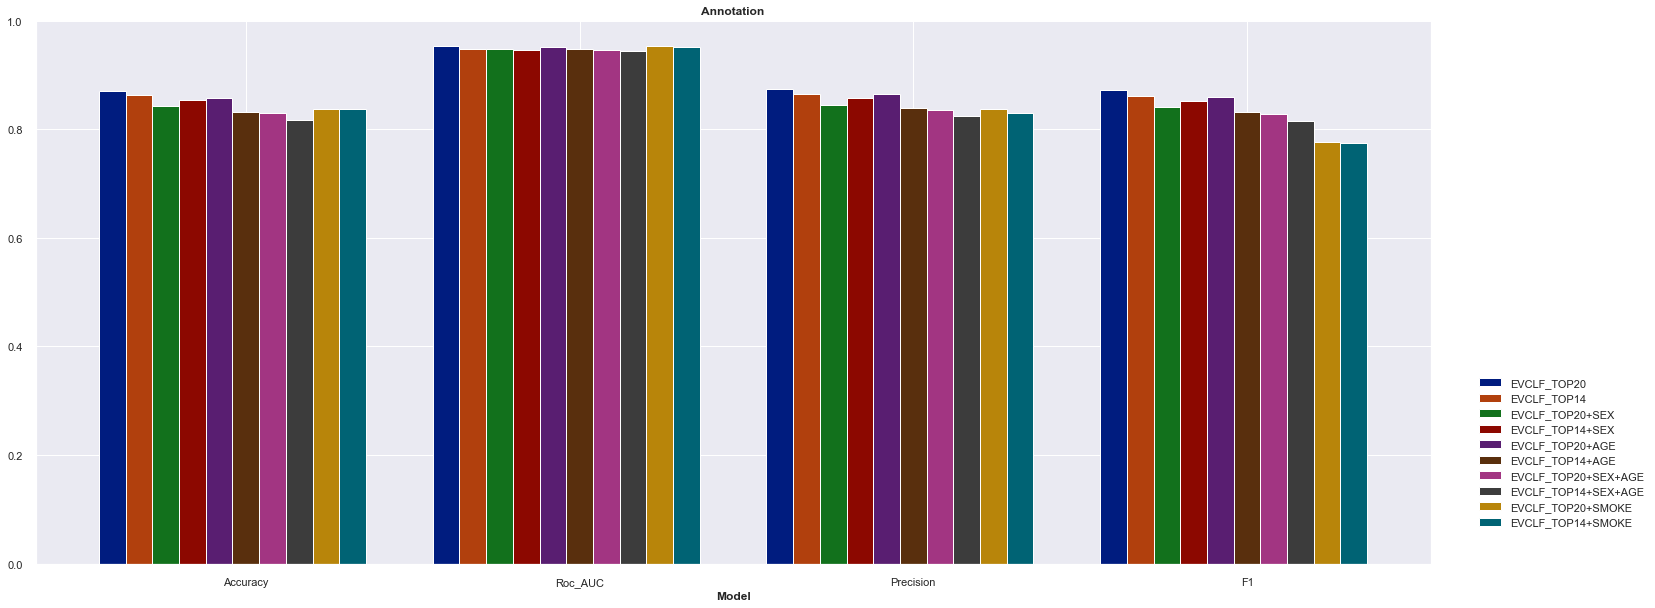

In [262]:
# set height of bars for Annotation Model
bars_heights_anno = [results_an["EVCLF_TOP20"]
                            , results_an["EVCLF_TOP14"]
                            , results_an["EVCLF_TOP20+SEX"]
                            , results_an["EVCLF_TOP14+SEX"]
                            , results_an["EVCLF_TOP20+AGE"]
                            , results_an["EVCLF_TOP14+AGE"]
                            , results_an["EVCLF_TOP20+SEX+AGE"]
                            , results_an["EVCLF_TOP14+SEX+AGE"]
                            , results_an["EVCLF_TOP20+SMOKE"]
                            , results_an["EVCLF_TOP14+SMOKE"]
                         ]

# use multibar_plot function to plot
multibar_plot(bars_heights_anno, labels_anno, name=labels_metric, title="Annotation", xlb="Model", barWidth = 0.08)

In [263]:
viz_summary(results_an, metric="Precision")

Precision Value:
EVCLF_TOP20            0.873980
EVCLF_TOP14            0.865306
EVCLF_TOP20+SEX        0.844205
EVCLF_TOP14+SEX        0.856924
EVCLF_TOP20+AGE        0.864385
EVCLF_TOP14+AGE        0.839503
EVCLF_TOP20+SEX+AGE    0.836074
EVCLF_TOP14+SEX+AGE    0.823987
EVCLF_TOP20+SMOKE      0.836273
EVCLF_TOP14+SMOKE      0.830441
Name: Precision, dtype: float64
----------------------------------------
Precision Rank:
EVCLF_TOP20            10.0
EVCLF_TOP14             9.0
EVCLF_TOP20+SEX         6.0
EVCLF_TOP14+SEX         7.0
EVCLF_TOP20+AGE         8.0
EVCLF_TOP14+AGE         5.0
EVCLF_TOP20+SEX+AGE     3.0
EVCLF_TOP14+SEX+AGE     1.0
EVCLF_TOP20+SMOKE       4.0
EVCLF_TOP14+SMOKE       2.0
Name: Precision, dtype: float64


In [264]:
# Finally it can be said clearly that annotation data doesn´t improve the model
# So it´s not necessary to include it
# This also solves the problem of missing values as for miRNA no values are missing

### Model Evaluation

In [265]:
# Finally it´s necessary to evaluate the model with unseen data

In [266]:
# Again Select Features (for TOP20 and TOP14) from X_train

# use dataframe_selection function for creating new dataframe with TOP20
X_train_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_train)

# use dataframe_selection function for creating new dataframe with TOP14
X_train_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_train)

In [267]:
#Select Features (for TOP20 and TOP14) from X_eval

# use dataframe_selection function for creating new dataframe with TOP20
X_eval_top20 = dataframe_selection(results_TBC["TBC"], X_train=X_eval)

# use dataframe_selection function for creating new dataframe with TOP14
X_eval_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=X_eval)

#### Top Model (EVCLF)

##### Top Model (EVCLF) + TOP20

In [268]:
# Final test with validation testset TOP20

EVCLF_eval = EVCLF

# Final Fit the model
EVCLF_eval.fit(X_train_top20, y_train)

y_final_top20 = EVCLF_eval.predict(X_eval_top20)

tm20 = score_eval(y_eval, y_final_top20)

Final Precision Score (micro): 0.6333333333333333
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.38      0.33      0.35         9
           2       0.67      0.75      0.71         8

    accuracy                           0.63        30
   macro avg       0.60      0.62      0.61        30
weighted avg       0.62      0.63      0.63        30

------------------------------------------------------------


##### Top Model (EVCLF) + TOP14

In [269]:
# Final test with validation testset TOP14

# Final Fit the model
EVCLF_eval.fit(X_train_top14, y_train)

y_final_top14 = EVCLF_eval.predict(X_eval_top14)

tm14 = score_eval(y_eval, y_final_top14)

Final Precision Score (micro): 0.6333333333333333
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.40      0.44      0.42         9
           2       0.71      0.62      0.67         8

    accuracy                           0.63        30
   macro avg       0.63      0.61      0.62        30
weighted avg       0.64      0.63      0.64        30

------------------------------------------------------------


In [270]:
# My Evaluation causes my model to underperform a lot (loss in precision by ~25%)

# reason could be overfitting to much the training data

#### Baseline Model Dummy Classifier (DC)

##### Baseline Model Dummy Classifier (DC) + TOP20

In [271]:
# using the dummy to have a comparison value
# Final test with validation testset TOP20 

dummy_eval = DummyClassifier(random_state=seed) # The Dummy Classifier is used as Baseline Model


# Final Fit the model
dummy_eval.fit(X_train_top20, y_train)

y_final_top20_dummy = dummy_eval.predict(X_eval_top20)

dummy20 = score_eval(y_eval, y_final_top20_dummy)

Final Precision Score (micro): 0.36666666666666664
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.44      0.31      0.36        13
           1       0.42      0.56      0.48         9
           2       0.22      0.25      0.24         8

    accuracy                           0.37        30
   macro avg       0.36      0.37      0.36        30
weighted avg       0.38      0.37      0.36        30

------------------------------------------------------------


/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [272]:
# Calculation the difference in Precision Scores for TOP20
# between Top Model and Dummy in percent

precision_diff = tm20-dummy20
print("The Difference in Precision Score (micro):", precision_diff*100, "%")

The Difference in Precision Score (micro): 26.666666666666668 %


##### Baseline Model Dummy Classifier (DC) + TOP14

In [273]:
# Final test with validation testset TOP14

# Final Fit the model
dummy_eval.fit(X_train_top14, y_train)

y_final_top14 = dummy_eval.predict(X_eval_top14)

dummy14 = score_eval(y_eval, y_final_top14)

Final Precision Score (micro): 0.36666666666666664
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.44      0.31      0.36        13
           1       0.42      0.56      0.48         9
           2       0.22      0.25      0.24         8

    accuracy                           0.37        30
   macro avg       0.36      0.37      0.36        30
weighted avg       0.38      0.37      0.36        30

------------------------------------------------------------


In [274]:
# Calculation the difference in Precision Scores for TOP14
# between Top Model and Dummy in percent

precision_diff = tm14-dummy14
print("The Difference in Precision Score (micro):", precision_diff*100, "%")

The Difference in Precision Score (micro): 26.666666666666668 %


#### Visualisation Model Evaluation

In [275]:
# As both TOP20 and TOP14 show the same performance, there´s no need to use 20 miRNA

In [276]:
# to visualize the model evaluation I choose my best results vs. dummy

##### Top Model (EVCLF) + TOP14

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


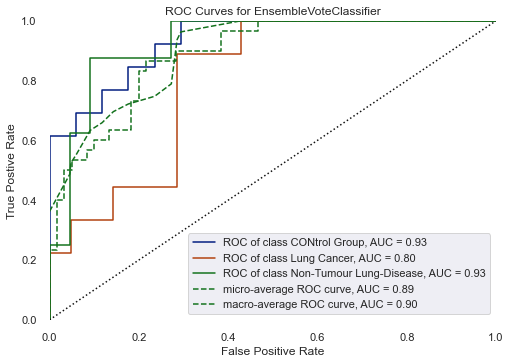

In [277]:
# EVCLF_eval Classification model is already instantiated

# hide axes for better visualisation
ax = plt.axes(frameon=False)

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(EVCLF_eval, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# The model is already fitted to the data
# Fit the training data to the visualizer
visualizer_rocauc.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_rocauc.show();    

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


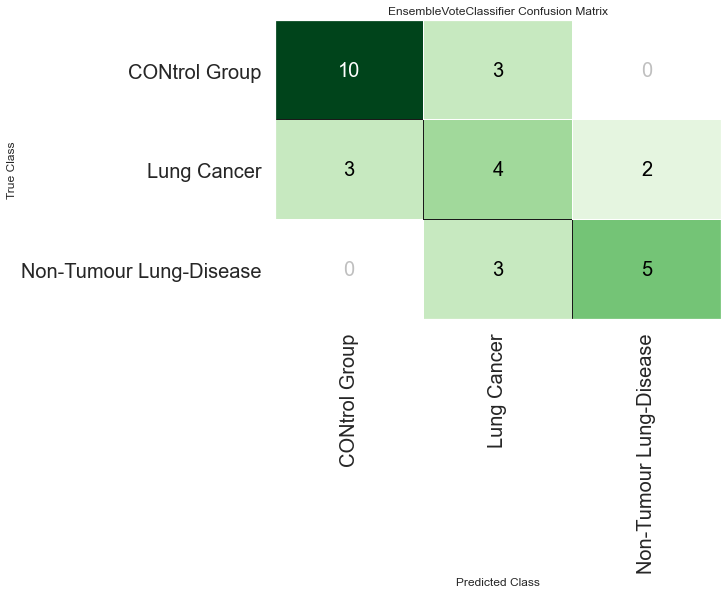

In [278]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(EVCLF_eval,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap= "Greens",
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_eval_top14, y_eval)

# Finalize and render the figure
visualizer_cm.show();

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


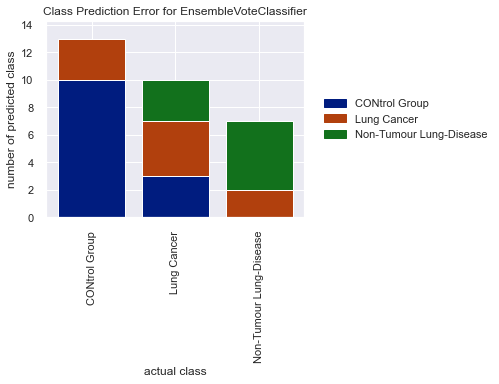

In [279]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(EVCLF_eval,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_cpe.show();  

In [280]:
# From 9 Lung Cancer cases, 4 get correctly classified, 3 are classified as CONtrol Group
# and 2 are classified as Non-Tumour Lung-Disease
# This means those with the NTLD have still the chance to be recognized as Cancer from a medical doctor during further examination
# but the 3 in the CONtrol group are lost in the screening 

# 3 from 13 in the control group are classified as Lung Cancer (not very precise)
# which causes unnecessary anxieties, but NTLD hasn´t to be checked

# 3 from 8 of NTLD cases are classified as Lung Cancer, but 0 as CONtrol,
# luckily all of them would be checked and won´t get lost in the screening

##### Baseline Model Dummy Classifier (DC) + TOP14

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


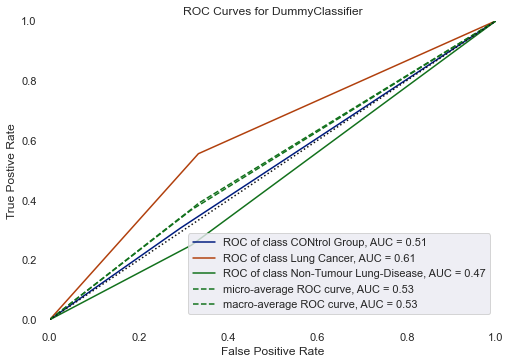

In [281]:
# dummy_eval Classification model is already instantiated

# hide axes for better visualisation
ax = plt.axes(frameon=False)

# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_rocauc = ROCAUC(dummy_eval, 
                           classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"], 
                           per_class=True)

# The model is already fitted to the data
# Fit the training data to the visualizer
visualizer_rocauc.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_rocauc.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_rocauc.show();    

/Users/P_Neubert/Anaconda/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


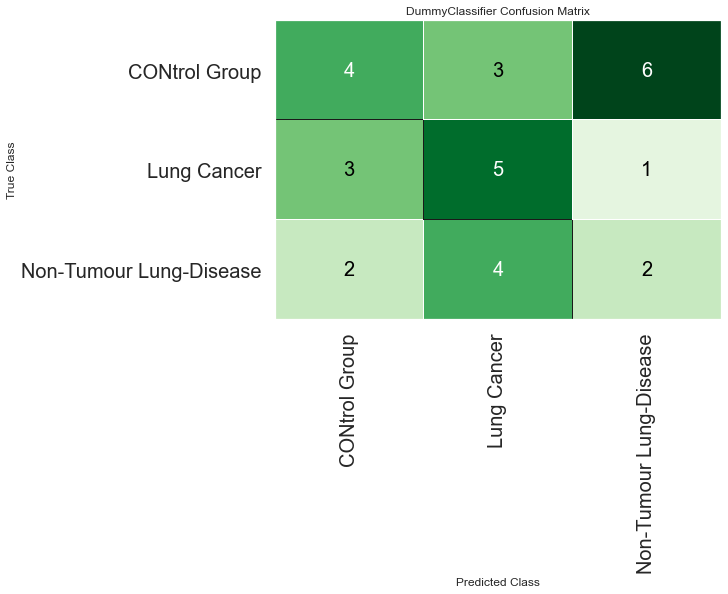

In [282]:
# Instantiate the visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cm = ConfusionMatrix(dummy_eval,        
                                classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"],
                                cmap= "Greens",
                                fontsize=20)                                      

# Fit the training data to the visualizer
visualizer_cm.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cm.score(X_eval_top14, y_eval)

# Finalize and render the figure
visualizer_cm.show();

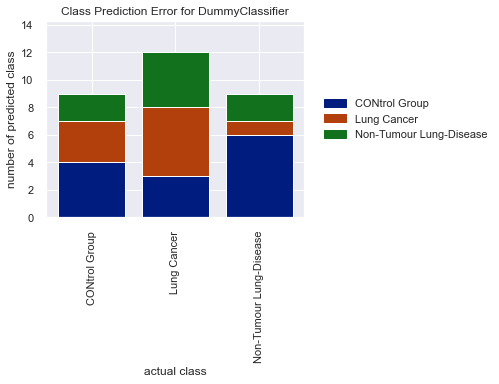

In [283]:
# Instantiate the classification model and visualizer
# 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)
visualizer_cpe = ClassPredictionError(dummy_eval,        
                                      classes=["CONtrol Group", "Lung Cancer", "Non-Tumour Lung-Disease"])

# Fit the training data to the visualizer
visualizer_cpe.fit(X_train_top14, y_train)

# Evaluate the model on the test data
visualizer_cpe.score(X_eval_top14, y_eval)        

# Finalize and render the figure
visualizer_cpe.show();  

## Visualisation

### Correlation Heatmap

In [284]:
# To visualize correlation in the TOP20 miRNA panel and the predicted labels

In [285]:
# first create a Dataframe for correlation analysis
df_corr = df4.copy()

In [286]:
# for better correlation I need to convert my categorical labels to dummy variable (don´t drop first)
# this means 0 = CON (CONtrol Group), 1 = LCa (Lung Cancer), 2 = NTLD (Non-Tumour Lung-Disease)

label_dummies = pd.get_dummies(df_corr.Label, drop_first=False)

In [287]:
# for a nicer picture rename columns

label_dummies = label_dummies.rename(columns={0:"CONtrol Group"})
label_dummies = label_dummies.rename(columns={1:"Lung Cancer"})
label_dummies = label_dummies.rename(columns={2:"Non-Tumour Lung-Disease"})
label_dummies

,CONtrol Group,Lung Cancer,Non-Tumour Lung-Disease
0,0,0,1
1,0,0,1
2,0,0,1
3,0,1,0
4,0,0,1
...,...,...,...
295,0,0,1
296,1,0,0
297,0,1,0
298,0,0,1


In [288]:
# Then Create TOP14 Features

# use dataframe_selection function for creating new dataframe with TOP14 from initial dataframe
corr_top14 = dataframe_selection(TOP14_dict["TOP14"], X_train=df_corr)

# Then merge datasets
corr_top14_merge = pd.concat([corr_top14, label_dummies], axis=1)
corr_top14_merge

,hsa-let-7b-5p,hsa-miR-1202,hsa-miR-1255b-5p,hsa-miR-17-3p,hsa-miR-1910-5p,hsa-miR-192-5p,hsa-miR-21-3p,hsa-miR-3152-3p,hsa-miR-3190-5p,hsa-miR-320a,hsa-miR-323a-3p,hsa-miR-4258,hsa-miR-564,hsa-miR-590-5p,CONtrol Group,Lung Cancer,Non-Tumour Lung-Disease
0,2888.175532,50.950932,9.091305,21.280932,6.771879,152.507732,7.521196,6.682097,6.369587,606.672532,12.767072,6.205426,26.938502,9.554410,0,0,1
1,3805.584560,66.364360,9.649856,21.316760,6.097541,147.643860,8.951785,5.708978,7.047752,1077.584560,9.567745,6.463475,27.315990,10.192328,0,0,1
2,1262.754060,65.240960,10.931380,24.524660,6.311957,434.482060,7.647565,6.516933,5.804688,659.008060,12.234840,5.248770,28.881370,11.258370,0,0,1
3,7857.315268,161.748879,18.387115,165.060168,8.573949,8296.037337,17.169751,8.638181,9.847889,2553.483468,11.960178,8.510600,16.879271,32.306567,0,1,0
4,9886.602937,77.438858,24.814688,325.429428,5.432417,6163.943147,32.963974,7.496150,21.901990,1154.569026,9.857124,5.308309,18.476753,150.903012,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,47644.899330,107.401538,62.621394,322.413229,5.472294,3487.456283,105.346331,5.644443,18.344736,3794.985621,11.116078,5.426972,12.807603,140.627039,0,0,1
296,16593.222849,92.730486,26.836231,30.258174,10.131975,3468.989700,22.731887,8.191751,14.344527,2190.251325,12.892194,9.130648,40.417256,69.008556,1,0,0
297,83604.788124,144.029057,64.163306,114.561375,7.002087,2198.976305,12.825581,8.102327,10.783637,2761.027505,22.636650,7.660759,19.582345,82.446660,0,1,0
298,20045.890411,74.596685,54.456477,385.985225,6.153332,9447.393788,38.967085,6.513002,16.399923,2654.364671,7.270799,6.188532,15.067109,145.356837,0,0,1


In [289]:
# here we can see which miRNA is positiv are negative correlated with a label
# or an other miRNA

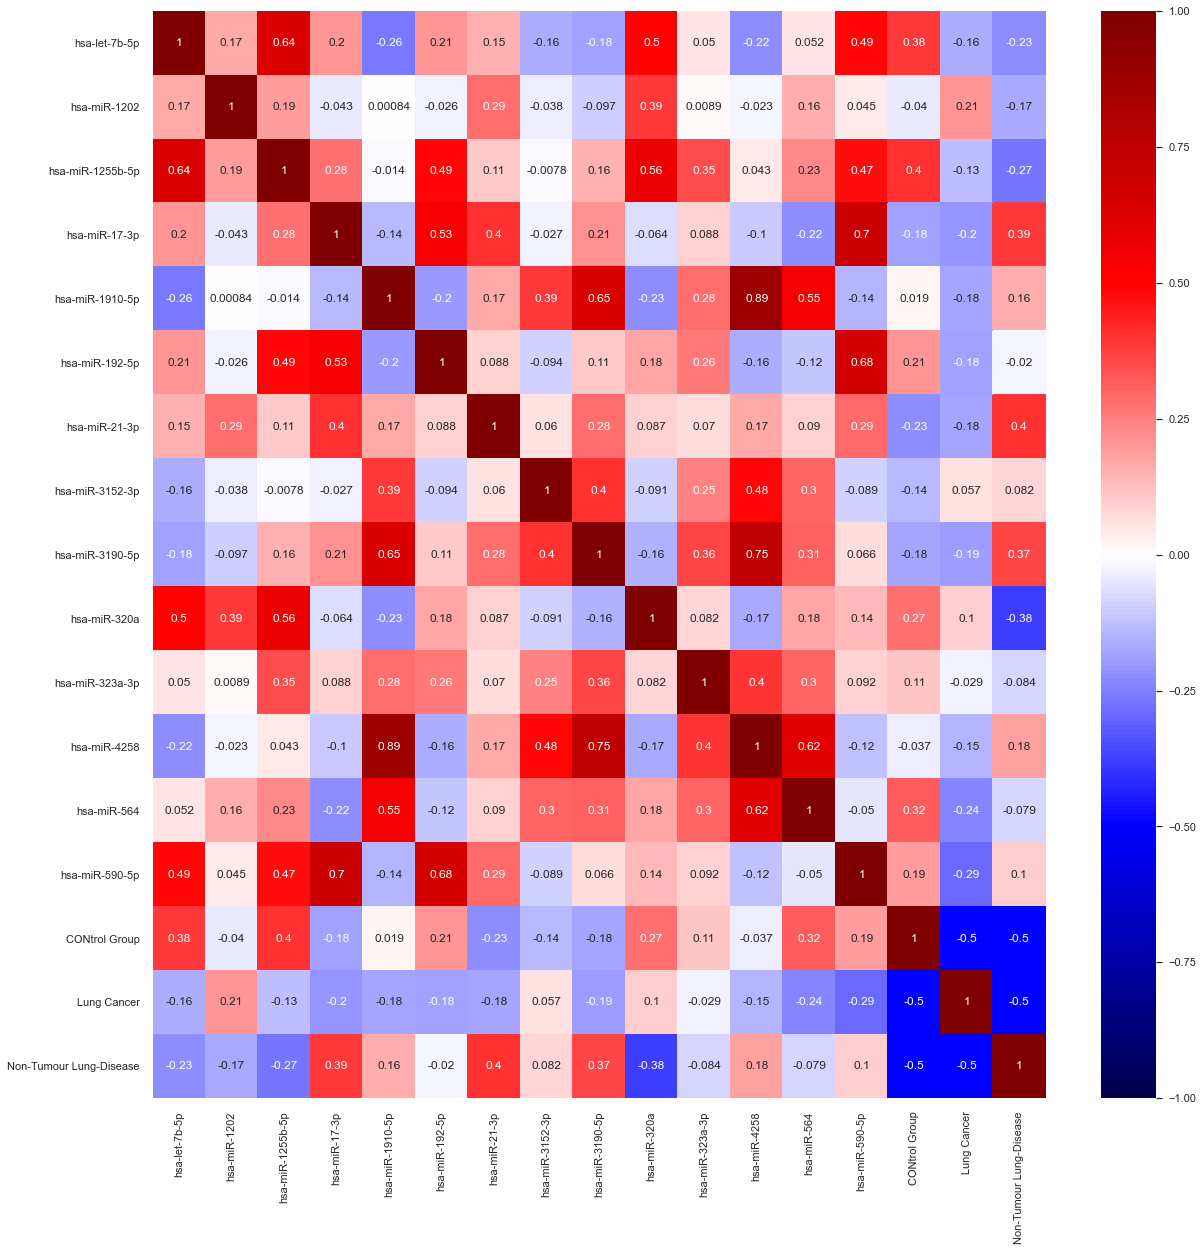

In [290]:
# Then correlate features
correlation_TOP14 = corr_top14_merge.corr()

# and use heatmap function
heatmap(correlation_TOP14, name_savefig="figures/heatmap_top14")

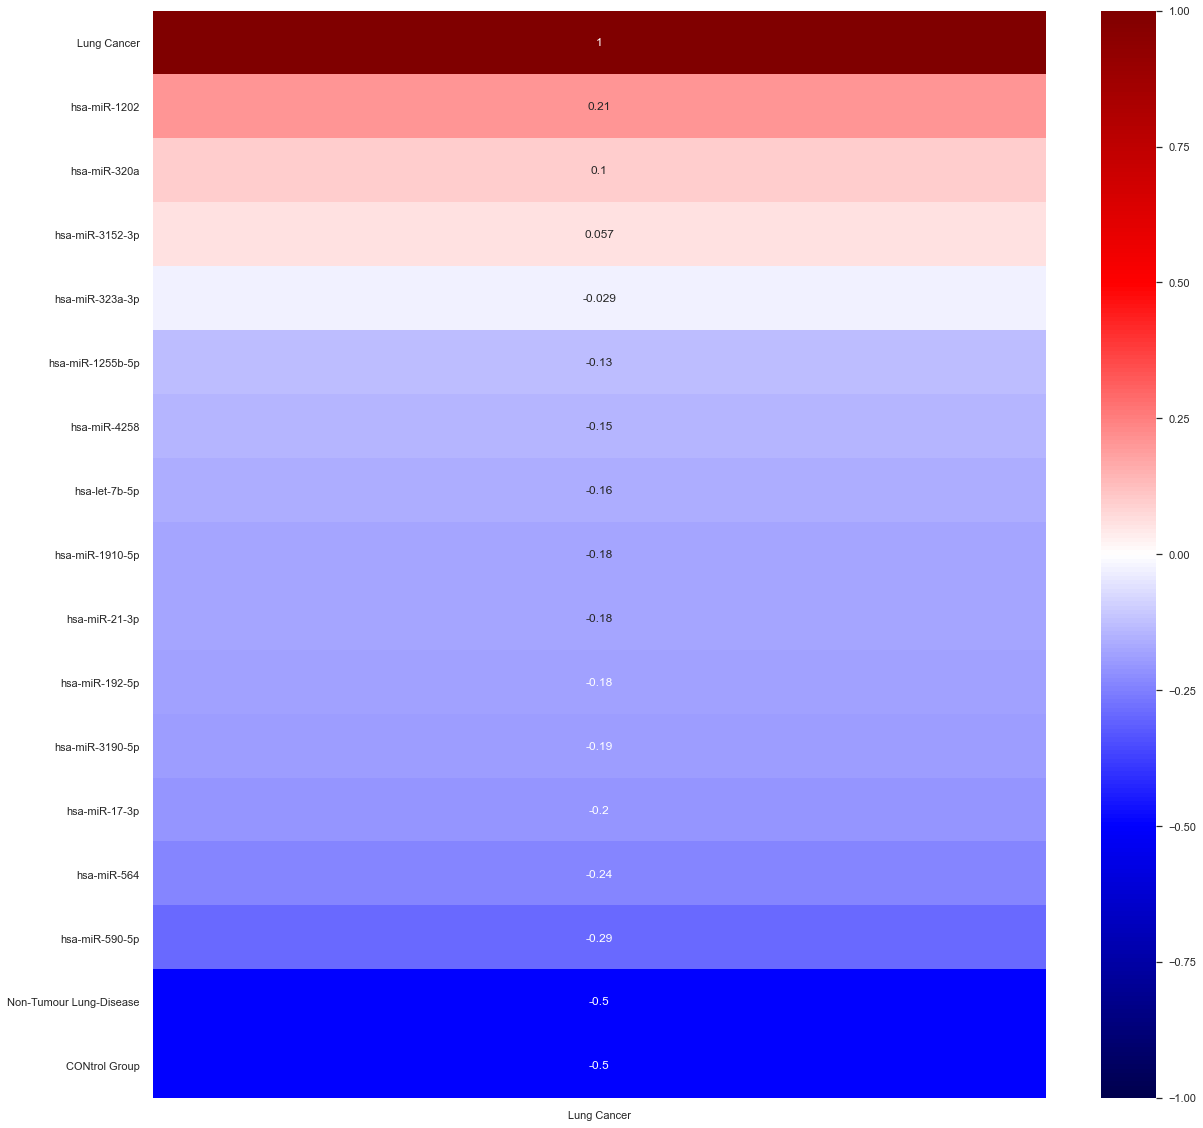

In [291]:
# Check for Label details
heatmap_LCa = correlation_TOP14[['Lung Cancer']].sort_values(by=['Lung Cancer'],ascending=False)
                                                       
heatmap(heatmap_LCa, name_savefig="figures/heatmap_LCa")                                                   

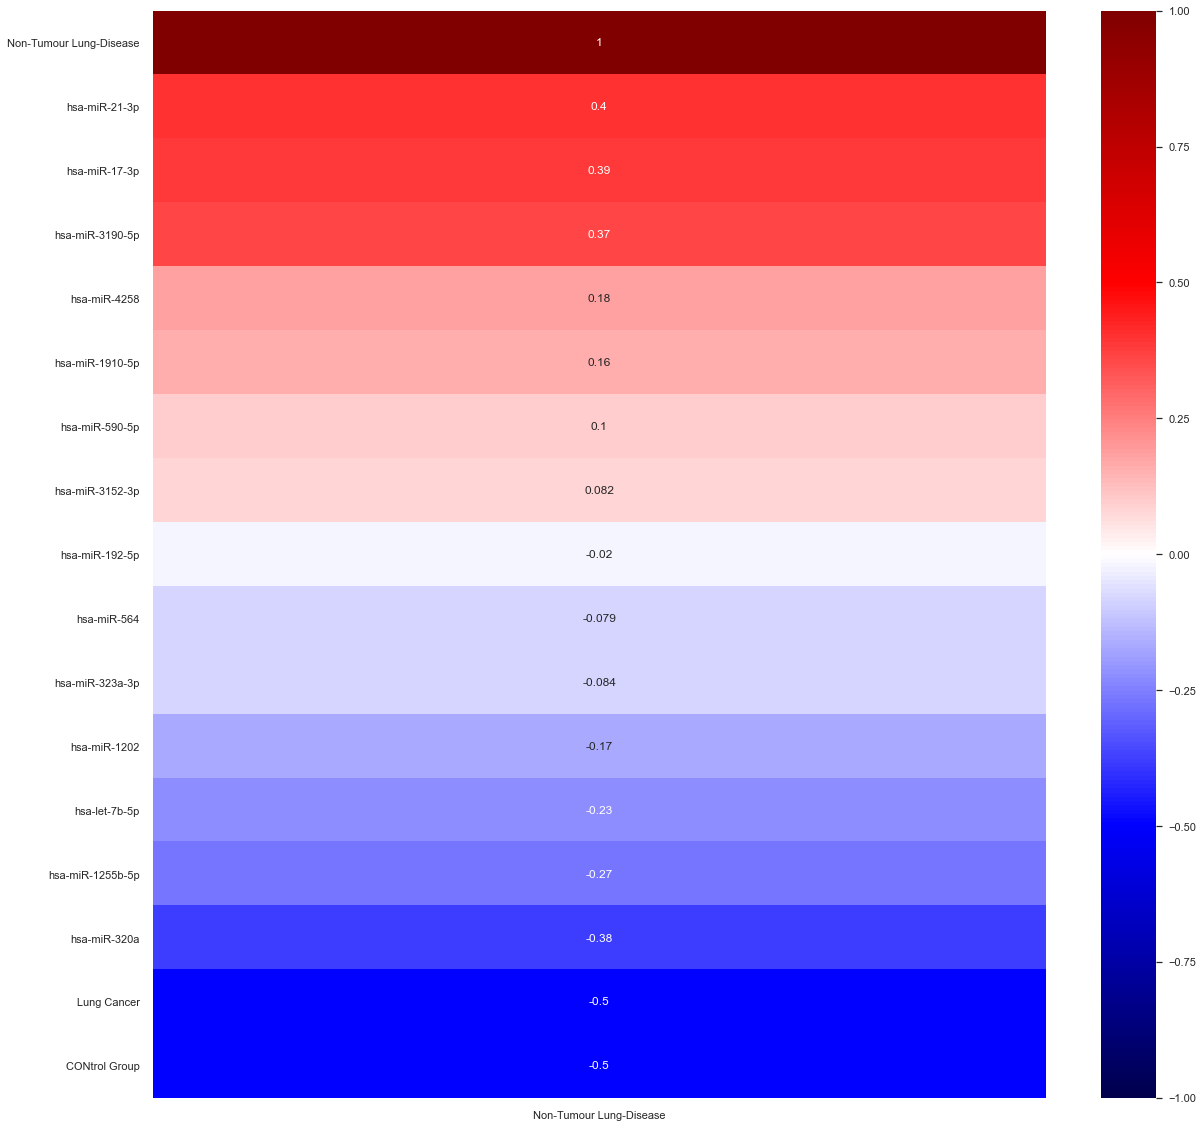

In [292]:
# Check for Label details
heatmap_NTLD = correlation_TOP14[['Non-Tumour Lung-Disease']].sort_values(by=['Non-Tumour Lung-Disease'],ascending=False)
                                                       
heatmap(heatmap_NTLD, name_savefig="figures/heatmap_NTLD")                                                   

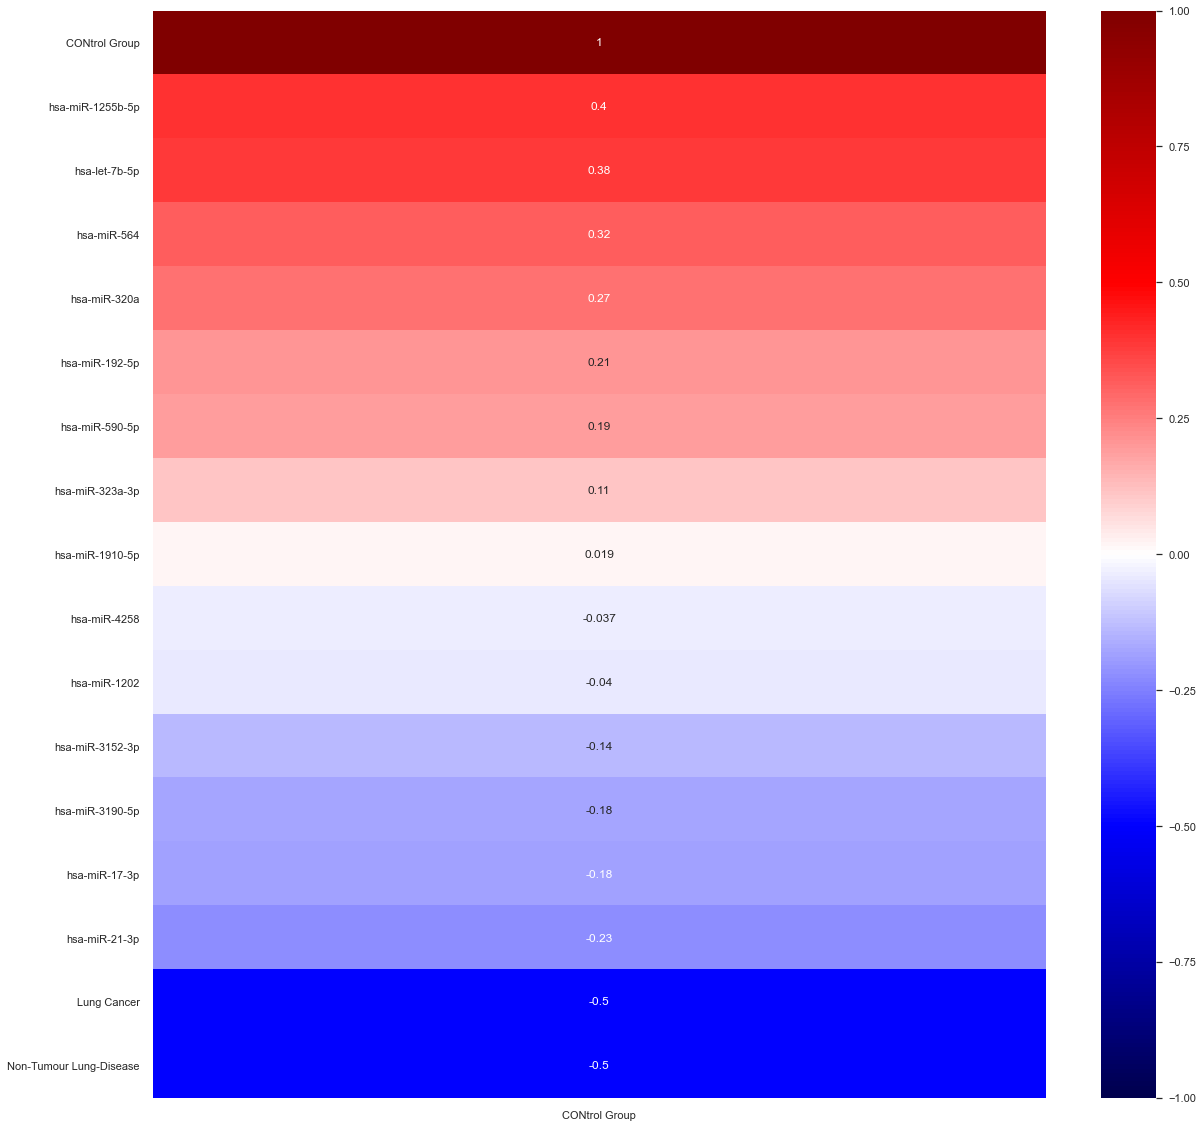

In [293]:
# Check for Label details
heatmap_CON = correlation_TOP14[['CONtrol Group']].sort_values(by=['CONtrol Group'],ascending=False)
                                                       
heatmap(heatmap_CON, name_savefig="figures/heatmap_CON")                                                   